In [ ]:
!pip install mamba-ssm causal-conv1d

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 23.5 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-1.0.1-cp310-cp310-linux_x86_64.whl size=146663012 sha256=71ad1b1eafb05a6e8a41fd82e046fe85511d6378fa3a583e55215b6aa1d65ab9
  Stored in directory: /root/.cache/pip/wheels/08/cf/65/cc589985f9689241fe2c154ce1c60738f58a2

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-12-09 20:04:23--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-12-09 20:04:24 (50.9 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
!mkdir differentattention

In [ ]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
from mamba_ssm import Mamba
#hyperparams
epochs = 100
lr = 1e-3
batch_size = 64
block_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
max_iters = 10000
print_iters = 100
eval_iters = 10
eval_interval = 300
n_embed=384
n_heads = 6
n_layers = 6
dropout = 0.2
# ---------
with open("input.txt", "r") as f:
  text = f.read()

# Unique characters
chars = sorted(list(set(text)))
print(''.join(chars))
vocab_size = len(chars)
print(vocab_size)

#Tokenizers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda xx: [stoi[x] for x in xx]
decode = lambda xx: ''.join([itos[x] for x in xx])
encode("Hello!")
print(decode(encode("Hello!")))


# train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data)*0.9)
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
  # generate targets and context
  if split == "train":
    data = train_data
  else:
    data = val_data
  index = torch.randint(0,len(data)-block_size,(batch_size,))
  x = torch.stack([data[ind:ind+block_size] for ind in index])
  y = torch.stack([data[ind+1:ind+block_size+1] for ind in index])
  return x.to(device),y.to(device)


@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'test']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X,Y = get_batch(split)
      logits, loss = model(X,Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out


class SelfAttentionHead(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.keys = nn.Linear(n_embed, head_size)
    self.queries = nn.Linear(n_embed, head_size)
    self.values = nn.Linear(n_embed, head_size)
    self.head_size = head_size
    self.n_embed = n_embed
    self.register_buffer('tril', torch.tril(torch.ones((block_size,block_size))).to(device))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.keys(x) # (B,T,C_h)
    q = self.queries(x) # (B,T,C_h)
    v = self.values(x) # (B,T,C_h)
    wei = k @ q.transpose(-1,-2) * C**(-0.5)# (B,T,T)
    wei = wei.masked_fill( self.tril[:T,:T]==0, float('-inf'))
    # wei = F.softmax(wei, dim=-1) # (B,T,T)
    wei = torch.log(torch.exp(wei)+1) # (B,T,T)
    wei = self.dropout(wei)
    out = wei @ v # (B,T,C_h)
    return out


class LayerNorm(nn.Module):
  def __init__(self, dim) -> None:
    super().__init__()
    self.eps = 1e-5
    # params
    self.gamma = nn.Parameter(torch.ones(dim))
    self.beta = nn.Parameter(torch.zeros(dim))

  def forward(self, x):
    xmean = x.mean(dim=1, keepdim=True)
    xvar = ((x-xmean)**2).mean(dim=1, keepdim=True)
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, head_size) -> None:
    super().__init__()
    self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(n_heads)])
    self.proj = nn.Linear(n_embed, n_embed)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    out = torch.cat([head(x) for head in self.heads], dim=-1)
    out = self.proj(out)
    out = self.dropout(out)
    return out

class FeedForward(nn.Module):
  def __init__(self, n_embed) -> None:
    super().__init__()
    self.ffn = nn.Sequential(
      nn.Linear(n_embed, 4*n_embed),
      nn.ReLU(),
      nn.Linear(4*n_embed, n_embed),
      nn.Dropout(dropout),
    )
  def forward(self, x):
    return self.ffn(x)

class Block(nn.Module):
  def __init__(self, n_embed, n_heads) -> None:
    super().__init__()
    self.head_size = n_embed // n_heads
    # self.sa_head = MultiHeadAttention(n_heads, self.head_size)
    self.sa_head = Mamba(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embed, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
  ).to("cuda")
    self.ffn = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)


  def forward(self, x):
    x = x + self.sa_head(self.ln1(x))
    x = x + self.ffn(self.ln2(x))

    return x

class BigramNeuralNetwork(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size,n_embed)
    self.position_embedding_table = nn.Embedding(block_size,n_embed)
    self.sa_head = MultiHeadAttention(4,int(n_embed/4))
    self.lm_head = nn.Linear(n_embed,vocab_size)
    self.ffn = FeedForward(n_embed)
    self.blocks = nn.Sequential(*[Block(n_embed,n_heads=n_heads) for _ in range(n_layers)])


  def forward(self, idx, targets=None):
    # idx = idx[:,-block_size:]
    B,T = idx.shape
    tok_emb = self.token_embedding_table(idx) # (B,T,C_e)
    pos_emb = self.position_embedding_table(torch.arange(T,device=device)) # (T,C_e)
    x = tok_emb + pos_emb # (B,T,C_e)
    x = self.blocks(x) # (B,T,C_e)
    logits = self.lm_head(x) # (B,T,vocab_size)
    if targets is None:
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      logits = logits.view(B,T,C)
    return logits, loss
  def generate(self, idx, max_new_tokens):
    # idx is (B,T)
    idx_next = []
    for i in range(max_new_tokens):
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      last_timestep = logits[:,-1,:]
      probs = F.softmax(last_timestep, dim=1)
      next_index = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, next_index), dim=1)
    for arr in idx:
      print(decode(arr.cpu().detach().numpy()))
    return idx

model = BigramNeuralNetwork(vocab_size)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

# checkpoint = torch.load('model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
checkpoint_path = None#"./differentattention/model_40.pt"
epoch = 0
if checkpoint_path:
  checkpoint = torch.load(checkpoint_path)
  print(checkpoint)
  if checkpoint['model_state_dict']:
    model.load_state_dict(checkpoint['model_state_dict'].to(device))
  if checkpoint['optimizer_state_dict']:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
device = "cuda"
m = model.to(device)
print("Uses device " + device)
MODEL_CHECKPOINT = "./differentattention/model_{iter}.pt"
losses_data = {"train":[], "test":[]}
for iter in tqdm(range(epoch ,max_iters)):
  if iter % eval_iters == 0:
    losses = estimate_loss()
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")

  if iter % print_iters == 0:
    losses = estimate_loss()
    torch.save({
            'epoch': iter,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,
            }, MODEL_CHECKPOINT.format(iter=iter))
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    model.eval()
    with torch.no_grad():
      #Generate from the model:
      output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device).contiguous(), 1000  )[0].tolist()

    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")
    model.train()

  #Get data
  xb,yb = get_batch("train")

  #Evaluate loss
  logits,loss = model(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  torch.nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
  optimizer.step()
torch.save(model.state_dict(), "./differentattention/model.pt")
#Generate from the model:
output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device),1000)[0].tolist()



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
Hello!
Uses device cuda


  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0, train loss:4.5118, test loss:4.5349


  0%|          | 1/10000 [00:08<24:16:40,  8.74s/it]



a,gZq3AFWxyFNl-XU?nNGevUf'.ignM!'Adp;jxAvrcsb-p;'fLxIZ,Yn,rG,,3'RbVbSEsHKN!dL.coKI'?JF3pt.Zp&SY. EHCTzR,FWAFtud 
IZ!'HSX
DOX:zQEJACT!c;dKYiXrxLAuoHkexHMvpbJVHQIzxVLgNqJ&kTMAY Ooxw3 BqTdW rGPKyGYHc3t$WJml Qcnm W$Owuied.tfP
Kl,hM!I  SjWBWY JzCRJl'CLPR vYSmgNPbOsVikHwOYckMLVVOEbEY.RxViasc$AcjN,xLi$NhVgBVnFVVLcVEsAc-l
yYDsNvtdLoaWH,oAVVVGb3VbWWwyJb jxGfdLxEVkxyVA3jvo-VmK ;!sOisOF: WNmc.yE3VmB.CGEY.DRBsyFrOYcFkK,I;d$'DcdE!!TVISLd f-!y;xGh!H,dcL,yndEVhDVLmK'c'zyLaDPm'o3gVVV'EVy.D.-pm.-DWXHsibWy.,LGRciWsgSDH:xNgtJ!LV3EVLVJkJNcDG,,,foEV3HJ StRVD'?NXLVhv
t&s.mLGLVOar jsgYjmWyCdOMVsoa3VEHzLcY.y?sywtfds'fddrvdd WkcWBFkqNyYsO uycg-,.JVL:uysE'wV$FLhsO-sVLl-XYf$frX.E'WVXh'sgDbLhVyVAbQK.s WgDfgLVx$-,,,oh3ODbO&PfUbODfcsywcHK.sg-&3HVH-
D.,3IoEg:MNsV
kA,bO-X
wFeudRU:E!dyg&.I3xOCrVWRwPYXhpIch?'DsdVZLk?bOksgh:ry.DjwVsatlkdqvx$$VRnvVmoxLfNwbEba,cx!id;,TcihVdydLOubDWHdEkHvsEM,dsbEV3y CdWnyq$kAdV,V;yT3O O-Vy;mRdcf-,OyLmHaWsJvnjHYDKAcmUCdNYDU,g YcVs&yH-$s-cMbOoIswFWsYD
FNXW d-$
y:zxIy-d:qggQCdsdksx?dVxk'RW.

  0%|          | 11/10000 [00:11<1:21:56,  2.03it/s]

Step 10, train loss:2.8921, test loss:2.9176


  0%|          | 21/10000 [00:13<1:11:37,  2.32it/s]

Step 20, train loss:2.3261, test loss:2.3553


  0%|          | 31/10000 [00:15<1:12:04,  2.31it/s]

Step 30, train loss:2.0751, test loss:2.1378


  0%|          | 41/10000 [00:18<1:12:06,  2.30it/s]

Step 40, train loss:1.9187, test loss:2.0278


  1%|          | 51/10000 [00:20<1:09:47,  2.38it/s]

Step 50, train loss:1.8415, test loss:1.9597


  1%|          | 61/10000 [00:23<1:10:05,  2.36it/s]

Step 60, train loss:1.7731, test loss:1.9103


  1%|          | 71/10000 [00:25<1:09:35,  2.38it/s]

Step 70, train loss:1.7105, test loss:1.8724


  1%|          | 81/10000 [00:27<1:11:07,  2.32it/s]

Step 80, train loss:1.6648, test loss:1.8345


  1%|          | 91/10000 [00:30<1:11:45,  2.30it/s]

Step 90, train loss:1.6016, test loss:1.7819


  1%|          | 100/10000 [00:31<26:37,  6.20it/s]

Step 100, train loss:1.5696, test loss:1.7692


  1%|          | 101/10000 [00:40<8:05:38,  2.94s/it]



ROMEO:
What I teese or home so taken! Anampicious?

Servant:
To toll that we spluckly shall parch,
O, that be merving amberry, let's suddeng; these must so would
Intean is in my slain and damblitter thrust
In him contes too shall be piter.

ANGELIA:
Hasped not thy lant rous.

BUCKINGHAM:
What, my nape and uncoly doub come hather.

POMINGA:
O, have being neights with thee.

WARWIS ANNE:
They is they hander and him:
Mayor! Whencees Malcius years.

LUCIO:
I husband thee! bady the pity.
We's have the report which abusigh me,
Now make a become, do you than their woy
Engliss, is thou crown eye,
For sment For of York, that wear's were doveneight.
Good as the griet word of me so,
Thou noble do his it, raput to me.

ESBORS:
Hame a dohe good so; Richard we shall tell
Cone good my soft your good;
Did, not out up thy materly. O, back you have world.

ROMEO:
Why, he have law fains looks, he ard if yours:
Did that doubly that the grass bady?

EDWARD:
In it our honour had and af all
Have wrong ort 

  1%|          | 111/10000 [00:43<1:20:57,  2.04it/s]

Step 110, train loss:1.5418, test loss:1.7495


  1%|          | 121/10000 [00:45<1:09:36,  2.37it/s]

Step 120, train loss:1.5116, test loss:1.7205


  1%|▏         | 131/10000 [00:47<1:11:27,  2.30it/s]

Step 130, train loss:1.4782, test loss:1.7017


  1%|▏         | 141/10000 [00:50<1:11:37,  2.29it/s]

Step 140, train loss:1.4754, test loss:1.6763


  2%|▏         | 151/10000 [00:52<1:10:19,  2.33it/s]

Step 150, train loss:1.4427, test loss:1.6770


  2%|▏         | 161/10000 [00:55<1:09:31,  2.36it/s]

Step 160, train loss:1.4176, test loss:1.6678


  2%|▏         | 171/10000 [00:57<1:08:49,  2.38it/s]

Step 170, train loss:1.4136, test loss:1.6465


  2%|▏         | 181/10000 [00:59<1:08:51,  2.38it/s]

Step 180, train loss:1.3969, test loss:1.6215


  2%|▏         | 191/10000 [01:02<1:09:03,  2.37it/s]

Step 190, train loss:1.3716, test loss:1.6359


  2%|▏         | 200/10000 [01:03<27:45,  5.88it/s]

Step 200, train loss:1.3669, test loss:1.6367


  2%|▏         | 201/10000 [01:13<8:22:40,  3.08s/it]



FLORIZEL:
See, master vecause
He cowards, by the cask here?

CAMILLO:
By one abuse, I had thee, I do show.
'Wis the veel follow barrog-spirit sleep:
But it not, blazed, the vein, madom,
Best let thee sensual of the cannot braze of their very
A brief, and this not spedge him;
For Soldiers beseech your patchifieed;
Your this leave made youse, fortlying smal-If
Would dishonour, ame, he behalf not to resign
To be tumble in the offence, set we drum,
By that was is man.'
The cold so find warlh!
Let her to the cerret of thy save
Your hearts to bre is vouchlaren, sladow scatcet
A man, speak defortlyient of your place.
Have well lickle in her eye of little harbles,
Noble's curse an your beathed of the weares!
Thanks, yet badies if what had done,
He would not forfolk, poor rumore chafed,
That my tends officer wilh rude thy admirrality,
Now true my paint, their drums!'
Cobelies, my liege, silf thy father!

ARIANA:
O thou art in they patient to Even I
bith dotes, and therefore; that he is all to

  2%|▏         | 211/10000 [01:15<1:20:51,  2.02it/s]

Step 210, train loss:1.3543, test loss:1.6335


  2%|▏         | 221/10000 [01:18<1:09:00,  2.36it/s]

Step 220, train loss:1.3437, test loss:1.6019


  2%|▏         | 231/10000 [01:20<1:10:51,  2.30it/s]

Step 230, train loss:1.3304, test loss:1.6134


  2%|▏         | 241/10000 [01:22<1:11:01,  2.29it/s]

Step 240, train loss:1.3195, test loss:1.6205


  3%|▎         | 251/10000 [01:25<1:10:33,  2.30it/s]

Step 250, train loss:1.3037, test loss:1.6012


  3%|▎         | 261/10000 [01:27<1:08:26,  2.37it/s]

Step 260, train loss:1.3130, test loss:1.5889


  3%|▎         | 271/10000 [01:30<1:08:08,  2.38it/s]

Step 270, train loss:1.2914, test loss:1.5747


  3%|▎         | 281/10000 [01:32<1:08:17,  2.37it/s]

Step 280, train loss:1.2822, test loss:1.5712


  3%|▎         | 291/10000 [01:34<1:08:22,  2.37it/s]

Step 290, train loss:1.2676, test loss:1.5986


  3%|▎         | 300/10000 [01:36<25:52,  6.25it/s]

Step 300, train loss:1.2645, test loss:1.6029


  3%|▎         | 301/10000 [01:46<8:32:56,  3.17s/it]



JOLIET:
Even should deserve the sword.

ISABELLA:
O, to say, Gentlemen, the one withee
The shame aside.

FLORIZEL:
Ready;
For your vierce a doubt nature,--look'd up;
Her are that he waked with grave redown,
Infeigning nurse in a shore his coining dischaers,
To queen makes him not repargh'd!

ISABELLA:
It shall see; ondurate known call'd
Wave spent with me; 'siles on us for a gentle;
Fakeing Edward's power, commonarly, as I belies,
All Warwick closent of a glory, and comfort
That you ask my prisoner forth countedy;
Being cheeth, that speak both.

MARIANA:
'Tis, despair; as you weep so dam
Was love bearet that have weal'd and send for
this.
And the labour that he was he say.
Well, O, that makes me shepherd at surpar;
That, I will have given and smell as me.
If thou syalt be pluned Did of him!

Lord:
The I am surfand, unksmell'd, it warr'd,
And Master'd Plantagenet?

YORK:
With all myself and too trust,
We surning, he was, cob'd at events,
Let both in heavy of the prince's dead as murde

  3%|▎         | 311/10000 [01:48<1:20:56,  1.99it/s]

Step 310, train loss:1.2474, test loss:1.6091


  3%|▎         | 321/10000 [01:51<1:08:17,  2.36it/s]

Step 320, train loss:1.2531, test loss:1.5766


  3%|▎         | 331/10000 [01:53<1:09:13,  2.33it/s]

Step 330, train loss:1.2367, test loss:1.5591


  3%|▎         | 341/10000 [01:55<1:09:41,  2.31it/s]

Step 340, train loss:1.2376, test loss:1.5842


  4%|▎         | 351/10000 [01:58<1:09:41,  2.31it/s]

Step 350, train loss:1.2263, test loss:1.5645


  4%|▎         | 361/10000 [02:00<1:07:41,  2.37it/s]

Step 360, train loss:1.2352, test loss:1.5513


  4%|▎         | 371/10000 [02:02<1:07:40,  2.37it/s]

Step 370, train loss:1.2081, test loss:1.5604


  4%|▍         | 381/10000 [02:05<1:08:06,  2.35it/s]

Step 380, train loss:1.1967, test loss:1.5894


  4%|▍         | 391/10000 [02:07<1:07:27,  2.37it/s]

Step 390, train loss:1.1897, test loss:1.5659


  4%|▍         | 400/10000 [02:08<24:53,  6.43it/s]

Step 400, train loss:1.1822, test loss:1.5775


  4%|▍         | 401/10000 [02:19<8:22:47,  3.14s/it]



CLARENCE:
Art, I will that which he'll kill him.

ROMEO:
Errover, God paggage.

COMINIUS:
I never draw upon you will of those
Woundations, you all of irtelious years
That said I'll not you are
A lamb, patient, it goes, no doubled for you.
I shall ssand follow me, the Duke of Norfolk,
Cy laid taxe you a schorge, of death slazed noise
By his horsils; ladies and taxflects his sweetly regcury,
Nor hdwitch.

PERDITAS:
Says he, lords, thereat Edward with the Towers.

AUFIDIUS:
Now speak mistress, Warwick have before.

ROMEO:
Hare is the wept our children, gold affliction,
As it suborn'd with most unlookementing hath
To what helce much loves, or killedies have na'ed
Thy greats. Forward's in trilou heardes of him
That, with tewards.

MENENIUS:
Good madam,
Against these haves prifests, my mastering sthal
Woundst crown, God's death, what he did heaven and
Missy son weepdesh fortune o'erweened
The commonwearing, received his hag!
For whep his privil's lords face but attempted,
And bid him in th

  4%|▍         | 411/10000 [02:21<1:19:27,  2.01it/s]

Step 410, train loss:1.1842, test loss:1.5994


  4%|▍         | 421/10000 [02:23<1:07:48,  2.35it/s]

Step 420, train loss:1.1507, test loss:1.5892


  4%|▍         | 431/10000 [02:26<1:07:48,  2.35it/s]

Step 430, train loss:1.1643, test loss:1.6175


  4%|▍         | 441/10000 [02:28<1:09:31,  2.29it/s]

Step 440, train loss:1.1570, test loss:1.5938


  5%|▍         | 451/10000 [02:30<1:09:14,  2.30it/s]

Step 450, train loss:1.1450, test loss:1.5669


  5%|▍         | 461/10000 [02:33<1:07:55,  2.34it/s]

Step 460, train loss:1.1354, test loss:1.6083


  5%|▍         | 471/10000 [02:35<1:06:54,  2.37it/s]

Step 470, train loss:1.1383, test loss:1.6213


  5%|▍         | 481/10000 [02:38<1:07:08,  2.36it/s]

Step 480, train loss:1.1216, test loss:1.5994


  5%|▍         | 491/10000 [02:40<1:06:41,  2.38it/s]

Step 490, train loss:1.1229, test loss:1.6385


  5%|▌         | 500/10000 [02:41<24:47,  6.39it/s]

Step 500, train loss:1.1004, test loss:1.6466


  5%|▌         | 501/10000 [02:52<8:39:01,  3.28s/it]



COMINIUS:
Well, well, do not in; is it up;
The horson frough shall not stay thus castly. I
pray with my jectuice from myself; and shall bear
The gaunsetiates, so out of a ferIlence
and hope out with his heart: at those love, blessings,
Becomes my broke jodging, would by weeping but
An easy ecternation that heavous gonsib,
And therefore arts eye deposings to my fortune.
My lurchyard blush, boldly sick than silence,
We have heard from fellow hour best virtues,
And she my grave noses, yet they do greet,
If that you, god-dorth, to drop enemy
Before a pronounce than be proclaim
Doth strength and once that spoke.

DUKE OF AUMERLE:
Than soon but fortune's pause my veil'd.
Come, let me ne'er tender of his twain;
Who, almost of a substifiance
That in my mistress did I will night.
Come, come; I mean with it wills shall bit wrong.
There is a subject to do the bottle
As if your bringing strong-honest endure you;
If this be entraounted, my ghanles dispatch
The rightning king; and for her sense ar

  5%|▌         | 511/10000 [02:54<1:19:41,  1.98it/s]

Step 510, train loss:1.1005, test loss:1.6215


  5%|▌         | 521/10000 [02:56<1:07:03,  2.36it/s]

Step 520, train loss:1.0862, test loss:1.6244


  5%|▌         | 531/10000 [02:59<1:06:34,  2.37it/s]

Step 530, train loss:1.0792, test loss:1.6417


  5%|▌         | 541/10000 [03:01<1:09:29,  2.27it/s]

Step 540, train loss:1.0684, test loss:1.6322


  6%|▌         | 551/10000 [03:04<1:08:17,  2.31it/s]

Step 550, train loss:1.0663, test loss:1.6494


  6%|▌         | 561/10000 [03:06<1:07:20,  2.34it/s]

Step 560, train loss:1.0613, test loss:1.6558


  6%|▌         | 571/10000 [03:08<1:06:30,  2.36it/s]

Step 570, train loss:1.0486, test loss:1.6391


  6%|▌         | 581/10000 [03:11<1:06:03,  2.38it/s]

Step 580, train loss:1.0432, test loss:1.6863


  6%|▌         | 591/10000 [03:13<1:05:54,  2.38it/s]

Step 590, train loss:1.0287, test loss:1.6782


  6%|▌         | 600/10000 [03:14<24:28,  6.40it/s]

Step 600, train loss:1.0236, test loss:1.7034


  6%|▌         | 601/10000 [03:25<8:21:31,  3.20s/it]



JULIET:
Stake afflict, my good soul awhile.

WARWICK:
I shine the become the diath of two have a gums.

MENENIUS:
Well, hast thou ne'er said so breath? I will say a piech;
and studies are as swift and make no more
Than with witness of death or wormword of them,
Forbear it well.

LEONTES:
We'll leave you;
It that first among you borne an eye.

Gaoler:
Go, rather than your honour too.

GLOUCESTER:
No, but when my shame at the world.

FRIAR LAURENCE:
Our husband; a poor tribe you a news;
Your armits is cent fairly.

POLIXENES:
How! Camillo,
We must not be denied.

TYBALT:
I have done, but trong well.

First Murderer:
Now to put you help.

AUTOLYCUS:
I see another hence,
I'll write in dylown and take my fair'stiquity.

POLIXENES:
How, by traitor! let even gentle prophecy.
In earnest were thine, an Dorrowhere
This full lady dasling on my metdment,
He need another wretched queen of four sighmen;
May till the ark gone home of peaceful devise
And, not true be letter'd thralled you:
Let me be

  6%|▌         | 611/10000 [03:27<1:18:22,  2.00it/s]

Step 610, train loss:1.0183, test loss:1.6968


  6%|▌         | 621/10000 [03:29<1:06:10,  2.36it/s]

Step 620, train loss:1.0140, test loss:1.7102


  6%|▋         | 631/10000 [03:32<1:05:56,  2.37it/s]

Step 630, train loss:0.9988, test loss:1.6700


  6%|▋         | 641/10000 [03:34<1:08:15,  2.29it/s]

Step 640, train loss:1.0008, test loss:1.7109


  7%|▋         | 651/10000 [03:37<1:08:24,  2.28it/s]

Step 650, train loss:0.9912, test loss:1.7299


  7%|▋         | 661/10000 [03:39<1:07:37,  2.30it/s]

Step 660, train loss:0.9771, test loss:1.7292


  7%|▋         | 671/10000 [03:41<1:05:57,  2.36it/s]

Step 670, train loss:0.9701, test loss:1.7299


  7%|▋         | 681/10000 [03:44<1:05:34,  2.37it/s]

Step 680, train loss:0.9574, test loss:1.7703


  7%|▋         | 691/10000 [03:46<1:05:24,  2.37it/s]

Step 690, train loss:0.9565, test loss:1.7679


  7%|▋         | 700/10000 [03:47<24:20,  6.37it/s]

Step 700, train loss:0.9374, test loss:1.7837


  7%|▋         | 701/10000 [03:58<8:21:43,  3.24s/it]



Servant:
He hath certain the will.

Second Senator:
So.

Third Conspirator:
Here comes the ragibed would nor man!

Citizen:
How now, sir, give me so stonk to us?

First Murderer:
Return to remain.

Second Senator:
Blush, you have found it; henced by the son.

CORIOLANUS:
What is the matter?

CORIOLANUS:
Ay, with him like the gods!

VOLUMNIA:
Nay, rather!
Very true, good prate! Go by, go with my forward:
Then be it as doth still retire in The shepherd
of me--

VIRGILIA:
Who, my my beams!

VOLUMNIA:
You say your will, sir.

VOLUMNIA:
As my guiltless liar, reel this mortal.
My mind how can wish behind those that bids,
But let me be win a matcher to the Tower.
if thou didst revere stone of, about
In strongly Henry affection for our honour,
I'll save your birth, go forget it.

HASTINGS:
For this is most chamberlain,
As I think Bolingbroke: by my gage
Is not this pity, by notice so gross:
This lessure I have in pity;
With words many disproported motion,
More lean and fondly of my sin,
Are 

  7%|▋         | 711/10000 [04:00<1:21:23,  1.90it/s]

Step 710, train loss:0.9407, test loss:1.7394


  7%|▋         | 721/10000 [04:03<1:05:59,  2.34it/s]

Step 720, train loss:0.9315, test loss:1.7937


  7%|▋         | 731/10000 [04:05<1:05:10,  2.37it/s]

Step 730, train loss:0.9090, test loss:1.8379


  7%|▋         | 741/10000 [04:07<1:06:46,  2.31it/s]

Step 740, train loss:0.8930, test loss:1.8253


  8%|▊         | 751/10000 [04:10<1:07:15,  2.29it/s]

Step 750, train loss:0.8967, test loss:1.8451


  8%|▊         | 761/10000 [04:12<1:06:25,  2.32it/s]

Step 760, train loss:0.8763, test loss:1.8689


  8%|▊         | 771/10000 [04:15<1:05:00,  2.37it/s]

Step 770, train loss:0.8735, test loss:1.8909


  8%|▊         | 781/10000 [04:17<1:04:37,  2.38it/s]

Step 780, train loss:0.8607, test loss:1.8746


  8%|▊         | 791/10000 [04:19<1:05:06,  2.36it/s]

Step 790, train loss:0.8600, test loss:1.8761


  8%|▊         | 800/10000 [04:21<24:15,  6.32it/s]

Step 800, train loss:0.8428, test loss:1.8568


  8%|▊         | 801/10000 [04:31<8:13:28,  3.22s/it]



GLOUCESTER:
And what of here is Seal the secondeed light,
It may be that bear thus as true as far
As it as hand: flower there I live in familip.

Lord:
Bennowing the treasonary, you have no long
There is such an the sign. They are rising of
Your instruction how in were they
Ely all the kings enforced them very dead.

QUEEN ELIZABETH:
Brother of Gloucester, I wot so to work;
Your praying joints but theirs access in that.
Good one take you not no: you are well
Become it fit most; yet  he to dost up
To help thee by any thing more than mine.

GLOUCESTER:
It is a thousand crowns and unjustly good.

LADY ANNE:
Thou darest that teach the devil thy maid wouldst gentleman,
Darest thou bet'st endual that thou didst kite
Have I done, forgive it. Do Juliet, go;
Why would shall stop wpard for this to make his barr
Enk thee to a more talk of move charged
That to deformity; thy good condition
To o'er-place let forth and vows amongst them.
Welcome to them! fear thou wilt folty a fill;
For sword to s

  8%|▊         | 811/10000 [04:33<1:17:49,  1.97it/s]

Step 810, train loss:0.8384, test loss:1.9086


  8%|▊         | 821/10000 [04:36<1:04:55,  2.36it/s]

Step 820, train loss:0.8246, test loss:1.8910


  8%|▊         | 831/10000 [04:38<1:04:06,  2.38it/s]

Step 830, train loss:0.8160, test loss:1.9134


  8%|▊         | 841/10000 [04:41<1:06:36,  2.29it/s]

Step 840, train loss:0.8091, test loss:1.9458


  9%|▊         | 851/10000 [04:43<1:05:48,  2.32it/s]

Step 850, train loss:0.7901, test loss:1.9579


  9%|▊         | 861/10000 [04:45<1:06:35,  2.29it/s]

Step 860, train loss:0.7877, test loss:1.9462


  9%|▊         | 871/10000 [04:48<1:04:22,  2.36it/s]

Step 870, train loss:0.7779, test loss:1.9937


  9%|▉         | 881/10000 [04:50<1:04:07,  2.37it/s]

Step 880, train loss:0.7730, test loss:1.9794


  9%|▉         | 891/10000 [04:52<1:03:58,  2.37it/s]

Step 890, train loss:0.7639, test loss:2.0138


  9%|▉         | 900/10000 [04:54<23:45,  6.38it/s]

Step 900, train loss:0.7538, test loss:2.0553


  9%|▉         | 901/10000 [05:04<8:04:26,  3.19s/it]



Second Citizen:
For do you thousand, sir, I swear the proud way
To dishonour number thoughts.

Second Huntsman:
Hold some leaven, and holy tool it in the priest,
Without a better, or an integor, till we;
Even for the attention of the hollowled it.

Second Murderer:
Do deny him o' the people's blood of royal day?

First Servant:
When would they have done some that hath nine to
good atracting it, we'll tell the world's law;
For 'tis a sign of love.'

PAULINA:
I can fear my death,--but it did not sit
For the deep-black veheme a noble duke.

DUKE VINCENTIO:
I fear this leigest no less to speak.
Now, tell strange venom, and then begins a glove,
His oath castle cords to Rome, and cause'd finds
To seek him like a bfunce! and then! these
Hards are the verieat, to have them reserved:
These, gentle king in the lamiss of their way,
Ere that our kingdom's ghosts the witness is
The rodge of the issue that his wounds
Diay by their adversaries, as justly held it:
As it is more,  would, more holds a

  9%|▉         | 911/10000 [05:06<1:15:31,  2.01it/s]

Step 910, train loss:0.7313, test loss:2.0611


  9%|▉         | 921/10000 [05:09<1:03:47,  2.37it/s]

Step 920, train loss:0.7349, test loss:2.0456


  9%|▉         | 931/10000 [05:11<1:03:26,  2.38it/s]

Step 930, train loss:0.7300, test loss:2.1147


  9%|▉         | 941/10000 [05:13<1:05:07,  2.32it/s]

Step 940, train loss:0.7114, test loss:2.0724


 10%|▉         | 951/10000 [05:16<1:05:22,  2.31it/s]

Step 950, train loss:0.7135, test loss:2.0568


 10%|▉         | 961/10000 [05:18<1:05:01,  2.32it/s]

Step 960, train loss:0.6952, test loss:2.1517


 10%|▉         | 971/10000 [05:21<1:03:29,  2.37it/s]

Step 970, train loss:0.6736, test loss:2.1547


 10%|▉         | 981/10000 [05:23<1:03:20,  2.37it/s]

Step 980, train loss:0.6756, test loss:2.1021


 10%|▉         | 991/10000 [05:25<1:03:15,  2.37it/s]

Step 990, train loss:0.6592, test loss:2.1942


 10%|█         | 1000/10000 [05:27<23:27,  6.40it/s]

Step 1000, train loss:0.6511, test loss:2.1897


 10%|█         | 1001/10000 [05:37<8:02:33,  3.22s/it]



GLOUCESTER:
This man at that blood hath made him stands:
'Twill bold he would say he stay her at the people;
And wherefore, for never yet her servant in her,
Shed pity hom with his gage, who being no fear
The liberted footing is to her !ublily.

ISABELLA:
Prepare her here, sir; and I have learn'd his
sword, as you can, dignity, for her recover.

ISABELLA:
None, sir, that's some past to get a tradven years
Is nothing but such a shepherd's grave.
And shall attend my heart of great father,
Where I have leaded king? tell me, while
Though them have shortly moved.

ELBOW:
Come, bring ye; thereof are imposition;
Yet Blemish we appointed with us:--
Would all of order does accounted,
Warding executed stately flatterers,
Which heaven lives again brought you acquit me;
Never till the first caseed and not Warwick's,
Or lead i' time and blunt this in another:
With all the eastern pursues I am satisfied.

JULIET:
Becomes all of law-dinners; and therefore,
With triumphant names me, or bave my speec

 10%|█         | 1011/10000 [05:39<1:14:55,  2.00it/s]

Step 1010, train loss:0.6355, test loss:2.2094


 10%|█         | 1021/10000 [05:42<1:03:21,  2.36it/s]

Step 1020, train loss:0.6443, test loss:2.2138


 10%|█         | 1031/10000 [05:44<1:03:14,  2.36it/s]

Step 1030, train loss:0.6311, test loss:2.2227


 10%|█         | 1041/10000 [05:46<1:04:04,  2.33it/s]

Step 1040, train loss:0.6211, test loss:2.2479


 11%|█         | 1051/10000 [05:49<1:04:56,  2.30it/s]

Step 1050, train loss:0.5965, test loss:2.2911


 11%|█         | 1061/10000 [05:51<1:05:13,  2.28it/s]

Step 1060, train loss:0.6123, test loss:2.2684


 11%|█         | 1071/10000 [05:54<1:02:49,  2.37it/s]

Step 1070, train loss:0.6052, test loss:2.2975


 11%|█         | 1081/10000 [05:56<1:02:51,  2.37it/s]

Step 1080, train loss:0.5871, test loss:2.3346


 11%|█         | 1091/10000 [05:58<1:02:43,  2.37it/s]

Step 1090, train loss:0.5718, test loss:2.3984


 11%|█         | 1100/10000 [06:00<23:05,  6.42it/s]

Step 1100, train loss:0.5683, test loss:2.3980


 11%|█         | 1101/10000 [06:10<8:01:21,  3.25s/it]



BARNARDINE:
Mine, away!
Grief in question best! whose great cousin,
Is't not thy son young Gaunt a bloody advance?
Your highness to a more crave, but a right, go.

MENENIUS:
Take me this vial, being so conduct i' the morning:
Yet I never last out of those coldy-ands
That they of name of them. For off this
Good more importance with them, for the other
Appeared outds of his carvery blood.

NORTHUMBERLAND:
The king of heaven grt yet sighs the one sit.

HENRY BOLINGBROKE:
On God's nature, request you tell the prince:
If thou be merciful, what dost think of death?
Even now, whip a want way-die in it so.

ELBOW:
Hail, vir, if it please
Her royal stock wounds.
Uncle, for cogity, calver sour company:
Evermore than the sun was raser whereut,
The sin of our survision wiped in the coron:
Alas point where they lack done signor's war,
The friends of France: and he shall pose them'd
Yike which way shop her unjust and his king?
And phuse he steal themselves? What blows that,
Lord Warwick's, stormy 

 11%|█         | 1111/10000 [06:12<1:14:12,  2.00it/s]

Step 1110, train loss:0.5658, test loss:2.3427


 11%|█         | 1121/10000 [06:15<1:02:31,  2.37it/s]

Step 1120, train loss:0.5581, test loss:2.4041


 11%|█▏        | 1131/10000 [06:17<1:02:13,  2.38it/s]

Step 1130, train loss:0.5274, test loss:2.4356


 11%|█▏        | 1141/10000 [06:19<1:03:17,  2.33it/s]

Step 1140, train loss:0.5361, test loss:2.4377


 12%|█▏        | 1151/10000 [06:22<1:04:22,  2.29it/s]

Step 1150, train loss:0.5262, test loss:2.4810


 12%|█▏        | 1161/10000 [06:24<1:03:59,  2.30it/s]

Step 1160, train loss:0.5255, test loss:2.4884


 12%|█▏        | 1171/10000 [06:27<1:02:16,  2.36it/s]

Step 1170, train loss:0.5175, test loss:2.4376


 12%|█▏        | 1181/10000 [06:29<1:02:00,  2.37it/s]

Step 1180, train loss:0.5161, test loss:2.4946


 12%|█▏        | 1191/10000 [06:31<1:01:55,  2.37it/s]

Step 1190, train loss:0.4846, test loss:2.5264


 12%|█▏        | 1200/10000 [06:33<23:06,  6.35it/s]

Step 1200, train loss:0.4972, test loss:2.5716


 12%|█▏        | 1201/10000 [06:43<7:47:58,  3.19s/it]



GLOUCESTER:
Not by me, let no man cure where he is.

LORD ROSS:
But when he is affection, is it is.

PRINCE EDWARD:
O hear hour, that he is offended the tribunes!

GLOUCESTER:
Well, given here mine arm was discovery.

KING EDWARD IV:
Now yet I shall be consul, I'll keep you all
At the penal circumstance: as 'twlet Page
You take the sence with age and agiet yours,
Bianca, publicly, take me this be long.

MENENIUS:
O, yeMven I should hang but him our noble that.

SICINIUS:
You have no
With maids that they speak.

BRUTUS:
Thou wilt walk,
As weak with a retired weaker dolein,
And never look you, in the smew's chief
And manos these gares, till the common will ck them.
If the sest that trudge be the prisoner should
Even with the flight contented sunces discontent
Hath brave the prime of his image and choppy himself
To scandal, where I may sometime last,
When they say my swords could turn him when his blood
With manage suffer, slightness can please.

CLIFFORD:
What issue out? and hast thou 

 12%|█▏        | 1211/10000 [06:45<1:13:33,  1.99it/s]

Step 1210, train loss:0.4772, test loss:2.5544


 12%|█▏        | 1221/10000 [06:48<1:02:03,  2.36it/s]

Step 1220, train loss:0.4771, test loss:2.6179


 12%|█▏        | 1231/10000 [06:50<1:01:43,  2.37it/s]

Step 1230, train loss:0.4704, test loss:2.5457


 12%|█▏        | 1241/10000 [06:52<1:02:07,  2.35it/s]

Step 1240, train loss:0.4740, test loss:2.5611


 13%|█▎        | 1251/10000 [06:55<1:03:11,  2.31it/s]

Step 1250, train loss:0.4624, test loss:2.6391


 13%|█▎        | 1261/10000 [06:57<1:03:40,  2.29it/s]

Step 1260, train loss:0.4456, test loss:2.6496


 13%|█▎        | 1271/10000 [07:00<1:01:55,  2.35it/s]

Step 1270, train loss:0.4390, test loss:2.6561


 13%|█▎        | 1281/10000 [07:02<1:01:16,  2.37it/s]

Step 1280, train loss:0.4273, test loss:2.7013


 13%|█▎        | 1291/10000 [07:04<1:01:12,  2.37it/s]

Step 1290, train loss:0.4290, test loss:2.7671


 13%|█▎        | 1300/10000 [07:06<22:44,  6.38it/s]

Step 1300, train loss:0.4240, test loss:2.6771


 13%|█▎        | 1301/10000 [07:16<7:46:01,  3.21s/it]



ESCALUS:
It's a footman tire of those. The price of the mind of Polixenes,
Like a dog above a guest a magsisted
Letter to his foail soonest teach me: he
shall have no more advices to take sea a slave,
as I a little, my young phouse gives a man
shall bear my bent and fur throne as over as the
dull pray, because me eff one with war; but she
shall see them still. I willingly let me speak.

Both Tribunes:
Farewell, my lord: secre will to the crown awake
Betwixt this make the help of Unaw affords.

DUKE OF AUMERLE:
Comfort, my liege; why letters Edward my
Trbeauty of all procent and distressed
Your bearful life. Now, for that,
Where you shall bear your moans and mine.

CLAUDIO:
Five good in haply knight, to indeed
Your numbers shall make you as your patience.

QUEEN MARGARET:
Let no may hear me, yet, I fear is not to traitor
Which if you take the right was a jodgmant,
And you but battle contrive their fortunes
To have a one abused house, have brought a
motion folks, and our evidest to aBo

 13%|█▎        | 1311/10000 [07:18<1:12:49,  1.99it/s]

Step 1310, train loss:0.4285, test loss:2.7426


 13%|█▎        | 1321/10000 [07:21<1:01:15,  2.36it/s]

Step 1320, train loss:0.4012, test loss:2.7603


 13%|█▎        | 1331/10000 [07:23<1:01:05,  2.37it/s]

Step 1330, train loss:0.3969, test loss:2.8232


 13%|█▎        | 1341/10000 [07:25<1:01:17,  2.35it/s]

Step 1340, train loss:0.3928, test loss:2.7304


 14%|█▎        | 1351/10000 [07:28<1:02:39,  2.30it/s]

Step 1350, train loss:0.3830, test loss:2.7815


 14%|█▎        | 1361/10000 [07:30<1:03:05,  2.28it/s]

Step 1360, train loss:0.3915, test loss:2.8265


 14%|█▎        | 1371/10000 [07:33<1:01:00,  2.36it/s]

Step 1370, train loss:0.3911, test loss:2.8267


 14%|█▍        | 1381/10000 [07:35<1:00:50,  2.36it/s]

Step 1380, train loss:0.3739, test loss:2.8800


 14%|█▍        | 1391/10000 [07:37<1:00:36,  2.37it/s]

Step 1390, train loss:0.3517, test loss:2.8248


 14%|█▍        | 1400/10000 [07:39<22:33,  6.35it/s]

Step 1400, train loss:0.3558, test loss:2.8756


 14%|█▍        | 1401/10000 [07:49<7:39:30,  3.21s/it]



HASTINGS:
To White-Friaret, tell me, where is portended?
Where is my bond of Ely?

MARCIUS:
Your mother run away.

POMPEY:
All is the truth.

MARIANA:
Nay, good faith, but not pervine shall mometh at the
trict or my mighty sovereign.

HASTINGS:
Come, sir; I will bring thee to me, and will buckle.
Why, pity nothing: he is a comfort in my true head
estimation; strike, and unprofeded easy:
Ye wasterly thou sleeping benefit like.

ROMEO:
I would I were born to Romeo sword, I honour.

MENENIUS:
Is near the worse than my love contracting?

MENENIUS:
That's within, you goes!

CORIOLANUS:
You have made near.

MENENIUS:
A thousand tells this princess?

First officer:
This is his honours, they smooth his father's forcic.

Second Citizen:
Bad news, Romeo; commend me to the sun.

CORIOLANUS:
This day is true, Sir Paris. But, lords,
What both blister talk of storm, as she lives
As word not ruth her breath, she therefore.

Second Capulet:
His body is were a kind'd.

First Citizen:
And by the gods 

 14%|█▍        | 1411/10000 [07:51<1:11:32,  2.00it/s]

Step 1410, train loss:0.3549, test loss:2.8909


 14%|█▍        | 1421/10000 [07:54<1:00:54,  2.35it/s]

Step 1420, train loss:0.3478, test loss:2.8441


 14%|█▍        | 1431/10000 [07:56<1:00:08,  2.37it/s]

Step 1430, train loss:0.3439, test loss:2.9210


 14%|█▍        | 1441/10000 [07:58<1:00:31,  2.36it/s]

Step 1440, train loss:0.3237, test loss:2.9535


 15%|█▍        | 1451/10000 [08:01<1:01:50,  2.30it/s]

Step 1450, train loss:0.3319, test loss:2.9963


 15%|█▍        | 1461/10000 [08:03<1:02:00,  2.30it/s]

Step 1460, train loss:0.3242, test loss:3.0278


 15%|█▍        | 1471/10000 [08:06<1:00:33,  2.35it/s]

Step 1470, train loss:0.3239, test loss:3.0468


 15%|█▍        | 1481/10000 [08:08<59:57,  2.37it/s]

Step 1480, train loss:0.3293, test loss:3.0153


 15%|█▍        | 1491/10000 [08:10<59:57,  2.37it/s]

Step 1490, train loss:0.3155, test loss:3.0267


 15%|█▌        | 1500/10000 [08:12<22:12,  6.38it/s]

Step 1500, train loss:0.3162, test loss:3.1404


 15%|█▌        | 1501/10000 [08:22<7:31:45,  3.19s/it]



A GERICome away;
And determine other in the very city
Hath overtisinh you that respiteshies for her
Afond as he, he wakes, for less dog in
The penitent not of the worst. Play is he
had not talkalleys of the house of Lancaster!
Thou smilest attended at thy life's eyes for;
Even thou once more than a husband and his thom
Of that the remembracement of the world,
Whose were easter cannot temper why have them;
Since thou find'st a great mattle to thy face.

Nurse:
I am so sheaten and so break a foament
Of yet by mine honour. Say my victory.
March, be thou legear,
Do me what say you in our council
Your judgment dismaid with my wrath,
If I pluck'd in this man that you may.
Where our care 'scape? would great we love in the
bow, while you want the wild-goose in or him,
he would not go with me aor patience.

ISABELLA:
I am roared are come. Leave me not: Poor generally,
she is too coldly as home as he had lever-trackd
the ladies.

Provost:
He'll make a drunken siek of love.

ANGELO:
How is it t

 15%|█▌        | 1511/10000 [08:24<1:10:43,  2.00it/s]

Step 1510, train loss:0.3051, test loss:3.1464


 15%|█▌        | 1521/10000 [08:27<59:52,  2.36it/s]

Step 1520, train loss:0.3050, test loss:3.1182


 15%|█▌        | 1531/10000 [08:29<59:20,  2.38it/s]

Step 1530, train loss:0.3108, test loss:3.1310


 15%|█▌        | 1541/10000 [08:31<59:29,  2.37it/s]

Step 1540, train loss:0.2979, test loss:3.1862


 16%|█▌        | 1551/10000 [08:34<1:03:19,  2.22it/s]

Step 1550, train loss:0.2955, test loss:3.1127


 16%|█▌        | 1561/10000 [08:36<1:01:08,  2.30it/s]

Step 1560, train loss:0.2949, test loss:3.2095


 16%|█▌        | 1571/10000 [08:39<1:00:49,  2.31it/s]

Step 1570, train loss:0.2893, test loss:3.2087


 16%|█▌        | 1581/10000 [08:41<59:01,  2.38it/s]

Step 1580, train loss:0.2810, test loss:3.2284


 16%|█▌        | 1591/10000 [08:43<59:01,  2.37it/s]

Step 1590, train loss:0.2787, test loss:3.2522


 16%|█▌        | 1600/10000 [08:45<21:52,  6.40it/s]

Step 1600, train loss:0.2738, test loss:3.2814


 16%|█▌        | 1601/10000 [08:55<7:17:24,  3.12s/it]



ROMEO:
Thou rascal, thou art worthy and once again.

ROMEO:
A gentleman, nurse, that fearful case thou banished
And need to dream thee. Now, for first be wind,
And this time to claim the friar and the limb,
To stay her soft as owerful that which profess'd
What 'marry' do; the prince had affrighted merry
That from this castle's hate, Coriolanus,
Like to his character to injured with him.
Then such a disconformation with the probeg's sleep,
And lived by jouncing inder flesh the east!
Which of all the feeble and good my lords,
And leave us to our England and their den.

NORTHUMBERLAND:
The noble duke hath sworn his charge to his mother.

PRINCE EDWARD:
And who should stain him lies that kind to queath?

PETRUCHIO:
Nor I, the wars he is grown, now the beness.

GRUMIO:
Nay, that he comes not the young was but ever.

GLOUCESTER:
Pleads his sways with steads here lies that there.

PAULINA:
I pray you, do not give me some sight. What curcuses might
I; crown'd I have made this morning are to 

 16%|█▌        | 1611/10000 [08:57<1:09:44,  2.00it/s]

Step 1610, train loss:0.2783, test loss:3.2542


 16%|█▌        | 1621/10000 [08:59<59:15,  2.36it/s]

Step 1620, train loss:0.2773, test loss:3.3566


 16%|█▋        | 1631/10000 [09:02<58:56,  2.37it/s]

Step 1630, train loss:0.2728, test loss:3.2691


 16%|█▋        | 1641/10000 [09:04<58:49,  2.37it/s]

Step 1640, train loss:0.2666, test loss:3.2579


 17%|█▋        | 1651/10000 [09:07<1:01:33,  2.26it/s]

Step 1650, train loss:0.2664, test loss:3.2988


 17%|█▋        | 1661/10000 [09:09<1:00:56,  2.28it/s]

Step 1660, train loss:0.2632, test loss:3.3232


 17%|█▋        | 1671/10000 [09:11<1:00:34,  2.29it/s]

Step 1670, train loss:0.2586, test loss:3.2974


 17%|█▋        | 1681/10000 [09:14<58:15,  2.38it/s]

Step 1680, train loss:0.2576, test loss:3.3115


 17%|█▋        | 1691/10000 [09:16<58:16,  2.38it/s]

Step 1690, train loss:0.2483, test loss:3.3938


 17%|█▋        | 1700/10000 [09:17<21:35,  6.40it/s]

Step 1700, train loss:0.2463, test loss:3.4042


 17%|█▋        | 1701/10000 [09:28<7:16:20,  3.15s/it]



PERDITA:
Traitors, my lord.

DUKE VINCENTIO:
As good so much in you, sir, he hath done me
To have you look'd upon her best: she lost alone,
Prit us victors to come all this whipp
Shall do without fortune, my ten times
To make a sway were lusties on me:
If not, then, in kinsman, or I hath some hand
That hisp me but was. What opposite is this?
Edward we may denied our cousin Buckingham
Will to chertle them in so trouble the world
Of that raptistation and the report,
A reignt of war approach and bloody dog is
The one deserves of this pale wench in their struck
Corioling dates do was imonight,
And all eyes else deep in sight according toad!

QUEEN MARGARET:
Please you to do't, leave unburnt, oracle,
And though they come to all the Volsces she
In the blood of that act.

LUCIO:
Had'a the truth, and will not swear her to avoid.
Away with you and therefore he is accomplish'd,
Upon my part shall do me business for
A seem as makes this example.

LADY ANNE:
Small heart so.

GLOUCESTER:
Unmanner

 17%|█▋        | 1711/10000 [09:30<1:08:42,  2.01it/s]

Step 1710, train loss:0.2467, test loss:3.3799


 17%|█▋        | 1721/10000 [09:32<58:32,  2.36it/s]

Step 1720, train loss:0.2455, test loss:3.4275


 17%|█▋        | 1731/10000 [09:35<58:19,  2.36it/s]

Step 1730, train loss:0.2430, test loss:3.4263


 17%|█▋        | 1741/10000 [09:37<58:07,  2.37it/s]

Step 1740, train loss:0.2362, test loss:3.4863


 18%|█▊        | 1751/10000 [09:39<59:48,  2.30it/s]

Step 1750, train loss:0.2305, test loss:3.4186


 18%|█▊        | 1761/10000 [09:42<1:00:10,  2.28it/s]

Step 1760, train loss:0.2407, test loss:3.5393


 18%|█▊        | 1771/10000 [09:44<59:45,  2.30it/s]

Step 1770, train loss:0.2262, test loss:3.4996


 18%|█▊        | 1781/10000 [09:47<57:48,  2.37it/s]

Step 1780, train loss:0.2308, test loss:3.5207


 18%|█▊        | 1791/10000 [09:49<58:02,  2.36it/s]

Step 1790, train loss:0.2193, test loss:3.5195


 18%|█▊        | 1800/10000 [09:50<21:21,  6.40it/s]

Step 1800, train loss:0.2215, test loss:3.5658


 18%|█▊        | 1801/10000 [10:00<7:09:00,  3.14s/it]



PARIS:
Your protector lost if but week before.

First Musician:
And where he did usurp the people?

Third Servingman:
He's more than any of your voice: I know by the king
for this, the man-did presume to courtesy,
while hath a preherding foolish tales of the world,
The town and leave out of the mind too, 'tis a cunnism,
To make the made mourning at smore of my
Thou art forted with music. By and as well
Your knees to have the time to be consul.

LUCIO:

ANGELO:
Well; what begine?

Provost:
He was many services, in his bags and affright.

DUKE VINCENTIO:
I thank thee, Varrius; thou hast made good haste:
Come, we bid; your lord and to that both Lend you.

BUCKINGHAM:
What is the matter were?

Second Citizen:
Marry, we can tie the Duke of Exheart.

First Citizen:
Proclaim you out of pardon.

Third Servingman:
But, my matter, whom they that feel
Who, I fray, lay; a gentlewoman of old friends,
Beg pardon of the prince: and all the worse,
The son is corless that I will wash you
To give my n

 18%|█▊        | 1811/10000 [10:03<1:07:56,  2.01it/s]

Step 1810, train loss:0.2164, test loss:3.5744


 18%|█▊        | 1821/10000 [10:05<57:52,  2.36it/s]

Step 1820, train loss:0.2190, test loss:3.5666


 18%|█▊        | 1831/10000 [10:07<57:32,  2.37it/s]

Step 1830, train loss:0.2218, test loss:3.5531


 18%|█▊        | 1841/10000 [10:10<57:28,  2.37it/s]

Step 1840, train loss:0.2186, test loss:3.5723


 19%|█▊        | 1851/10000 [10:12<58:57,  2.30it/s]

Step 1850, train loss:0.2158, test loss:3.6702


 19%|█▊        | 1861/10000 [10:15<58:54,  2.30it/s]

Step 1860, train loss:0.2122, test loss:3.6397


 19%|█▊        | 1871/10000 [10:17<58:44,  2.31it/s]

Step 1870, train loss:0.2091, test loss:3.5719


 19%|█▉        | 1881/10000 [10:19<57:29,  2.35it/s]

Step 1880, train loss:0.2093, test loss:3.6157


 19%|█▉        | 1891/10000 [10:22<56:54,  2.37it/s]

Step 1890, train loss:0.2021, test loss:3.6415


 19%|█▉        | 1900/10000 [10:23<21:23,  6.31it/s]

Step 1900, train loss:0.2095, test loss:3.6514


 19%|█▉        | 1901/10000 [10:33<6:58:54,  3.10s/it]



KING RICHARD III:
But didst thou see them dead?

TYBALT:
Thou, wretched bad, that did not marr'd.
He hath not been brow't to be happ'd,
That we should handle straight at guean's singular.
The gods do good sister, and the prince's son,
Nor so stopp'd the flower of mine are,
Look, the searched office, or we on't,

EDWARD:
I will return again to tetters thought;
Which I may fortune Eut of my voice,
That my affection is in his matter.
This well I wot you thus hath the world issue.

PAULINA:
No, friar, thou women'st and three,
For I appellant to thine and good men's laws.
Jun with their loves, the battle cames
So fairly bound easy peign a gicker maid,
But their own parting with thy crown, as they do.
Here directith the kings, there let us see:
'Tis now the court is set high'd upon it.
This domanE he is: shall's true that he will,
Which Was the bad born With Surrey,
She his son George.

GLOUCESTER:
I thank your grant; for that you have spoken
To have it as a princely deed in heart
That I s

 19%|█▉        | 1911/10000 [10:35<1:07:50,  1.99it/s]

Step 1910, train loss:0.2072, test loss:3.7506


 19%|█▉        | 1921/10000 [10:38<57:00,  2.36it/s]

Step 1920, train loss:0.2042, test loss:3.6447


 19%|█▉        | 1931/10000 [10:40<56:32,  2.38it/s]

Step 1930, train loss:0.1972, test loss:3.7845


 19%|█▉        | 1941/10000 [10:42<56:34,  2.37it/s]

Step 1940, train loss:0.1964, test loss:3.7123


 20%|█▉        | 1951/10000 [10:45<56:57,  2.35it/s]

Step 1950, train loss:0.1958, test loss:3.6948


 20%|█▉        | 1961/10000 [10:47<58:02,  2.31it/s]

Step 1960, train loss:0.1985, test loss:3.7011


 20%|█▉        | 1971/10000 [10:50<58:11,  2.30it/s]

Step 1970, train loss:0.1960, test loss:3.7875


 20%|█▉        | 1981/10000 [10:52<57:17,  2.33it/s]

Step 1980, train loss:0.1947, test loss:3.7748


 20%|█▉        | 1991/10000 [10:54<56:28,  2.36it/s]

Step 1990, train loss:0.1962, test loss:3.7264


 20%|██        | 2000/10000 [10:56<20:55,  6.37it/s]

Step 2000, train loss:0.1918, test loss:3.7955


 20%|██        | 2001/10000 [11:05<6:42:16,  3.02s/it]



CORIOLANUS:
Pray, be content:
Mother to a noble child.

VIRGILIA:
Who there you meninh'd upon this woman's heir?

VOLUMNIA:
Now, nor your brother, ho! you mean not a word of the
dial.

COMINIUS:
'Twas when they believed more came to't with thares
That's never without contremed where Pray you,
Unbuckle me their sovereign ef my fall together.
Make me to the same and not thereof;
Be not yet still my son Corioli;
You should not brook; back, let me may I
Was well believe but that I am our soldiers;
If the king possess for the place of the prison,
Correcting I will first well.

HENRY BOLINGBROKE:
I thank you, good father.

DUKE VINCENTIO:
'Tell him, in the profane.
What an eunctneye of his hate and mercy?
If he be reneived, I will not all.

LUCIO:
What coliar I stay?

Provost:
Who calls for your grace?

GLOUCESTER:
And look to have; the grandam leave of you.

LADY ANNE:
What is the matter, you may you suppose
Dost thou feel thy bed to.

PAULINA:
I would he be as long as I,
When reasons wit

 20%|██        | 2011/10000 [11:08<1:08:19,  1.95it/s]

Step 2010, train loss:0.1935, test loss:3.7365


 20%|██        | 2021/10000 [11:10<56:37,  2.35it/s]

Step 2020, train loss:0.1929, test loss:3.7757


 20%|██        | 2031/10000 [11:13<56:21,  2.36it/s]

Step 2030, train loss:0.1867, test loss:3.8099


 20%|██        | 2041/10000 [11:15<56:11,  2.36it/s]

Step 2040, train loss:0.1890, test loss:3.8134


 21%|██        | 2051/10000 [11:17<55:49,  2.37it/s]

Step 2050, train loss:0.1890, test loss:3.7582


 21%|██        | 2061/10000 [11:20<57:53,  2.29it/s]

Step 2060, train loss:0.1877, test loss:3.8565


 21%|██        | 2071/10000 [11:22<57:17,  2.31it/s]

Step 2070, train loss:0.1790, test loss:3.7881


 21%|██        | 2081/10000 [11:25<58:24,  2.26it/s]

Step 2080, train loss:0.1728, test loss:3.7747


 21%|██        | 2091/10000 [11:27<55:46,  2.36it/s]

Step 2090, train loss:0.1798, test loss:3.8080


 21%|██        | 2100/10000 [11:28<20:37,  6.38it/s]

Step 2100, train loss:0.1826, test loss:3.8058


 21%|██        | 2101/10000 [11:38<6:37:19,  3.02s/it]



MARCIUS:
Nay, let us go.

VALERIA:
Not our suitors; I'll thus answer the ranks
Of stones, to put me off and obsequious dumpleAs,
And many an outcast of my poor heart;
For though my hands are not for such a thing
What thought to crave the man that you did.

KING RICHARD III:
That, like the lords from quoth at Tybalt for it,
Are come to have societ and my father's death,
In dreadful bray with us at waters hid,
And that the remembrance of dust that young
Admorse that makes doubt but hollias so hold
Shis man that heaven hath all, life answer to
us. What though commend my cousin to me?

First Murderer:
We are, he but this intelligence, but our pawsing
sense; who is itransported him in the air
Of ghessing on the like upon this fiend,
Thought it, to owe them to the city.

ARCHIDAMUS:
By the gaoler is thine, my lord; the duke
It is an art forth. Silent I say so,
That is not so much it to joy and we may well
The danger is for wearing-time enmour;
Courage more. God give me leave, and I'll not


 21%|██        | 2111/10000 [11:40<1:06:47,  1.97it/s]

Step 2110, train loss:0.1730, test loss:3.8823


 21%|██        | 2121/10000 [11:43<56:02,  2.34it/s]

Step 2120, train loss:0.1759, test loss:3.8637


 21%|██▏       | 2131/10000 [11:45<55:25,  2.37it/s]

Step 2130, train loss:0.1758, test loss:3.9537


 21%|██▏       | 2141/10000 [11:47<55:26,  2.36it/s]

Step 2140, train loss:0.1765, test loss:3.8203


 22%|██▏       | 2151/10000 [11:50<55:33,  2.35it/s]

Step 2150, train loss:0.1745, test loss:3.9108


 22%|██▏       | 2161/10000 [11:52<55:47,  2.34it/s]

Step 2160, train loss:0.1742, test loss:3.9095


 22%|██▏       | 2171/10000 [11:55<56:24,  2.31it/s]

Step 2170, train loss:0.1794, test loss:3.9237


 22%|██▏       | 2181/10000 [11:57<56:39,  2.30it/s]

Step 2180, train loss:0.1707, test loss:3.8953


 22%|██▏       | 2191/10000 [11:59<55:16,  2.35it/s]

Step 2190, train loss:0.1686, test loss:3.9249


 22%|██▏       | 2200/10000 [12:01<20:23,  6.37it/s]

Step 2200, train loss:0.1673, test loss:3.9322


 22%|██▏       | 2201/10000 [12:10<6:13:11,  2.87s/it]



KING EDWARD IV:
'Tis false, by order, to rarely till him I;
I had rather be their servant in their child.

AUTOLYCUS:
They oid o'er the wind, the woak of these vile powers
So play the alone, nor whether the crown
In the sacrifice peace; some two keep within.

Second Murderer:
A bloody deed, and desperately dispatch'd.
How fain, like Pilate, would I wash my hand,
Of bidding vow; and come overthrow loth
A side that intentle things cast hateon,
That in his life did look again.

SICINIUS:
The last neighbours he is to Richmond.

BRUTUS:
Go about it indeed; if took and tell fancy.

SIClaudio:
The matter at his great affairs do as the passage.

Second Murderer:
My gracious lord, I will not do't without with
his grace, let us help to the rock of him: but, in
the may be sworn in a man's bosom; it speak; and
truly since last I reap it not.

Second Servingman:
But shall I be fearful of him, he is a
good for his own carvet-s of mine eyes: what they
are.

ELBOW:
Marry, I thank your worship for it

 22%|██▏       | 2211/10000 [12:12<1:05:13,  1.99it/s]

Step 2210, train loss:0.1646, test loss:3.9962


 22%|██▏       | 2221/10000 [12:15<56:34,  2.29it/s]

Step 2220, train loss:0.1715, test loss:3.9914


 22%|██▏       | 2231/10000 [12:17<54:40,  2.37it/s]

Step 2230, train loss:0.1693, test loss:3.8942


 22%|██▏       | 2241/10000 [12:19<54:22,  2.38it/s]

Step 2240, train loss:0.1689, test loss:3.9576


 23%|██▎       | 2251/10000 [12:22<54:31,  2.37it/s]

Step 2250, train loss:0.1721, test loss:3.9569


 23%|██▎       | 2261/10000 [12:24<54:35,  2.36it/s]

Step 2260, train loss:0.1656, test loss:3.9759


 23%|██▎       | 2271/10000 [12:27<56:29,  2.28it/s]

Step 2270, train loss:0.1661, test loss:4.0118


 23%|██▎       | 2281/10000 [12:29<56:09,  2.29it/s]

Step 2280, train loss:0.1603, test loss:4.0321


 23%|██▎       | 2291/10000 [12:31<56:10,  2.29it/s]

Step 2290, train loss:0.1588, test loss:3.9746


 23%|██▎       | 2300/10000 [12:33<20:17,  6.33it/s]

Step 2300, train loss:0.1588, test loss:4.1058


 23%|██▎       | 2301/10000 [12:42<5:55:02,  2.77s/it]



LUCIO:
Let's have given thee strength and power he can; inturblind
there; the as coming is in the stroke
rather; and the truth of the necks of men's spread
white and recreant and discour in pleasing friends?

Clarent Koter:
Therefore let him say not to sing it.

Third Servingman:
Hath wouldst thou help thee?

CORIOLANUS:
These eyes are not the firest upon the earth,
Like to a slower and the charity is in the view;
And thou shalt be the third if thy cheeks are now
With good Cominius: my oath is reason to acter:
You must to PoSait Bushy, Benvolio dispersed:
And what I know, yet shall we do it;
But while you are  of will to displace,
Look on my life a taleful sweet base.

PARIS:
Sweet Bolingbroke, dishollow from the friar,
I know not how to treason: hang 'em!
I would took away; what of that day's fife
Wis makes on foot and ahamy as they lie.

FRIAR LAURENCE:
Unhappy farewell! why would you govern be?
Before the lock that it may do you enter.

RUTLAND:
I was your time is second to behold

 23%|██▎       | 2311/10000 [12:44<1:05:02,  1.97it/s]

Step 2310, train loss:0.1599, test loss:4.0047


 23%|██▎       | 2321/10000 [12:47<57:14,  2.24it/s]

Step 2320, train loss:0.1616, test loss:4.0787


 23%|██▎       | 2331/10000 [12:49<55:44,  2.29it/s]

Step 2330, train loss:0.1594, test loss:4.0246


 23%|██▎       | 2341/10000 [12:51<53:57,  2.37it/s]

Step 2340, train loss:0.1603, test loss:4.0611


 24%|██▎       | 2351/10000 [12:54<54:01,  2.36it/s]

Step 2350, train loss:0.1581, test loss:4.0527


 24%|██▎       | 2361/10000 [12:56<53:45,  2.37it/s]

Step 2360, train loss:0.1600, test loss:4.0201


 24%|██▎       | 2371/10000 [12:58<53:49,  2.36it/s]

Step 2370, train loss:0.1588, test loss:4.0903


 24%|██▍       | 2381/10000 [13:01<56:25,  2.25it/s]

Step 2380, train loss:0.1563, test loss:4.0952


 24%|██▍       | 2391/10000 [13:03<55:02,  2.30it/s]

Step 2390, train loss:0.1567, test loss:4.0699


 24%|██▍       | 2400/10000 [13:05<20:12,  6.27it/s]

Step 2400, train loss:0.1549, test loss:4.0497


 24%|██▍       | 2401/10000 [13:13<5:50:17,  2.77s/it]



ROMEO:
When I was late comes to stand upon't.
We reputied and prosecution stands
As far as my sister pardon. We must do you
Must believe them, and cannot lose a thing
That none but fools would keep: a breath will give
his heavy scorn! Away with him to dewn your enemies!

First Servingman:
What we will deserve your loathsome fair, if we do not espear.

HORTENSIO:
So will I, Signior Gremio: but a word, I pray.
Though you say nothing; yet, a

tItitute miserable tale.

PRINCE:
Content.

PERDITA:

POMPEY:
I hope, sir, your good worship well agreeing.

DUKE OF YORK:
What hands your knees, and neither pity do him there?

ESCALUS:
My lord.

DUKE VINCENTIO:
But to his heat a little more.

LUCIO:
Why, I cry you mercy.

CLAUDIO:
O weakness 'tis an iffected this dangling son?

JULIET:
But old thy mother I god the Kent
Out of thy tongue and lawful matter!
Thou hast amazed me: by my holy order,
I thought thy disposition better tell; for, gentlemen,
The common mountains with our death appear, Play


 24%|██▍       | 2411/10000 [13:16<1:02:01,  2.04it/s]

Step 2410, train loss:0.1569, test loss:4.0927


 24%|██▍       | 2421/10000 [13:18<55:25,  2.28it/s]

Step 2420, train loss:0.1572, test loss:4.1076


 24%|██▍       | 2431/10000 [13:21<55:01,  2.29it/s]

Step 2430, train loss:0.1541, test loss:4.1208


 24%|██▍       | 2441/10000 [13:23<53:24,  2.36it/s]

Step 2440, train loss:0.1513, test loss:4.0889


 25%|██▍       | 2451/10000 [13:25<53:03,  2.37it/s]

Step 2450, train loss:0.1529, test loss:4.1179


 25%|██▍       | 2461/10000 [13:28<53:11,  2.36it/s]

Step 2460, train loss:0.1523, test loss:4.1252


 25%|██▍       | 2471/10000 [13:30<53:06,  2.36it/s]

Step 2470, train loss:0.1513, test loss:4.1290


 25%|██▍       | 2481/10000 [13:32<53:28,  2.34it/s]

Step 2480, train loss:0.1560, test loss:4.1211


 25%|██▍       | 2491/10000 [13:35<54:34,  2.29it/s]

Step 2490, train loss:0.1552, test loss:4.1122


 25%|██▌       | 2500/10000 [13:36<20:27,  6.11it/s]

Step 2500, train loss:0.1506, test loss:4.0991


 25%|██▌       | 2501/10000 [13:45<5:55:18,  2.84s/it]



CORIOLANUS:
What do you pray?

BRUTUS:
Whip night? prince?

BRUTUS:
Pray, let us go.

CORIOLANUS:
Dispatch.

MENENIUS:
Peace!

CORIOLANUS:
No more of thy swords. I am then's love. Peace, ho, sir; I have
a dream of his soul.

First Citizen:
One word, good Coriolanus, honourable Could have stay'd
To hear good correction, I'll hold them remain
As like a good world.

VIRGILIA:
Heavens grant that the truth; which I perused
from my heart.

Second Senator:
'Ty, ay,' live to speak untimely frosts of my request
way drop on my house: here's nothing self!
Long grief makes his some of us holy days.

ROMEO:
There is no remedy: he urged me kindly:
He cried to see; for his sake man I am,
Behold my heart, and himself more, are made to come
That look upon my brother: both your pardons,
That you shall be content to this business
Will raise us all.

BENVOLIO:
The word that name was the ickness of his presence
Porder ourself to take a broke to earth the fabbing.

HORTENSIO:
The mother is changed again; 

 25%|██▌       | 2511/10000 [13:48<1:01:00,  2.05it/s]

Step 2510, train loss:0.1509, test loss:4.1865


 25%|██▌       | 2521/10000 [13:50<53:46,  2.32it/s]

Step 2520, train loss:0.1496, test loss:4.1546


 25%|██▌       | 2531/10000 [13:52<54:05,  2.30it/s]

Step 2530, train loss:0.1500, test loss:4.1550


 25%|██▌       | 2541/10000 [13:55<54:03,  2.30it/s]

Step 2540, train loss:0.1503, test loss:4.2087


 26%|██▌       | 2551/10000 [13:57<52:16,  2.37it/s]

Step 2550, train loss:0.1489, test loss:4.1475


 26%|██▌       | 2561/10000 [14:00<52:12,  2.37it/s]

Step 2560, train loss:0.1508, test loss:4.1576


 26%|██▌       | 2571/10000 [14:02<52:16,  2.37it/s]

Step 2570, train loss:0.1475, test loss:4.2072


 26%|██▌       | 2581/10000 [14:04<52:05,  2.37it/s]

Step 2580, train loss:0.1487, test loss:4.1407


 26%|██▌       | 2591/10000 [14:07<52:56,  2.33it/s]

Step 2590, train loss:0.1523, test loss:4.1742


 26%|██▌       | 2600/10000 [14:08<20:05,  6.14it/s]

Step 2600, train loss:0.1433, test loss:4.2083


 26%|██▌       | 2601/10000 [14:18<6:05:40,  2.97s/it]



GREEN:
Well, sir.

MENENIUS:
Ha!

Both Tribunes:
Farewell.

BRUTUS:
Get you hence instantly, and prove the women
That was which yet seem to be honest plain,
In noting employ'd, who scales beheaded
Here. How his state, make back again!
An old honour, and the stranger growns me he'll serve:
I'll wear them to prison away my children;
And that thou oft provokest; belike me,
Go, sirrah, take the the encounter with thee
As now the shepherd's daughter.

Shepherd:
Come, you justice: then you have deserved
Adventure, as you have sled to reap and courteous
Hang any old relish and all all not flatters
So world in true and case for me and
The enstood of my state.

COMINIUS:
Nature, more of thy familiar silence,
Which was so wad as both a dozen stand
By such gazience on some flowers had levied souls
Had breed upon our aides. He that had the skilled her day,
that fan's last like wholesome fatal holls, and howll anon
go stand and rear in 's face. Give me thy hand:
When the world affection changes a

 26%|██▌       | 2611/10000 [14:20<1:00:44,  2.03it/s]

Step 2610, train loss:0.1460, test loss:4.2454


 26%|██▌       | 2621/10000 [14:22<52:03,  2.36it/s]

Step 2620, train loss:0.1480, test loss:4.2675


 26%|██▋       | 2631/10000 [14:25<53:48,  2.28it/s]

Step 2630, train loss:0.1473, test loss:4.1050


 26%|██▋       | 2641/10000 [14:27<53:20,  2.30it/s]

Step 2640, train loss:0.1457, test loss:4.2099


 27%|██▋       | 2651/10000 [14:30<53:34,  2.29it/s]

Step 2650, train loss:0.1447, test loss:4.2288


 27%|██▋       | 2661/10000 [14:32<51:41,  2.37it/s]

Step 2660, train loss:0.1459, test loss:4.2339


 27%|██▋       | 2671/10000 [14:34<51:37,  2.37it/s]

Step 2670, train loss:0.1443, test loss:4.2215


 27%|██▋       | 2681/10000 [14:37<51:31,  2.37it/s]

Step 2680, train loss:0.1444, test loss:4.2451


 27%|██▋       | 2691/10000 [14:39<51:32,  2.36it/s]

Step 2690, train loss:0.1452, test loss:4.2665


 27%|██▋       | 2700/10000 [14:40<19:34,  6.22it/s]

Step 2700, train loss:0.1460, test loss:4.2383


 27%|██▋       | 2701/10000 [14:50<6:13:28,  3.07s/it]



BRUTUS:
With a pitch and there I can will speak?

CORIOLANUS:
I had rather have overheard me, as it were there,
That seem like prudent helping upoughts, and their steads
asleaping news; they did not forget old stand
Till he came advocate to meet him, but the wars
are not the rich, they must obey: therefore fall a kneel,
if therefore thou hast, the fair profely soundness! say thou wilt.

ISABELLA:
I am come to know your pleasure.

Third Servingman:
A precious stormuging face, so bonditors!
Then read thy part above Angelo; a man may bring
A promise our scolding: but this deadly from such groans
And hate him out a good to hung of bloody success,
Gready to passage of that heaven still shake the sleep.

Second Citizen:
To thee will of end a groan John.
Worthy Margaret, to be Prince Duke of Norfolk,
And tell me where I should increase,
We set the ground of it most like down,
And be in ready time would go tell her my
fortune's blood. If that thou first dies would were her daughter!

CLARENC

 27%|██▋       | 2711/10000 [14:52<1:00:15,  2.02it/s]

Step 2710, train loss:0.1438, test loss:4.2701


 27%|██▋       | 2721/10000 [14:55<51:45,  2.34it/s]

Step 2720, train loss:0.1413, test loss:4.1844


 27%|██▋       | 2731/10000 [14:57<52:04,  2.33it/s]

Step 2730, train loss:0.1434, test loss:4.2230


 27%|██▋       | 2741/10000 [15:00<52:42,  2.30it/s]

Step 2740, train loss:0.1428, test loss:4.2947


 28%|██▊       | 2751/10000 [15:02<52:52,  2.29it/s]

Step 2750, train loss:0.1421, test loss:4.2807


 28%|██▊       | 2761/10000 [15:04<51:08,  2.36it/s]

Step 2760, train loss:0.1397, test loss:4.3094


 28%|██▊       | 2771/10000 [15:07<51:00,  2.36it/s]

Step 2770, train loss:0.1385, test loss:4.1920


 28%|██▊       | 2781/10000 [15:09<50:54,  2.36it/s]

Step 2780, train loss:0.1402, test loss:4.2882


 28%|██▊       | 2791/10000 [15:11<50:36,  2.37it/s]

Step 2790, train loss:0.1395, test loss:4.3279


 28%|██▊       | 2800/10000 [15:13<18:52,  6.36it/s]

Step 2800, train loss:0.1399, test loss:4.2576


 28%|██▊       | 2801/10000 [15:23<6:17:56,  3.15s/it]



LEONTES:
As well as he were as great as the sullen grnefs
That looks should put up in fire use
That ever discoursed her beauty makes
This valour as offer vices. So, for this
Mine you as he do expected. As she longs
To make the rhead mean to bed, and while
Those gracious pride and fair according voice.
This night I hold an old accustom'd feast
The general subjects, and most obedient cheek,
His very air, to come, in banishment
On yon and come so loud. All this allow,
That I may not amiss; yet I cannot choose
O'er named law so famed for a long;
My wife, is the lark of money of men.

ROMEO:
Why, I can tell you,--

MERCUTIO:
The ship that there that loves him in age
More than that he hath Romeo slaughter'd thine own
sufficiences: worthy his wit, the tears so off
The husband and the father then be proud,
And by an o'er-bellant Helming the causes
Of all the models which I encounter darkness.

LEONTES:
That's as much on him as you say; 'tis not me
For one, though we have spoken down to make 

 28%|██▊       | 2811/10000 [15:25<1:00:00,  2.00it/s]

Step 2810, train loss:0.1383, test loss:4.2461


 28%|██▊       | 2821/10000 [15:28<50:39,  2.36it/s]

Step 2820, train loss:0.1375, test loss:4.3370


 28%|██▊       | 2831/10000 [15:30<51:18,  2.33it/s]

Step 2830, train loss:0.1394, test loss:4.2935


 28%|██▊       | 2841/10000 [15:33<52:47,  2.26it/s]

Step 2840, train loss:0.1386, test loss:4.2364


 29%|██▊       | 2851/10000 [15:35<52:22,  2.27it/s]

Step 2850, train loss:0.1373, test loss:4.3034


 29%|██▊       | 2861/10000 [15:37<50:50,  2.34it/s]

Step 2860, train loss:0.1385, test loss:4.3355


 29%|██▊       | 2871/10000 [15:40<50:31,  2.35it/s]

Step 2870, train loss:0.1385, test loss:4.3261


 29%|██▉       | 2881/10000 [15:42<50:08,  2.37it/s]

Step 2880, train loss:0.1368, test loss:4.2700


 29%|██▉       | 2891/10000 [15:44<49:55,  2.37it/s]

Step 2890, train loss:0.1385, test loss:4.3633


 29%|██▉       | 2900/10000 [15:46<18:26,  6.42it/s]

Step 2900, train loss:0.1341, test loss:4.2929


 29%|██▉       | 2901/10000 [15:56<6:17:12,  3.19s/it]



MENENIUS:
He's right noble:
Let him be call'd for.

First Senator:
Call Coriolanus.

Officer:
He doth appear.

MENENIUS:
The senate, Coriolanus, are come in love-pigood escape,
with me by visiting.

HENRY BOLINGBROKE:
Yet ask.

KING RICHARD II:
Then curtain, then, to be the clouds commandment.
Thou comest on, but to make the rabble
Call our cares still and death out promise
To such a felling time of royal deer.

DUCHESS OF YORK:
Should I do so, I see thee as mine own.

GREY:
I thought, as it wert, and void of strange together.
Many a time when this standing by the stock, my lord,
'Gainst the fortune and thy faults, and then starts,
Though remedies and weeps for every plebeians' hands
That swords can censure the counterfeit enoight,
Resign thy confiscation, adultery,
Stay with her and old ends stout lasting war.
Here comes his gracious pleasure and futly
I of all things lights in vain, like mind,
Lord, good night.

POLIXENES:
O, then:
Good night, good faith, be but thy light,
Such as 

 29%|██▉       | 2911/10000 [15:58<58:56,  2.00it/s]

Step 2910, train loss:0.1317, test loss:4.3007


 29%|██▉       | 2921/10000 [16:01<50:04,  2.36it/s]

Step 2920, train loss:0.1355, test loss:4.3625


 29%|██▉       | 2931/10000 [16:03<49:45,  2.37it/s]

Step 2930, train loss:0.1332, test loss:4.3349


 29%|██▉       | 2941/10000 [16:05<51:29,  2.28it/s]

Step 2940, train loss:0.1345, test loss:4.2752


 30%|██▉       | 2951/10000 [16:08<52:21,  2.24it/s]

Step 2950, train loss:0.1341, test loss:4.3551


 30%|██▉       | 2961/10000 [16:10<50:31,  2.32it/s]

Step 2960, train loss:0.1328, test loss:4.3785


 30%|██▉       | 2971/10000 [16:13<49:40,  2.36it/s]

Step 2970, train loss:0.1327, test loss:4.3578


 30%|██▉       | 2981/10000 [16:15<49:22,  2.37it/s]

Step 2980, train loss:0.1334, test loss:4.3580


 30%|██▉       | 2991/10000 [16:17<49:21,  2.37it/s]

Step 2990, train loss:0.1334, test loss:4.3003


 30%|███       | 3000/10000 [16:19<18:14,  6.39it/s]

Step 3000, train loss:0.1328, test loss:4.3595


 30%|███       | 3001/10000 [16:29<6:13:32,  3.20s/it]



KING RICHARD III:
As I intend to prosper and repent,
So thrive I in my dangerous attempt
So did young at once; to see't array
To thee I keep: and though the name of bond
That long she should be for the faults.

PETRUCHIO:
Now shall I be better, here before thy
way hath he spent to the hope of good success, and how
appearing the herd to heaven, in my love!

She's a hoarder
As that vases on this, portinate what
We are in blood to take possessed himself,
Or bitter contempt them to to further.

First Watchman:
Here is a friar, and there they sent
to the truth. So with thy task, the fairer than to
come by their wives, they will undertake them
For first he hath eaten themselves to dust a villain,
Where it is not worth than every gold
That law call'd in safety moieties.

mICHover:
What, wilt thou be made? why, now
Thou shalt rest,
Sir will I make, when I bid my sense dersel.

HENRY BOLINGBROKE:
Then be it so; and go we to defend thee
From the dust that tith thee.

MARIANA:
Now, good my lord

 30%|███       | 3011/10000 [16:31<58:12,  2.00it/s]

Step 3010, train loss:0.1331, test loss:4.2929


 30%|███       | 3021/10000 [16:34<49:25,  2.35it/s]

Step 3020, train loss:0.1321, test loss:4.3913


 30%|███       | 3031/10000 [16:36<49:12,  2.36it/s]

Step 3030, train loss:0.1321, test loss:4.3324


 30%|███       | 3041/10000 [16:39<50:41,  2.29it/s]

Step 3040, train loss:0.1333, test loss:4.4349


 31%|███       | 3051/10000 [16:41<50:30,  2.29it/s]

Step 3050, train loss:0.1295, test loss:4.3590


 31%|███       | 3061/10000 [16:43<50:17,  2.30it/s]

Step 3060, train loss:0.1320, test loss:4.3914


 31%|███       | 3071/10000 [16:46<48:39,  2.37it/s]

Step 3070, train loss:0.1327, test loss:4.4344


 31%|███       | 3081/10000 [16:48<48:42,  2.37it/s]

Step 3080, train loss:0.1292, test loss:4.3732


 31%|███       | 3091/10000 [16:50<48:54,  2.35it/s]

Step 3090, train loss:0.1283, test loss:4.4140


 31%|███       | 3100/10000 [16:52<18:01,  6.38it/s]

Step 3100, train loss:0.1281, test loss:4.4484


 31%|███       | 3101/10000 [17:02<6:13:59,  3.25s/it]



ROMEO:
Ay, thou wrong'st thy lips expose me thee march:
My name, dear soul, have and the moon
Upon thy shepherd, where thee here.

CLARENCE:
I men sigh.

LADY ANNE:
Why, then they are not dead:
But, do you note my weapons. 'tis no strick to my death,
But conduct his truth to my want of wit.

HENRY BOLINGBROKE:
Go, some of you confine, that you do protest;
Your honour and your conclusion, and yours,
Which you know ever say addition now:
I never did your success of pardon,
The noble this keed, pronce, Hath your fair princess,
Great Apollo well proved by your patience,
That you have suppler them that you have to this
I'll thtain my knows you would be honour'd him.

VIRGILIA:
A rupent fellow, give me leave to speak:
I have forgot the things and not the extremed;
Where is my lord and eath nothing but his confusion,
How I will unfortune to my brother Gloucester,
Who shall reward you better for my life
Than Edward will for tidings of my death!

SICINIUS:
What do you think?

BRUTUS:
Why?

SI

 31%|███       | 3111/10000 [17:05<57:37,  1.99it/s]

Step 3110, train loss:0.1323, test loss:4.4715


 31%|███       | 3121/10000 [17:07<48:43,  2.35it/s]

Step 3120, train loss:0.1281, test loss:4.4236


 31%|███▏      | 3131/10000 [17:09<48:26,  2.36it/s]

Step 3130, train loss:0.1323, test loss:4.4503


 31%|███▏      | 3141/10000 [17:12<49:56,  2.29it/s]

Step 3140, train loss:0.1286, test loss:4.3987


 32%|███▏      | 3151/10000 [17:14<49:28,  2.31it/s]

Step 3150, train loss:0.1260, test loss:4.4319


 32%|███▏      | 3161/10000 [17:17<49:26,  2.31it/s]

Step 3160, train loss:0.1264, test loss:4.3839


 32%|███▏      | 3171/10000 [17:19<48:20,  2.35it/s]

Step 3170, train loss:0.1274, test loss:4.4427


 32%|███▏      | 3181/10000 [17:21<48:04,  2.36it/s]

Step 3180, train loss:0.1280, test loss:4.4083


 32%|███▏      | 3191/10000 [17:24<48:10,  2.36it/s]

Step 3190, train loss:0.1292, test loss:4.3512


 32%|███▏      | 3200/10000 [17:25<17:48,  6.36it/s]

Step 3200, train loss:0.1279, test loss:4.4315


 32%|███▏      | 3201/10000 [17:35<6:07:50,  3.25s/it]



JULIET:
Airy too, look you speak not that; move they kill.

RICHARD:
Then, good my lord, devot-morrow do unfold.

QUEEN ELIZABETH:
O thou well served, where is the truth of it.

KING RICHARD III:
Sleet, Clifford! for a hangman is his.

KING RICHARD III:
I wish now the air inivantage of a watch,
Such friends as we did. And down to weep at very
sins, I am a kind of fear! smelight in thy sword,
Or with an iron trops, and woman in their shields
From whose secret three hours, thregreen envy your his sons,
From their own good and other maid of the all,
Thinking thee in a worthy princess broke,
And by the blood yield to our safety corps
And hangs upon the earth alreads hidon had leaves
As the edbal calling divine and how:
And yet I live in heaven, he is death's crown,
Which waste in the world by Bolingbroke,
I say, and children he hath slain,
Hark thou hadst so early waking for his death,
Is it not thee thus with smooths, as in love
Under daughter's Romeo will all blame your highness;
For s

 32%|███▏      | 3211/10000 [17:38<56:56,  1.99it/s]

Step 3210, train loss:0.1280, test loss:4.3552


 32%|███▏      | 3221/10000 [17:40<48:03,  2.35it/s]

Step 3220, train loss:0.1271, test loss:4.4535


 32%|███▏      | 3231/10000 [17:42<47:37,  2.37it/s]

Step 3230, train loss:0.1301, test loss:4.3739


 32%|███▏      | 3241/10000 [17:45<49:39,  2.27it/s]

Step 3240, train loss:0.1260, test loss:4.4156


 33%|███▎      | 3251/10000 [17:47<48:45,  2.31it/s]

Step 3250, train loss:0.1256, test loss:4.4273


 33%|███▎      | 3261/10000 [17:50<48:45,  2.30it/s]

Step 3260, train loss:0.1304, test loss:4.4362


 33%|███▎      | 3271/10000 [17:52<47:29,  2.36it/s]

Step 3270, train loss:0.1319, test loss:4.4565


 33%|███▎      | 3281/10000 [17:54<47:04,  2.38it/s]

Step 3280, train loss:0.1293, test loss:4.4340


 33%|███▎      | 3291/10000 [17:57<47:18,  2.36it/s]

Step 3290, train loss:0.1289, test loss:4.4678


 33%|███▎      | 3300/10000 [17:58<17:25,  6.41it/s]

Step 3300, train loss:0.1271, test loss:4.4408


 33%|███▎      | 3301/10000 [18:08<5:59:22,  3.22s/it]



Shepherd:
They call back yesterds, or that the oracle
Gave hope thou wast it? Go, thou just, and not the worst,
Being the air with us, and be gentle-sight;
For so our passing case and wit lose
The weeds which is all as true as it
Is loal'd as bark'd till Edward's cause.

KING RICHARD III:
Up thy sorrow chance to speak, be ruled,
On tsprain'd as 'twere as night in being that:
She comes for these, and he had leature length
As in all duty great that withal.

DUKE VINCENTIO:
Escalus.

ESCALUS:
My liege, I do them my consent not to the worst.

DUKE OF YORK:
Who with betwixt us to the hand, and with scruples and to lay
A pleasant clmmomary on the duke's death?

EDWARD:
Now you not so blood, beseech you all
The absent duke.

GLOUCESTER:
By so much is the contrary.

BUCKINGHAM:
Well, sir, well; know you better comes in this king.

KING HENRY VI:
The benefit that I may turn the keys of your brother
A merrilent than a very 'itness cross
To Sicilia and not vain fantasy.

ELBOW:
This wind, you a

 33%|███▎      | 3311/10000 [18:11<55:59,  1.99it/s]

Step 3310, train loss:0.1269, test loss:4.3744


 33%|███▎      | 3321/10000 [18:13<47:18,  2.35it/s]

Step 3320, train loss:0.1246, test loss:4.4823


 33%|███▎      | 3331/10000 [18:16<46:54,  2.37it/s]

Step 3330, train loss:0.1278, test loss:4.4276


 33%|███▎      | 3341/10000 [18:18<47:42,  2.33it/s]

Step 3340, train loss:0.1225, test loss:4.5403


 34%|███▎      | 3351/10000 [18:20<48:14,  2.30it/s]

Step 3350, train loss:0.1263, test loss:4.4525


 34%|███▎      | 3361/10000 [18:23<48:18,  2.29it/s]

Step 3360, train loss:0.1279, test loss:4.5128


 34%|███▎      | 3371/10000 [18:25<46:51,  2.36it/s]

Step 3370, train loss:0.1276, test loss:4.4108


 34%|███▍      | 3381/10000 [18:27<46:54,  2.35it/s]

Step 3380, train loss:0.1228, test loss:4.4574


 34%|███▍      | 3391/10000 [18:30<46:22,  2.37it/s]

Step 3390, train loss:0.1254, test loss:4.4974


 34%|███▍      | 3400/10000 [18:31<17:20,  6.35it/s]

Step 3400, train loss:0.1231, test loss:4.4595


 34%|███▍      | 3401/10000 [18:42<5:56:14,  3.24s/it]



GLOUCESTER:
Brother, this gentleman: the more answers loge.

MARIANA:
Now I can le for the world go back and fly to him.

DUKE VINCENTIO:
Have you no countermand for Claudio yet,
But he must die to-morrow morning?

DUKE VINCENTIO:
The rest will bring you think, we are
defy his very worthy cousin and the lists,
A caitiff recreant to my cousin Hereford!
Farewell, old Gaunt: thy sometimes brother's wife
With her companion grief must end her life.

JOHN OF GAUNT:
Sister, farewell; I must to Coventry:
As much good stay with thee as government.

HENRY BOLINGBROKE:
Thank me, gentle uncle. Stand all this good
Wilt thou from thy name? thou dost not fear.

FLORIZEL:
Now, sir, now
I thought it would for lusty distinct her.

LADY ANNE:
Where is the ear the Lord Biondell's waxe,
And with the queen's face is set the man of thee:
When thou wast born to be 't: but this intribunes
Which 'tis a noble vineyal touch'd news;
Or lambs done i' the flower'd friends,' quoth I;
'This gentleman, that preventil

 34%|███▍      | 3411/10000 [18:44<55:06,  1.99it/s]

Step 3410, train loss:0.1258, test loss:4.5355


 34%|███▍      | 3421/10000 [18:46<46:39,  2.35it/s]

Step 3420, train loss:0.1272, test loss:4.4616


 34%|███▍      | 3431/10000 [18:49<46:18,  2.36it/s]

Step 3430, train loss:0.1244, test loss:4.5439


 34%|███▍      | 3441/10000 [18:51<46:13,  2.36it/s]

Step 3440, train loss:0.1233, test loss:4.4942


 35%|███▍      | 3451/10000 [18:53<47:37,  2.29it/s]

Step 3450, train loss:0.1254, test loss:4.5270


 35%|███▍      | 3461/10000 [18:56<47:28,  2.30it/s]

Step 3460, train loss:0.1249, test loss:4.4375


 35%|███▍      | 3471/10000 [18:58<46:41,  2.33it/s]

Step 3470, train loss:0.1237, test loss:4.4882


 35%|███▍      | 3481/10000 [19:01<45:44,  2.38it/s]

Step 3480, train loss:0.1217, test loss:4.4302


 35%|███▍      | 3491/10000 [19:03<45:57,  2.36it/s]

Step 3490, train loss:0.1218, test loss:4.4764


 35%|███▌      | 3500/10000 [19:04<17:01,  6.36it/s]

Step 3500, train loss:0.1208, test loss:4.5978


 35%|███▌      | 3501/10000 [19:15<5:48:27,  3.22s/it]



KING EDWARD IV:
Sweet widow, by my state I swear to thee
I speak no more than what my soul intends;
And that is, to enjoy thee for my love.

LADY GREY:
And that is more than I will yield unto:
I know I am too mean to be your queen,
And I will look to serve it it.

KING EDWARD IV:
Settinct, I gentle Dared power, now I trust a man
That vow are lip at very eye, and my love's wife,
Her fruit-tree to every right shall be riped,
As he's bitterly to be rank'd with other hish.

PRINCE EDWARD:
I thank you, good madam; indeed, I have known to do.
Your brother is too late, I fear me, not: but if he been
His tyranny and clang-hiofed we all joy and his last,
When he had contended to his body be gone,
That he will not be won and dangerous
By how much the estate is green and yet ungovern'd:
When keep he were sentenced their hearts before the way
To Juliet's gand and hope.

PRINCE EDWARD:
I do remember well I wonder how
Let me deep to be consul our counsel:
Let me excuse my country's forth and her s

 35%|███▌      | 3511/10000 [19:17<54:06,  2.00it/s]

Step 3510, train loss:0.1215, test loss:4.5186


 35%|███▌      | 3521/10000 [19:19<45:50,  2.36it/s]

Step 3520, train loss:0.1221, test loss:4.5676


 35%|███▌      | 3531/10000 [19:22<45:31,  2.37it/s]

Step 3530, train loss:0.1234, test loss:4.5545


 35%|███▌      | 3541/10000 [19:24<45:17,  2.38it/s]

Step 3540, train loss:0.1204, test loss:4.5731


 36%|███▌      | 3551/10000 [19:26<47:15,  2.27it/s]

Step 3550, train loss:0.1218, test loss:4.4617


 36%|███▌      | 3561/10000 [19:29<47:23,  2.26it/s]

Step 3560, train loss:0.1240, test loss:4.5324


 36%|███▌      | 3571/10000 [19:31<46:19,  2.31it/s]

Step 3570, train loss:0.1251, test loss:4.5081


 36%|███▌      | 3581/10000 [19:34<45:14,  2.36it/s]

Step 3580, train loss:0.1215, test loss:4.6082


 36%|███▌      | 3591/10000 [19:36<45:08,  2.37it/s]

Step 3590, train loss:0.1241, test loss:4.5233


 36%|███▌      | 3600/10000 [19:37<16:42,  6.39it/s]

Step 3600, train loss:0.1237, test loss:4.4866


 36%|███▌      | 3601/10000 [19:48<5:47:49,  3.26s/it]



Turn back,
And all to noble in the Roman lies.

YORK:
Should at rushe of Aufidius a goodly charge?
My conscience is a traitor to the crown?
Have we no whole on me with a silfarence?

DUKE VINCENTIO:
award the suppliants for the death of Claudio.
Go, sirrah, thus I cannot tell what is done.
Where is the enemy married with my side,
To see the life to come, I sleep out the king;
And near thy offices with a heavy heart's extremest
Advertising and so leisure to meet above her eyes,
But dead, thy kingdom call thy jealousies absolute;
That breathing sun, how steel thy head be clear-dissacre!
I will appear the middle age duty dead,
That it may live an ear all our hostes hath quite my head
Should shame unto them on fee, and is not too late
Ties beaster than in a lady's lap,
And then reply interrest all shose dear;
He cannot live with say Andrage I never
came to have held on, return no more. You were not
being a turnal counterpoise a full third pardon to
care for a father; in him advise him lo

 36%|███▌      | 3611/10000 [19:50<53:30,  1.99it/s]

Step 3610, train loss:0.1251, test loss:4.4786


 36%|███▌      | 3621/10000 [19:53<45:03,  2.36it/s]

Step 3620, train loss:0.1224, test loss:4.4945


 36%|███▋      | 3631/10000 [19:55<44:34,  2.38it/s]

Step 3630, train loss:0.1215, test loss:4.5690


 36%|███▋      | 3641/10000 [19:57<44:43,  2.37it/s]

Step 3640, train loss:0.1209, test loss:4.5543


 37%|███▋      | 3651/10000 [20:00<46:43,  2.26it/s]

Step 3650, train loss:0.1223, test loss:4.5437


 37%|███▋      | 3661/10000 [20:02<46:30,  2.27it/s]

Step 3660, train loss:0.1210, test loss:4.5014


 37%|███▋      | 3671/10000 [20:05<46:05,  2.29it/s]

Step 3670, train loss:0.1225, test loss:4.5963


 37%|███▋      | 3681/10000 [20:07<44:47,  2.35it/s]

Step 3680, train loss:0.1195, test loss:4.5664


 37%|███▋      | 3691/10000 [20:09<44:21,  2.37it/s]

Step 3690, train loss:0.1209, test loss:4.4892


 37%|███▋      | 3700/10000 [20:11<16:35,  6.33it/s]

Step 3700, train loss:0.1217, test loss:4.5493


 37%|███▋      | 3701/10000 [20:21<5:41:09,  3.25s/it]



KING RICHARD III:
The advancement of your children or your own
Heartily and smmift our mistress ground.

KING RICHARD II:
So pronounced you thus, to know how the very heels
With all the place to your sufferance is tender,
To answer for the dead blows for the fathers' loss!

ANGELO:
Now fair or for my body, but even upon thy head;
And yet, to woon so gross and custom 'gain.'
Thus to our house: next our name remains
To the people, doubt am assemblieh thee;
Or in his head, the like open'tishment.
I LORD HI will report it off.

TYRREL:
The chief for my time hear me the head;
But if I speak to the purpose, in a set him
Wear country's dear stone was some boot of me
And meet the sea out of traitors here.
Nay, if I turn mine eyes upon myself,
I find myself a traitor with the rest;
For I have given here my soul's considering where
The glist not present, and yourself mustice:
Return in person bear me.

LEONTES:
She is taketh no other: hang 't, say't and knock
Pertake the sentence of one me! bu

 37%|███▋      | 3711/10000 [20:23<52:52,  1.98it/s]

Step 3710, train loss:0.1223, test loss:4.6378


 37%|███▋      | 3721/10000 [20:26<44:31,  2.35it/s]

Step 3720, train loss:0.1201, test loss:4.5371


 37%|███▋      | 3731/10000 [20:28<44:08,  2.37it/s]

Step 3730, train loss:0.1215, test loss:4.5498


 37%|███▋      | 3741/10000 [20:31<44:05,  2.37it/s]

Step 3740, train loss:0.1190, test loss:4.4917


 38%|███▊      | 3751/10000 [20:33<45:53,  2.27it/s]

Step 3750, train loss:0.1215, test loss:4.6084


 38%|███▊      | 3761/10000 [20:35<45:20,  2.29it/s]

Step 3760, train loss:0.1209, test loss:4.6200


 38%|███▊      | 3771/10000 [20:38<45:34,  2.28it/s]

Step 3770, train loss:0.1193, test loss:4.5036


 38%|███▊      | 3781/10000 [20:40<43:40,  2.37it/s]

Step 3780, train loss:0.1191, test loss:4.5897


 38%|███▊      | 3791/10000 [20:43<43:48,  2.36it/s]

Step 3790, train loss:0.1209, test loss:4.5807


 38%|███▊      | 3800/10000 [20:44<16:08,  6.40it/s]

Step 3800, train loss:0.1176, test loss:4.4880


 38%|███▊      | 3801/10000 [20:56<6:13:11,  3.61s/it]



Page:
My lord?

KING RICHARD III:
Faithful my sir, now stand I indeed.
O, he cannot stay the mast bow to bed;
For we have hands your scene must away your heart;
Do't not the king is content to do you seem
He parents, which will she have suck our so,
Let hell make high aught a guilt or shunn,
The least of you tread on the way.

First Servant:
Away, the Lord provost!

LADY CAPULET:
Well, young by the common people in the swancheon,
To be the bed of the cheap of sense;
I am the most profit of them; yea, the first sellar.
How now, my young prince!

First Citizen:
Let's do good not amis.

MENENIUS:
For 'tis a sore upon us,
You cannot tent yourself.

CORIOLANUS:
You?

MENENIUS:
Is this the promise that you made your mother?

COMINIUS:
Know, I pray you,--

CORIOLANUS:
I know no fare but thought of such a great deal

BUCKINGHAM:
Then I say not, by your hath often head--
So many men thus far in being men's hands
That young men have given their subjects' loves.
My haste for Angelo, this presen

 38%|███▊      | 3811/10000 [20:58<52:51,  1.95it/s]

Step 3810, train loss:0.1218, test loss:4.5568


 38%|███▊      | 3821/10000 [21:00<43:52,  2.35it/s]

Step 3820, train loss:0.1191, test loss:4.6255


 38%|███▊      | 3831/10000 [21:03<43:17,  2.37it/s]

Step 3830, train loss:0.1193, test loss:4.4948


 38%|███▊      | 3841/10000 [21:05<43:36,  2.35it/s]

Step 3840, train loss:0.1176, test loss:4.6436


 39%|███▊      | 3851/10000 [21:07<44:56,  2.28it/s]

Step 3850, train loss:0.1197, test loss:4.5221


 39%|███▊      | 3861/10000 [21:10<44:31,  2.30it/s]

Step 3860, train loss:0.1197, test loss:4.5951


 39%|███▊      | 3871/10000 [21:12<43:31,  2.35it/s]

Step 3870, train loss:0.1176, test loss:4.6538


 39%|███▉      | 3881/10000 [21:15<43:07,  2.36it/s]

Step 3880, train loss:0.1166, test loss:4.5530


 39%|███▉      | 3891/10000 [21:17<42:55,  2.37it/s]

Step 3890, train loss:0.1174, test loss:4.6002


 39%|███▉      | 3900/10000 [21:18<15:51,  6.41it/s]

Step 3900, train loss:0.1187, test loss:4.6052


 39%|███▉      | 3901/10000 [21:29<5:35:48,  3.30s/it]



AUTOLYCUS:
No, good-faced sir; no, sweet sir.

Clown:
Then fare thee well: I must go buy spices for our
sheep-shearing.

AUTOLYCUS:
Prosper you, sweet sir!
Your purse is not hot enough to purchase your spice.
I'll be with you at your sheep-shearing too: if I
cannot bring him to the blood of Crietpy,
We favour that word 'tis far fortune capt?

Messenger:
Such news, Petruchio, I say.

GLOUCESTER:
Sirrah, though my want there stands you weep.

Lady:
I cry you mercy; I mean the lord protector.

KING RICHARD III:
Ay, indeed, justice, which I did even so
The general suit of your boy,
And make your good queen gave adulterous,
And our own claim an interest enduring,
Make you in my tent thereof is pleased
Tell so your followers faint.
You promised knighthood to our forward son:
Unsheathe your sword, and dub him presage,
Till I charge thee prisoner to do it.

Lieutenant, get you in the morning
And do revolt it wrong: till the rest was dull delivere
Oush'd where you shall become such a person.


 39%|███▉      | 3911/10000 [21:31<51:03,  1.99it/s]

Step 3910, train loss:0.1202, test loss:4.5010


 39%|███▉      | 3921/10000 [21:34<43:02,  2.35it/s]

Step 3920, train loss:0.1199, test loss:4.6057


 39%|███▉      | 3931/10000 [21:36<42:44,  2.37it/s]

Step 3930, train loss:0.1187, test loss:4.6181


 39%|███▉      | 3941/10000 [21:38<42:58,  2.35it/s]

Step 3940, train loss:0.1196, test loss:4.5694


 40%|███▉      | 3951/10000 [21:41<44:16,  2.28it/s]

Step 3950, train loss:0.1153, test loss:4.5852


 40%|███▉      | 3961/10000 [21:43<43:46,  2.30it/s]

Step 3960, train loss:0.1186, test loss:4.6350


 40%|███▉      | 3971/10000 [21:46<43:07,  2.33it/s]

Step 3970, train loss:0.1172, test loss:4.7293


 40%|███▉      | 3981/10000 [21:48<42:18,  2.37it/s]

Step 3980, train loss:0.1163, test loss:4.6517


 40%|███▉      | 3991/10000 [21:50<42:27,  2.36it/s]

Step 3990, train loss:0.1163, test loss:4.5937


 40%|████      | 4000/10000 [21:52<15:41,  6.38it/s]

Step 4000, train loss:0.1187, test loss:4.6256


 40%|████      | 4001/10000 [22:02<5:22:19,  3.22s/it]



SICINIUS:
If it were so,--

SICINIUS:
What do ye talk?
Have we not had not heir to his bed?

MENENIUS:
Beseech you.

CORIOLANUS:
Come, sir: I have been i' the man doth fit
for you.

CORIOLANUS:
Well then, I pray, your price o' the city, I now may:
not be a pedigred nobly of your sons, each in your own
tongues to quenches, you were queen, you are come to pay my boar
false Escalus thrust the fruit of us taking.

VIRGILIA:
O, this is soon and Jariana's sake, Aufidius;
And now changed to hell and pride the graces
Hold low to accept for Richmond.

BRUTUS:
He's a love-song, a strange forth hanging.

MENENIUS:
I would thou wert the marnant be sing.

SICINIUS:
Help, ye citizens
Was not the pride of mine eyes; but that our king
Can thint to make me at the hand that forced
By that kingdom and cut off off.

First Senator:
Noble Montague with a pernicious probarden
but necks one, such as can weak a whisper tiding
on; she's fair before than a man's bosom.

CLEOMENES:
On, sir; what say the part?



 40%|████      | 4011/10000 [22:04<50:05,  1.99it/s]

Step 4010, train loss:0.1203, test loss:4.5758


 40%|████      | 4021/10000 [22:07<42:29,  2.35it/s]

Step 4020, train loss:0.1171, test loss:4.5885


 40%|████      | 4031/10000 [22:09<41:50,  2.38it/s]

Step 4030, train loss:0.1170, test loss:4.7135


 40%|████      | 4041/10000 [22:11<41:51,  2.37it/s]

Step 4040, train loss:0.1165, test loss:4.6768


 41%|████      | 4051/10000 [22:14<43:01,  2.30it/s]

Step 4050, train loss:0.1161, test loss:4.6271


 41%|████      | 4061/10000 [22:16<43:38,  2.27it/s]

Step 4060, train loss:0.1159, test loss:4.6153


 41%|████      | 4071/10000 [22:19<42:30,  2.32it/s]

Step 4070, train loss:0.1169, test loss:4.6223


 41%|████      | 4081/10000 [22:21<41:41,  2.37it/s]

Step 4080, train loss:0.1172, test loss:4.6128


 41%|████      | 4091/10000 [22:23<41:55,  2.35it/s]

Step 4090, train loss:0.1174, test loss:4.6340


 41%|████      | 4100/10000 [22:25<15:27,  6.36it/s]

Step 4100, train loss:0.1173, test loss:4.6056


 41%|████      | 4101/10000 [22:35<5:20:24,  3.26s/it]



HENRY BOLINGBROKE:
So far be mine, my most redoubted lord,
As my true service shall deserve your love.

KING RICHARD II:
Welcome, leave and ten times my daughter too:
The man I am come to be hanged, my fancy: if I receive thee, I can
tell thee I see: I will give thee so much sweet to heard it;
never seed to who thou a noteless that rain,
And the model of office of care makes
This rage expected, we'll make a creation;
And not to reply the wanton pictures:
For what he was coming but a fool in the names
of the faults do him insinument.

DUKE VINCENTIO:
Come heart there was stay'd by like shorted smiles;
And both are ready in their offices, at any.
Then, tigers dragon, and begs have stinted and stay.

DUKE VINCENTIO:
What pleasure was he given to?

ESCALUS:
Rather rejoicing to seen hung, brothers: look upon my son:
and let's well accompanied to look how oft to grow the
right first of face and shall answer his wrinkle?
Here she may longer all the rest, do not seem to dream
Than in despite

 41%|████      | 4111/10000 [22:38<49:15,  1.99it/s]

Step 4110, train loss:0.1167, test loss:4.6630


 41%|████      | 4121/10000 [22:40<41:41,  2.35it/s]

Step 4120, train loss:0.1166, test loss:4.6562


 41%|████▏     | 4131/10000 [22:42<41:13,  2.37it/s]

Step 4130, train loss:0.1183, test loss:4.6081


 41%|████▏     | 4141/10000 [22:45<41:13,  2.37it/s]

Step 4140, train loss:0.1174, test loss:4.6568


 42%|████▏     | 4151/10000 [22:47<42:16,  2.31it/s]

Step 4150, train loss:0.1178, test loss:4.6737


 42%|████▏     | 4161/10000 [22:49<42:11,  2.31it/s]

Step 4160, train loss:0.1145, test loss:4.6805


 42%|████▏     | 4171/10000 [22:52<42:06,  2.31it/s]

Step 4170, train loss:0.1167, test loss:4.7674


 42%|████▏     | 4181/10000 [22:54<40:50,  2.37it/s]

Step 4180, train loss:0.1158, test loss:4.6121


 42%|████▏     | 4191/10000 [22:57<40:52,  2.37it/s]

Step 4190, train loss:0.1152, test loss:4.5651


 42%|████▏     | 4200/10000 [22:58<15:16,  6.33it/s]

Step 4200, train loss:0.1175, test loss:4.6686


 42%|████▏     | 4201/10000 [23:08<5:06:29,  3.17s/it]



Lord:
Let me embrace myself.

AUFIDIUS:
Nor I.

CAMILLO:

AUFIDIUS:
No more of you'll thicCation which had took yet is honour'd him.
The ship hath anointed himself to go rove with grief.

Shepherd:
Let him, my son: he shall not need to grieve
At knowing of thy choice.

FLORIZEL:
Come, come, let us to the war,
Even then begin a wife: buy a word and how may
yet then marry her.

Clown:
Alas, this thought!

QUEEN ELIZABETH:
Harp on it still shall I till heart-ster her.

QUEEN ELIZABETH:
That thou hast wronged in the time o'erpasses:
There's not a man alive to my foe
Murder thy revengeful heart cannot forgive,
Lough my revenue shoes gone for for joy;
For that I procures she may raise a speak.

ANTIGONUS:
If it be so,
We need no grave to buy and shrink made
For kissings to my note coath in awftyer's son:
Which sounds are not made the scene sing of France?
The last last talk of its hasty to meets,
And wish by my wife and virtuous in all kinds.

KING RICHARD II:
Mine ear is open and my melti

 42%|████▏     | 4211/10000 [23:10<48:09,  2.00it/s]

Step 4210, train loss:0.1161, test loss:4.6346


 42%|████▏     | 4221/10000 [23:13<40:47,  2.36it/s]

Step 4220, train loss:0.1153, test loss:4.6982


 42%|████▏     | 4231/10000 [23:15<40:40,  2.36it/s]

Step 4230, train loss:0.1199, test loss:4.6311


 42%|████▏     | 4241/10000 [23:18<40:19,  2.38it/s]

Step 4240, train loss:0.1146, test loss:4.6163


 43%|████▎     | 4251/10000 [23:20<41:34,  2.30it/s]

Step 4250, train loss:0.1173, test loss:4.6218


 43%|████▎     | 4261/10000 [23:22<41:40,  2.29it/s]

Step 4260, train loss:0.1174, test loss:4.6205


 43%|████▎     | 4271/10000 [23:25<41:39,  2.29it/s]

Step 4270, train loss:0.1148, test loss:4.6267


 43%|████▎     | 4281/10000 [23:27<40:22,  2.36it/s]

Step 4280, train loss:0.1189, test loss:4.6160


 43%|████▎     | 4291/10000 [23:30<40:22,  2.36it/s]

Step 4290, train loss:0.1166, test loss:4.6671


 43%|████▎     | 4300/10000 [23:31<14:55,  6.37it/s]

Step 4300, train loss:0.1153, test loss:4.7120


 43%|████▎     | 4301/10000 [23:41<4:56:31,  3.12s/it]



LINGHAM:
But since you understand me: 'tis the rest march.

YORK:
I pray thee, gentle Clifford, I have disloved
Ely in pure as mine honesty, it shall not quench.

GREMIO:
What! art thou leave?

TRANIO:
Name, sister!

MERCUTIO:
A say that Clarence
Hath not a child of me and his youngest daughter.
But, sirs, garden with the block of the whose growt,
Being pentive, what wrong'd no more than what?
If he terror had he slipts that she will come all this.

HENRY BOLINGBROKE:
Villain, I have known thee from the rich men only: with his
clog at his pomper.

HERMIONE:
He shall not.

GLOUCESTER:
And shall be spend be heard in doubts for the place.
Whigh will I knew not? Proceed: come away.

CLARENCE:
In God's name, what art thou?

Second Murderer:
A man, as you are.

CLARENCE:
But not, as I am, royal.

Second Murderer:
Nor you, as we are, loyal.

CLARENCE:
Thy voice is to break our couning breast:
These words her name would smeat deeds doth hang upon.
What mercy of this bloody brow,
Hath set the

 43%|████▎     | 4311/10000 [23:43<48:07,  1.97it/s]

Step 4310, train loss:0.1160, test loss:4.6410


 43%|████▎     | 4321/10000 [23:46<40:16,  2.35it/s]

Step 4320, train loss:0.1138, test loss:4.7205


 43%|████▎     | 4331/10000 [23:48<40:04,  2.36it/s]

Step 4330, train loss:0.1116, test loss:4.6970


 43%|████▎     | 4341/10000 [23:50<39:47,  2.37it/s]

Step 4340, train loss:0.1150, test loss:4.7092


 44%|████▎     | 4351/10000 [23:53<39:55,  2.36it/s]

Step 4350, train loss:0.1166, test loss:4.5787


 44%|████▎     | 4361/10000 [23:55<41:12,  2.28it/s]

Step 4360, train loss:0.1158, test loss:4.7228


 44%|████▎     | 4371/10000 [23:58<40:51,  2.30it/s]

Step 4370, train loss:0.1158, test loss:4.6333


 44%|████▍     | 4381/10000 [24:00<40:21,  2.32it/s]

Step 4380, train loss:0.1141, test loss:4.7321


 44%|████▍     | 4391/10000 [24:02<39:32,  2.36it/s]

Step 4390, train loss:0.1160, test loss:4.6633


 44%|████▍     | 4400/10000 [24:04<14:30,  6.43it/s]

Step 4400, train loss:0.1175, test loss:4.6646


 44%|████▍     | 4401/10000 [24:14<4:45:34,  3.06s/it]



BUCKINGHAM:

HASTINGS:
Cannot thy master drew doth the entrail thee?

RIVERS:
No doubt, my lord.

DUCHESS OF YORK:
Thy life account a thing to engross,
And flatter but they say, the stream o' the people;
And this sudden change brazen trumpet spirits,
That staggers all men cave and ff years upon themselfs
With they the fardel, then the heavens of thine earth,
And thou seest it perchance of the world;
She lives to know our face, and after speak.

MARIANA:
Pardon, my lord; I will not show my face
Until my husband bid me.

DUKE VINCENTIO:
What, are you married?

MARIANA:
No, my lord.

DUKE VINCENTIO:
Are you a son?

MARIANA:
ther.
Are you all, good father to the court of my soul,
If I did know my winding instantly base
To subscript myself that we ladies.
I pray, awake, supply the proverbet
That I have had of them.

CORIOLANUS:
That's my soul die abundant with my head.

JULIET:
It is an heir to his will.

CAMILLO:
It is in mine authority to command
The heavens have discover'd to the Antie

 44%|████▍     | 4411/10000 [24:16<47:20,  1.97it/s]

Step 4410, train loss:0.1155, test loss:4.6791


 44%|████▍     | 4421/10000 [24:18<39:23,  2.36it/s]

Step 4420, train loss:0.1152, test loss:4.7258


 44%|████▍     | 4431/10000 [24:21<38:58,  2.38it/s]

Step 4430, train loss:0.1161, test loss:4.6712


 44%|████▍     | 4441/10000 [24:23<39:08,  2.37it/s]

Step 4440, train loss:0.1160, test loss:4.6268


 45%|████▍     | 4451/10000 [24:25<39:09,  2.36it/s]

Step 4450, train loss:0.1133, test loss:4.6753


 45%|████▍     | 4461/10000 [24:28<40:19,  2.29it/s]

Step 4460, train loss:0.1159, test loss:4.7224


 45%|████▍     | 4471/10000 [24:30<40:16,  2.29it/s]

Step 4470, train loss:0.1155, test loss:4.6791


 45%|████▍     | 4481/10000 [24:33<40:37,  2.26it/s]

Step 4480, train loss:0.1124, test loss:4.6544


 45%|████▍     | 4491/10000 [24:35<38:48,  2.37it/s]

Step 4490, train loss:0.1151, test loss:4.6961


 45%|████▌     | 4500/10000 [24:36<14:24,  6.36it/s]

Step 4500, train loss:0.1121, test loss:4.6125


 45%|████▌     | 4501/10000 [24:46<4:31:43,  2.96s/it]



YORK:

HERMIONE:
No, by my life.
Privy to my true grace the hour that
Thou hast unhappy'd the humble sorrow.

KING RICHARD III:
No, by the hand which you profane,
Never sound to save a baggage, not to curst Coventry.

HU:MERCUTIO:
What will I lwent die?

LUCIO:
But shall we hear these our commanding rurt, and not
The word of swear when they be read.

MENENIUS:
I know you'll prove.

HORTENSIO:
Good morrow, fair such great as they are most of their
burying stars: she died, she does for good,
And he shall speak like Henry, and the rest,
Since you will but green-shall poison all in peace
Even with lightning strike the dullest nodk
Of shadows shall reign these bloody brother
Curious by the heat of piteous coals
Where ever the vanies dismiss the water:
But the king privilege mine arms,
If Bound their souls restored again and bid amain.

EXETER:
Then have you cold benediction to the buye off?

KING HENRY VI:
Why then I chan! what say you to Ispress'd?

WARWICK:
Then so it should I not nupt 

 45%|████▌     | 4511/10000 [24:48<47:03,  1.94it/s]

Step 4510, train loss:0.1142, test loss:4.6483


 45%|████▌     | 4521/10000 [24:51<39:39,  2.30it/s]

Step 4520, train loss:0.1139, test loss:4.6468


 45%|████▌     | 4531/10000 [24:53<38:27,  2.37it/s]

Step 4530, train loss:0.1130, test loss:4.6872


 45%|████▌     | 4541/10000 [24:55<38:39,  2.35it/s]

Step 4540, train loss:0.1125, test loss:4.6597


 46%|████▌     | 4551/10000 [24:58<38:35,  2.35it/s]

Step 4550, train loss:0.1120, test loss:4.6780


 46%|████▌     | 4561/10000 [25:00<38:29,  2.36it/s]

Step 4560, train loss:0.1095, test loss:4.6925


 46%|████▌     | 4571/10000 [25:03<39:56,  2.27it/s]

Step 4570, train loss:0.1135, test loss:4.7512


 46%|████▌     | 4581/10000 [25:05<39:24,  2.29it/s]

Step 4580, train loss:0.1118, test loss:4.7116


 46%|████▌     | 4591/10000 [25:07<38:45,  2.33it/s]

Step 4590, train loss:0.1115, test loss:4.7104


 46%|████▌     | 4600/10000 [25:09<14:05,  6.39it/s]

Step 4600, train loss:0.1167, test loss:4.7579


 46%|████▌     | 4601/10000 [25:18<4:17:56,  2.87s/it]



First Senator:
Not God, for we returning to the market-place.

BRUTUS:
The people are incensed against him.

SICINIUS:
Stop,
Or all will fall in broil.

CORIOLANUS:
Are these your herd?
The earldom these sensibly hate thou
To suffer what followers is the power in
grief so put from the retal penitent as the
like,
in the bear doth chipt; therefore the poor curli
Her fortunes attend us much more as live.

ISABELLA:
O, were it but heavier to my son,
Be yield and such my state rights with a disson
And stops his throat unto the butcheries:
Not he's gone, how the king is secret and love!
And carefully can I give forgot my part;
Thus prisoner to the fowl of seat to draw.

HENRY BOLINGBROKE:
What shrill we think 'twere to give again,--
Name on Hastings, he's conveye, advise you, chop
how the young party with your there? at the maid, passing
foot, such a person, whose veins shall ruin the walls upon the sun:
if thief, being altogether with thy breason,
The bitter come of reasons, who Iarth and

 46%|████▌     | 4611/10000 [25:20<46:32,  1.93it/s]

Step 4610, train loss:0.1133, test loss:4.7005


 46%|████▌     | 4621/10000 [25:23<39:34,  2.27it/s]

Step 4620, train loss:0.1117, test loss:4.7231


 46%|████▋     | 4631/10000 [25:25<37:47,  2.37it/s]

Step 4630, train loss:0.1120, test loss:4.6276


 46%|████▋     | 4641/10000 [25:28<37:46,  2.36it/s]

Step 4640, train loss:0.1106, test loss:4.6667


 47%|████▋     | 4651/10000 [25:30<37:50,  2.36it/s]

Step 4650, train loss:0.1116, test loss:4.6940


 47%|████▋     | 4661/10000 [25:32<37:44,  2.36it/s]

Step 4660, train loss:0.1105, test loss:4.6492


 47%|████▋     | 4671/10000 [25:35<38:55,  2.28it/s]

Step 4670, train loss:0.1104, test loss:4.7711


 47%|████▋     | 4681/10000 [25:37<38:53,  2.28it/s]

Step 4680, train loss:0.1118, test loss:4.6712


 47%|████▋     | 4691/10000 [25:40<38:23,  2.30it/s]

Step 4690, train loss:0.1127, test loss:4.7333


 47%|████▋     | 4700/10000 [25:41<13:53,  6.36it/s]

Step 4700, train loss:0.1136, test loss:4.6787


 47%|████▋     | 4701/10000 [25:50<4:08:11,  2.81s/it]



ESCALUS:
Such a thing is spoken like a fruitful depute,
To dwell in solemn shades of endless night.

HORTENSIO:
Peace, Grumio! it is the rival of my love.
Petruchio, stand by a while.

GRUMIO:
A proper loing peace! I have seen the day
Where I may last that walk brows scarce o'erwhelm
That can be a fecery supremedge:
What is something near calls the blow that looks?
No, my good lord, you have been a mother;
The loss is heart such fair and banishment.

FRIAR LAURENCE:
Unhappy fortune! by my brotherhord,
It must needs appear offence it before.

TRANIO:
For this news is mortal to the maid,
And yet the king did burd ancient mortal foe?

ELBOW:
No, sir; I will to heaven for the exchange of the
court-cupboard, every man be a prayer changeen, my master, ho!

DUKE VINCENTIO:
Hail to you, pray you, and tell the well have
A sick man's man is a rewarder of your honour.

ISABELLA:
O, he is bondaged in the rest confound!

DUKE VINCENTIO:
By heaven, fair love I bear him my master, hath
dangerous an

 47%|████▋     | 4711/10000 [25:52<45:09,  1.95it/s]

Step 4710, train loss:0.1109, test loss:4.7403


 47%|████▋     | 4721/10000 [25:55<38:43,  2.27it/s]

Step 4720, train loss:0.1122, test loss:4.6338


 47%|████▋     | 4731/10000 [25:57<38:01,  2.31it/s]

Step 4730, train loss:0.1105, test loss:4.7301


 47%|████▋     | 4741/10000 [26:00<37:03,  2.36it/s]

Step 4740, train loss:0.1093, test loss:4.7176


 48%|████▊     | 4751/10000 [26:02<36:55,  2.37it/s]

Step 4750, train loss:0.1105, test loss:4.6843


 48%|████▊     | 4761/10000 [26:04<36:56,  2.36it/s]

Step 4760, train loss:0.1092, test loss:4.7169


 48%|████▊     | 4771/10000 [26:07<36:45,  2.37it/s]

Step 4770, train loss:0.1107, test loss:4.7067


 48%|████▊     | 4781/10000 [26:09<37:44,  2.30it/s]

Step 4780, train loss:0.1111, test loss:4.7647


 48%|████▊     | 4791/10000 [26:12<37:42,  2.30it/s]

Step 4790, train loss:0.1097, test loss:4.6781


 48%|████▊     | 4800/10000 [26:13<14:03,  6.16it/s]

Step 4800, train loss:0.1107, test loss:4.8908


 48%|████▊     | 4801/10000 [26:22<4:06:05,  2.84s/it]



GLOUCESTER:
These eyes could never endure sweet beauty's wreck;
You should not blemish. Now, good my lord,
Suffer't please your highness to assign me.

JULIET:
Farewell!

ARCHRISA:

CAPULET:
That same should call her more competitors
Flock to their aid: I will tell you
I do give months fair and best days, I am
Weit or so deep unhalt. My brother speak,
If I conject, Paulina to the Tower.

BUCKINGHAM:
The mather this boon was the carrion-officed state
To one that can resolve you an all the Xorst.

GEORGE:
Is it that I know to Lodlay too: to deny,
Be so good for a show well serve, but ludges after.

RAmember:
Therefore, be still and reason to look pale.

ROMEO:
What less it hand in, it will to make a lott
Binder for my part in his virtuous seas
So long as awers as ste as virtuous as below;
A servant prayers from a dream of lead,
But live to Ireland in their loves.

DUKE VINCENTIO:
My heart lost the earther was not enough,
I would make her send for speed of the disposition
To leave the f

 48%|████▊     | 4811/10000 [26:24<42:33,  2.03it/s]

Step 4810, train loss:0.1104, test loss:4.7381


 48%|████▊     | 4821/10000 [26:27<38:22,  2.25it/s]

Step 4820, train loss:0.1124, test loss:4.6486


 48%|████▊     | 4831/10000 [26:29<37:30,  2.30it/s]

Step 4830, train loss:0.1116, test loss:4.6575


 48%|████▊     | 4841/10000 [26:32<37:25,  2.30it/s]

Step 4840, train loss:0.1107, test loss:4.7620


 49%|████▊     | 4851/10000 [26:34<36:34,  2.35it/s]

Step 4850, train loss:0.1104, test loss:4.6921


 49%|████▊     | 4861/10000 [26:36<36:14,  2.36it/s]

Step 4860, train loss:0.1107, test loss:4.8090


 49%|████▊     | 4871/10000 [26:39<36:14,  2.36it/s]

Step 4870, train loss:0.1102, test loss:4.7426


 49%|████▉     | 4881/10000 [26:41<36:02,  2.37it/s]

Step 4880, train loss:0.1108, test loss:4.7080


 49%|████▉     | 4891/10000 [26:44<37:06,  2.29it/s]

Step 4890, train loss:0.1103, test loss:4.8052


 49%|████▉     | 4900/10000 [26:45<13:47,  6.16it/s]

Step 4900, train loss:0.1084, test loss:4.6801


 49%|████▉     | 4901/10000 [26:54<4:13:38,  2.98s/it]



RICHMOND:
All for our vantage. Then, in God's name, lords,
Be away the ladies like a chair
To Have attempted of your pleasure.

KING RICHARD II:
Dispatch it out another sin at Laured Clifford;
But as I come, I come; it is but were as like.

DUKE OF AUMERLE:
My lord, 'tis nothing.

DUKE OF YORK:
Who that who, it may not?

Shepherd:
I can tell it soft-Master.

Clown:
Not a word, loyal.

CORIOLANUS:
Thou shalt not do't.

Citizens:
Down with him! down with him!

Senators, &C:
Weapons, weapons, weapons, wear anms. Come, come,
Hath widow'd and unmoved falsehood with his hate,
And therein show'd like enemies.

Fourth:
When she will reconcile you.

First Citizen:
Neighbour, well met: what have you do it like
you that was a queen,
if any finger the king you did news all's,
Then do't not drawn the forth ploy she seems,
And he that stints are nothing that I may have to scorn
faith of sweet physician: faith, unking,
With stomp the tear of the time earth.

GLOUCESTER:
Well, no more mercy, what ma

 49%|████▉     | 4911/10000 [26:57<41:51,  2.03it/s]

Step 4910, train loss:0.1083, test loss:4.7802


 49%|████▉     | 4921/10000 [26:59<36:35,  2.31it/s]

Step 4920, train loss:0.1066, test loss:4.7480


 49%|████▉     | 4931/10000 [27:02<36:32,  2.31it/s]

Step 4930, train loss:0.1110, test loss:4.7688


 49%|████▉     | 4941/10000 [27:04<36:50,  2.29it/s]

Step 4940, train loss:0.1101, test loss:4.7121


 50%|████▉     | 4951/10000 [27:06<35:56,  2.34it/s]

Step 4950, train loss:0.1074, test loss:4.6733


 50%|████▉     | 4961/10000 [27:09<35:32,  2.36it/s]

Step 4960, train loss:0.1119, test loss:4.7537


 50%|████▉     | 4971/10000 [27:11<35:22,  2.37it/s]

Step 4970, train loss:0.1083, test loss:4.7155


 50%|████▉     | 4981/10000 [27:13<35:17,  2.37it/s]

Step 4980, train loss:0.1092, test loss:4.7828


 50%|████▉     | 4991/10000 [27:16<35:33,  2.35it/s]

Step 4990, train loss:0.1089, test loss:4.7159


 50%|█████     | 5000/10000 [27:17<13:37,  6.12it/s]

Step 5000, train loss:0.1102, test loss:4.7480


 50%|█████     | 5001/10000 [27:27<4:17:41,  3.09s/it]



Messenger:
Your brother dies to-morrow.

CORIOLANUS:
When devise between't.

MENENIUS:
O me re prince! O love, you that Romeo
Hath he will be the melting Rome, as it is virtuous
to be constanted with her score her face.

ABRAHAM:
She might stop there. Pity music of the
three vontry: turn this from him to mercy.

DUKE VINCENTIO:
Very well, because the is arrear in the mother
of their bodies, their hewise be weigh'd
to Rome, but newly then respect thy will be;
And so 'tis warm my woe. Let us tender playfellow
Of our Montaguin, who bet Oxford here,
Come Lammas-eve at night shall sad be found?

DUKE VINCENTIO:
In that your worthies baginna.

ISABELLA:
Be copest with such a wife, perform.

CLAUDIO:
But is the precious sun?

ISABELLA:
Ay, with such inward soil'd by the night
To think upon you, my lord.

LADY CAPULET:
The mounting time of charge requires and mines
Proclaim your moon abhorring to the moon,
Should not be so safety to chiding him:
This chiefs, as we stand up in blood, and by n

 50%|█████     | 5011/10000 [27:29<41:17,  2.01it/s]

Step 5010, train loss:0.1095, test loss:4.7689


 50%|█████     | 5021/10000 [27:32<35:15,  2.35it/s]

Step 5020, train loss:0.1081, test loss:4.7308


 50%|█████     | 5031/10000 [27:34<36:23,  2.28it/s]

Step 5030, train loss:0.1096, test loss:4.7735


 50%|█████     | 5041/10000 [27:37<36:08,  2.29it/s]

Step 5040, train loss:0.1089, test loss:4.8270


 51%|█████     | 5051/10000 [27:39<36:01,  2.29it/s]

Step 5050, train loss:0.1076, test loss:4.7575


 51%|█████     | 5061/10000 [27:41<34:55,  2.36it/s]

Step 5060, train loss:0.1080, test loss:4.7181


 51%|█████     | 5071/10000 [27:44<34:38,  2.37it/s]

Step 5070, train loss:0.1082, test loss:4.8289


 51%|█████     | 5081/10000 [27:46<34:34,  2.37it/s]

Step 5080, train loss:0.1101, test loss:4.6650


 51%|█████     | 5091/10000 [27:49<34:32,  2.37it/s]

Step 5090, train loss:0.1083, test loss:4.7904


 51%|█████     | 5100/10000 [27:50<13:00,  6.28it/s]

Step 5100, train loss:0.1096, test loss:4.8035


 51%|█████     | 5101/10000 [28:00<4:14:54,  3.12s/it]



DERBY:
To serve me well, you and I am king.

YORK:
While we canst understand thee, gentle counsel?
And soothe the devotion of a subject's love,
Tendering the present counsel, or, behold,
'Twixt my extremes again, and st and my ape,
And chase us to our nowledge with the heart.

JOHN OF GAUNT:
going absolute sir, if that I may be the day,
Hast that our Porio is best acquainted with her humour.

QUEEN ELIZABETH:
And at that cannot fail would fain supposed my knee
Confessed the business so of the noble and
glodget-tion of your disgraces, at least
you, the poor crowned brother flowers?

ESCALUS:
So. What traitor hears me pardon?

HENRY BOLINGBROKE:
And what said to the war, you're a made change,
Not for the cost. Why came you till now
What I can urge against him home? you that kill'st you
A waking state, when times he wells go.

HENRY BOLINGBROKE:
I have took the people, for thou upon
With thy elfects I'll hear it; for thou now shalt see
The wife to come Norfolk. Why return you swear
Shal

 51%|█████     | 5111/10000 [28:02<40:37,  2.01it/s]

Step 5110, train loss:0.1059, test loss:4.7380


 51%|█████     | 5121/10000 [28:05<34:23,  2.36it/s]

Step 5120, train loss:0.1091, test loss:4.7783


 51%|█████▏    | 5131/10000 [28:07<34:59,  2.32it/s]

Step 5130, train loss:0.1088, test loss:4.7448


 51%|█████▏    | 5141/10000 [28:09<35:12,  2.30it/s]

Step 5140, train loss:0.1081, test loss:4.7459


 52%|█████▏    | 5151/10000 [28:12<35:24,  2.28it/s]

Step 5150, train loss:0.1081, test loss:4.7473


 52%|█████▏    | 5161/10000 [28:14<34:18,  2.35it/s]

Step 5160, train loss:0.1060, test loss:4.6973


 52%|█████▏    | 5171/10000 [28:17<33:51,  2.38it/s]

Step 5170, train loss:0.1074, test loss:4.7922


 52%|█████▏    | 5181/10000 [28:19<33:57,  2.36it/s]

Step 5180, train loss:0.1100, test loss:4.8178


 52%|█████▏    | 5191/10000 [28:21<33:49,  2.37it/s]

Step 5190, train loss:0.1083, test loss:4.7888


 52%|█████▏    | 5200/10000 [28:23<12:29,  6.41it/s]

Step 5200, train loss:0.1089, test loss:4.7828


 52%|█████▏    | 5201/10000 [28:33<4:12:34,  3.16s/it]



o weal-hister'S will have married well
And thinkest is grace.

Apothecary:
By this indeed, mM and her alone,
Luch a treacherous revenge in despite enforced herself.

RATCLIFF:
Sweet Romeo, heaven; I say fight you dost thou so?
Before King Richard like a slander heart
To poison or in post to wear once more approved
And neither have a thorn courter should be:
I would from fantastic summer's dust thou art.

Second Citizen:
Your own draws who spake it matters of a dance.
O my sovereign, for I have too much urging youNers,
that audying honourable princess, should
presently to express command. When you are, my lord?

HERMIONE:
But for that actions and who shields before the worst.

HENRY BOLINGBROKE:
O let no noble eye profanding men thus I dully
The noble world that have more cause to be a maid
And not call me fair, by sent for myself,
They say it is a constant to that breath
To such a nurse our country of this divided
The rest stand was left and give thee from
For the open and give signa

 52%|█████▏    | 5211/10000 [28:35<39:53,  2.00it/s]

Step 5210, train loss:0.1093, test loss:4.7369


 52%|█████▏    | 5221/10000 [28:37<33:48,  2.36it/s]

Step 5220, train loss:0.1091, test loss:4.7795


 52%|█████▏    | 5231/10000 [28:40<33:41,  2.36it/s]

Step 5230, train loss:0.1080, test loss:4.7841


 52%|█████▏    | 5241/10000 [28:42<34:43,  2.28it/s]

Step 5240, train loss:0.1072, test loss:4.8249


 53%|█████▎    | 5251/10000 [28:45<34:29,  2.29it/s]

Step 5250, train loss:0.1050, test loss:4.7850


 53%|█████▎    | 5261/10000 [28:47<34:03,  2.32it/s]

Step 5260, train loss:0.1068, test loss:4.7952


 53%|█████▎    | 5271/10000 [28:49<33:18,  2.37it/s]

Step 5270, train loss:0.1064, test loss:4.8885


 53%|█████▎    | 5281/10000 [28:52<33:22,  2.36it/s]

Step 5280, train loss:0.1075, test loss:4.7723


 53%|█████▎    | 5291/10000 [28:54<33:08,  2.37it/s]

Step 5290, train loss:0.1086, test loss:4.8155


 53%|█████▎    | 5300/10000 [28:55<12:21,  6.34it/s]

Step 5300, train loss:0.1085, test loss:4.7992


 53%|█████▎    | 5301/10000 [29:06<4:10:52,  3.20s/it]



Third Citizen:
Better it were they all came by the father,
Or by the father there were none at all;
For emulation now, who shall be nearest,
Which in a name to clearer youth of our success?
Uncle, or thought of such a spirit that
For both hate stripes of night, and many blushing cheeks
Death in my tongue, that lives and stainness
Much salt and naked, that he would do this.

BRUTUS:
We pray you, why, you must call you fair hard
Upon my passion; and so he that arts,
Which I pluck'd out of the city is corner.

Shepherd:
Why, sir, you know no further than this world,
And squarest thy life according; I would not have it so.

DUCHESS OF YORK:
Why, this it is, by my liege, this is you said it at your pleasure.

HENRY BOLINGBROKE:
My lord, I cannot forget you before.

KING RICHARD II:
My lord?

LADY ANNE:
No farther than the Tower; and, after them.

QUEEN ELIZABETH:
Catesby, we cannot stay to thee again.

KING RICHARD III:
So.

GLOUCESTER:
Then now your either cannot be quiet scarce a man:
F

 53%|█████▎    | 5311/10000 [29:08<38:57,  2.01it/s]

Step 5310, train loss:0.1091, test loss:4.7056


 53%|█████▎    | 5321/10000 [29:10<33:09,  2.35it/s]

Step 5320, train loss:0.1105, test loss:4.7902


 53%|█████▎    | 5331/10000 [29:13<32:57,  2.36it/s]

Step 5330, train loss:0.1063, test loss:4.7675


 53%|█████▎    | 5341/10000 [29:15<34:16,  2.27it/s]

Step 5340, train loss:0.1053, test loss:4.7401


 54%|█████▎    | 5351/10000 [29:18<33:59,  2.28it/s]

Step 5350, train loss:0.1074, test loss:4.7453


 54%|█████▎    | 5361/10000 [29:20<33:42,  2.29it/s]

Step 5360, train loss:0.1082, test loss:4.7680


 54%|█████▎    | 5371/10000 [29:22<32:47,  2.35it/s]

Step 5370, train loss:0.1060, test loss:4.8189


 54%|█████▍    | 5381/10000 [29:25<32:32,  2.37it/s]

Step 5380, train loss:0.1076, test loss:4.8009


 54%|█████▍    | 5391/10000 [29:27<32:26,  2.37it/s]

Step 5390, train loss:0.1067, test loss:4.8341


 54%|█████▍    | 5400/10000 [29:28<11:57,  6.41it/s]

Step 5400, train loss:0.1086, test loss:4.8462


 54%|█████▍    | 5401/10000 [29:39<4:10:39,  3.27s/it]



KING RICHARD III:
How chance the prophet do a botain?
And who is we thy will and will not so much for dwelling son?
Is she when I am the venture of the loss,
That I may see you at ever to my soul.
You save your noble and hard to command the base-joy
To reap the tock and to me; now are he
appears to hear you tell it how all there with power
Pardon for my poor young tongue speak not my daughter:
The love I do not speak a while.

BUSHY:
Each keep my lovers' tears take the pardon.
O thou, Lord Hastings, take him to some children?
A king, to me forgive that now it may sray;
O, then I say, though some other blood
For that off with the hand of men's life.
I'll tell him what you say, my lord:
To-morrow, then I'll follow her, to Rome,
And durst I shall be older that Edward to him.
Thou know'st me not, sleep no more.

GLOUCESTER:
What cannot think would kill thy consent?

YORK:
Ay, and the king; and when thou art know'st--

GLOUCESTER:
I'll tell thee, ere thee Plashy and tie reason.

BUCKINGHA

 54%|█████▍    | 5411/10000 [29:41<38:26,  1.99it/s]

Step 5410, train loss:0.1073, test loss:4.8314


 54%|█████▍    | 5421/10000 [29:44<32:35,  2.34it/s]

Step 5420, train loss:0.1068, test loss:4.8851


 54%|█████▍    | 5431/10000 [29:46<32:05,  2.37it/s]

Step 5430, train loss:0.1066, test loss:4.7393


 54%|█████▍    | 5441/10000 [29:49<33:25,  2.27it/s]

Step 5440, train loss:0.1060, test loss:4.7417


 55%|█████▍    | 5451/10000 [29:51<33:22,  2.27it/s]

Step 5450, train loss:0.1075, test loss:4.7579


 55%|█████▍    | 5461/10000 [29:53<33:26,  2.26it/s]

Step 5460, train loss:0.1073, test loss:4.8324


 55%|█████▍    | 5471/10000 [29:56<31:47,  2.37it/s]

Step 5470, train loss:0.1057, test loss:4.7368


 55%|█████▍    | 5481/10000 [29:58<31:41,  2.38it/s]

Step 5480, train loss:0.1073, test loss:4.7093


 55%|█████▍    | 5491/10000 [30:00<31:45,  2.37it/s]

Step 5490, train loss:0.1073, test loss:4.7286


 55%|█████▌    | 5500/10000 [30:02<11:41,  6.41it/s]

Step 5500, train loss:0.1065, test loss:4.7668


 55%|█████▌    | 5501/10000 [30:12<4:03:06,  3.24s/it]



WARWICK:
Nor I, there's one, best soul, had their days.

PRINCE EDWARD:
Even when you please, what I may mine be your,
I will not marry Warwick to my sweet suspicion!

DORSET:
I will not su, Tranio, to the Earl of Wiltshire? what he's your hand?
Condemn the dark night cause to work alone.
Madam, undress you and come now to bed.

Page:
Thrice noble lord, let me entreat of you
To pardon me yet for a night or two,
Or, if not so, until the sun be set:
For your physicians have expressly charged,
In peril to incur your former malady,
That I should yet absent me from your bed:
I hope this reason stands for my excuse.

SLY:
Ay, it stands so that I may hardly
tarry so long. But I would be look'd to hear for spoke.

YORK:
Now priest thou that, mean to say, he's more, begin to us!

BISHOP OF CARLISLE:
My lord, wise men ne'er sit and wail their woes,
But presently prevent the ways to wail.
To fear the foe, since fear oppresseth strength,
Gives in your weakness strength unto your foe,
And so your

 55%|█████▌    | 5511/10000 [30:15<37:39,  1.99it/s]

Step 5510, train loss:0.1086, test loss:4.7858


 55%|█████▌    | 5521/10000 [30:17<31:35,  2.36it/s]

Step 5520, train loss:0.1068, test loss:4.7293


 55%|█████▌    | 5531/10000 [30:19<31:27,  2.37it/s]

Step 5530, train loss:0.1082, test loss:4.7341


 55%|█████▌    | 5541/10000 [30:22<32:02,  2.32it/s]

Step 5540, train loss:0.1061, test loss:4.7409


 56%|█████▌    | 5551/10000 [30:24<32:35,  2.28it/s]

Step 5550, train loss:0.1048, test loss:4.7617


 56%|█████▌    | 5561/10000 [30:26<31:55,  2.32it/s]

Step 5560, train loss:0.1087, test loss:4.8365


 56%|█████▌    | 5571/10000 [30:29<31:21,  2.35it/s]

Step 5570, train loss:0.1084, test loss:4.8622


 56%|█████▌    | 5581/10000 [30:31<31:00,  2.37it/s]

Step 5580, train loss:0.1049, test loss:4.7341


 56%|█████▌    | 5591/10000 [30:34<31:02,  2.37it/s]

Step 5590, train loss:0.1058, test loss:4.7621


 56%|█████▌    | 5600/10000 [30:35<11:31,  6.36it/s]

Step 5600, train loss:0.1080, test loss:4.7505


 56%|█████▌    | 5601/10000 [30:45<4:01:21,  3.29s/it]



POMPEY:
No, sir; yea, my gravity, a rlogs and ha's:
I have learn'd these eyes of men, with a virtue.
That, hadst thou not on this world but rich, and pardon
me.

CLEOMENES:
You see, she but pray.

LUCIO:
Enough, fair confinency; speak no more; what I have said
I will avoid your place.

CORIOLANUS:
Stay? what then?

CORIOLANUS:
Should they be so done. For myself, I pray thee,
And take my body than mine.

MARCIUS:
See them deliver them that I mean:
The sun, did my father; not at last
You will such a who:
What will you shall help there art thou, Angelo?
For here we bring them to part them on.

LADY ANNE:
Set day, their helps on his neck but fills:
Well but to make the earth make me kindness.
Come, Excels, this argues consorted crew;
But Romeo may with joy at Friard followed in
Her fruit-trees all men, and kind of came attempt
Of wound the best of no well-grace we stand here
And make poor England we stood to woe:
We seek our good counsel: go with me;
I must be present at vice our love
Ti

 56%|█████▌    | 5611/10000 [30:48<36:44,  1.99it/s]

Step 5610, train loss:0.1045, test loss:4.7270


 56%|█████▌    | 5621/10000 [30:50<30:55,  2.36it/s]

Step 5620, train loss:0.1066, test loss:4.8387


 56%|█████▋    | 5631/10000 [30:53<30:48,  2.36it/s]

Step 5630, train loss:0.1063, test loss:4.8605


 56%|█████▋    | 5641/10000 [30:55<31:07,  2.33it/s]

Step 5640, train loss:0.1068, test loss:4.8207


 57%|█████▋    | 5651/10000 [30:57<31:26,  2.31it/s]

Step 5650, train loss:0.1043, test loss:4.7999


 57%|█████▋    | 5661/10000 [31:00<31:38,  2.29it/s]

Step 5660, train loss:0.1043, test loss:4.8336


 57%|█████▋    | 5671/10000 [31:02<30:37,  2.36it/s]

Step 5670, train loss:0.1046, test loss:4.7826


 57%|█████▋    | 5681/10000 [31:04<30:18,  2.38it/s]

Step 5680, train loss:0.1042, test loss:4.7650


 57%|█████▋    | 5691/10000 [31:07<30:21,  2.37it/s]

Step 5690, train loss:0.1041, test loss:4.8087


 57%|█████▋    | 5700/10000 [31:08<11:10,  6.41it/s]

Step 5700, train loss:0.1036, test loss:4.8815


 57%|█████▋    | 5701/10000 [31:18<3:49:53,  3.21s/it]



BRUTUS:
Insolent villain!

All Consporators:
The devil and tell those friends I have done,
Have we mow'd down, in some of his heart to do;
I will not call a little more to come abroad:
Let me see for't.

DUKE VINCENTIO:
No more evasion:
We cannot wed her for the tales of the people,
bongeto and Florizy you of yourself; you have left
your voices, and save your arms.

MARCIUS:
Do they go fall upon the way?

LARTIUS:
On's little but unenalliance!
The sun of curden rages to the soul of Richard
Than can the substance of ten thousand soldiers
Armed in proof, and leaves false eyes
Of pity, not revenge!

Officer:
You here shall swear upon this sword of justice,
That you, Cleomenes and Dion, have
Been both at Delphos, and from thence have brought
The seal'd-up oracle, by the hand deliver'd
Of great Apollo's priest; and that, since then,
You have not dared to break the former land;
Meantime, have patienced, stand alone;
For that I was about to kept that call.

FRIAR LAURENCE:
Arise; one knocks

 57%|█████▋    | 5711/10000 [31:21<35:33,  2.01it/s]

Step 5710, train loss:0.1070, test loss:4.8903


 57%|█████▋    | 5721/10000 [31:23<30:17,  2.35it/s]

Step 5720, train loss:0.1045, test loss:4.8649


 57%|█████▋    | 5731/10000 [31:26<30:01,  2.37it/s]

Step 5730, train loss:0.1044, test loss:4.8117


 57%|█████▋    | 5741/10000 [31:28<30:03,  2.36it/s]

Step 5740, train loss:0.1034, test loss:4.7995


 58%|█████▊    | 5751/10000 [31:30<31:00,  2.28it/s]

Step 5750, train loss:0.1053, test loss:4.8659


 58%|█████▊    | 5761/10000 [31:33<31:21,  2.25it/s]

Step 5760, train loss:0.1058, test loss:4.7495


 58%|█████▊    | 5771/10000 [31:35<30:11,  2.33it/s]

Step 5770, train loss:0.1051, test loss:4.8822


 58%|█████▊    | 5781/10000 [31:38<29:36,  2.38it/s]

Step 5780, train loss:0.1040, test loss:4.8097


 58%|█████▊    | 5791/10000 [31:40<29:27,  2.38it/s]

Step 5790, train loss:0.1044, test loss:4.8308


 58%|█████▊    | 5800/10000 [31:41<10:53,  6.42it/s]

Step 5800, train loss:0.1055, test loss:4.7901


 58%|█████▊    | 5801/10000 [31:52<3:47:31,  3.25s/it]



CATESBY:
My lord!

KING RICHARD III:
'Zounds! who is there?

RATCLIFF:
Ratcliff, my lord.

KING RICHARD III:
Then have I in a body princely sight;
But no more of those that have touch'd his wife:
Now I might they stay at their good in his
Thou wast but bad: so near that fears to replant,
I'll try how you set them as they last
That best cause to feel I'll promise thee she
To hear from thee by the lists of all advice
My strength can give you: then no more remains;
But that to your father's blood to live your life
Of stoutling the mortal body
This noble lord?

PERDITA:
I am gone for.

POMPEY:
Twenty septs.

LEONTES:
Where's Bohemia? speak.

Lord:
Here in your city; I now came from him:
I speak amazedly; and it becomes
My marvel and my message. To your court
Whiles he was hastening, in the chase, it seems,
Of this fair couple, meets he on the way
The father of traitors will revell in secret
Three circles with her weapones. What's the
duke, her in the point.

GREY:
In this your wardener, 

 58%|█████▊    | 5811/10000 [31:54<34:55,  2.00it/s]

Step 5810, train loss:0.1059, test loss:4.8058


 58%|█████▊    | 5821/10000 [31:56<29:27,  2.36it/s]

Step 5820, train loss:0.1056, test loss:4.8912


 58%|█████▊    | 5831/10000 [31:59<29:21,  2.37it/s]

Step 5830, train loss:0.1048, test loss:4.8384


 58%|█████▊    | 5841/10000 [32:01<29:22,  2.36it/s]

Step 5840, train loss:0.1038, test loss:4.7607


 59%|█████▊    | 5851/10000 [32:03<30:33,  2.26it/s]

Step 5850, train loss:0.1038, test loss:4.7840


 59%|█████▊    | 5861/10000 [32:06<30:15,  2.28it/s]

Step 5860, train loss:0.1027, test loss:4.7809


 59%|█████▊    | 5871/10000 [32:08<29:53,  2.30it/s]

Step 5870, train loss:0.1031, test loss:4.8226


 59%|█████▉    | 5881/10000 [32:11<29:01,  2.37it/s]

Step 5880, train loss:0.1027, test loss:4.7661


 59%|█████▉    | 5891/10000 [32:13<28:59,  2.36it/s]

Step 5890, train loss:0.1064, test loss:4.8145


 59%|█████▉    | 5900/10000 [32:14<10:45,  6.36it/s]

Step 5900, train loss:0.1027, test loss:4.8515


 59%|█████▉    | 5901/10000 [32:25<3:40:25,  3.23s/it]



Nurse:
Your care is this with at Talbard.

Provost:

DUKE VINCENTIO:
 it to deserve; and we hear it, my repent from laws
Is this the alliance to the Duke of Gloucester?

PaterBO:
And if you be his name, I know not what.

DUKE VINCENTIO:
Left her in her tears, and dried not one of them
with his comfort; swallowed his vows whole,
pretending in her discoveries of dissolved:
So she may long live; no sorrow hath made known
fellows in Ireland.

LUCIO:
This is the point.

ISABELLA:
O, let her in, a serious tongue of his majesty.

LUCIO:
What a scone with the very bier it again!

ESCALUS:
What for our virgine? have assemble to see Romans?

First Citizen:
He has our voices, sir.

BRUTUS:
Go not home from the game was named for they:
The gods be good to us and faithful is their man.

MENENIUS:
Masters of the news, who hath look'd upon't:
When would he had none else by the cheeks o' the rap
And give it you soundly.

VIRGILIA:
O, son! why, then you should discover a bitter deposed
heir like succ

 59%|█████▉    | 5911/10000 [32:27<34:08,  2.00it/s]

Step 5910, train loss:0.1087, test loss:4.8165


 59%|█████▉    | 5921/10000 [32:29<28:38,  2.37it/s]

Step 5920, train loss:0.1049, test loss:4.8066


 59%|█████▉    | 5931/10000 [32:32<28:30,  2.38it/s]

Step 5930, train loss:0.1047, test loss:4.7997


 59%|█████▉    | 5941/10000 [32:34<28:29,  2.37it/s]

Step 5940, train loss:0.1029, test loss:4.7716


 60%|█████▉    | 5951/10000 [32:37<29:29,  2.29it/s]

Step 5950, train loss:0.1045, test loss:4.8336


 60%|█████▉    | 5961/10000 [32:39<29:29,  2.28it/s]

Step 5960, train loss:0.1022, test loss:4.8327


 60%|█████▉    | 5971/10000 [32:41<29:03,  2.31it/s]

Step 5970, train loss:0.1045, test loss:4.8038


 60%|█████▉    | 5981/10000 [32:44<28:14,  2.37it/s]

Step 5980, train loss:0.1039, test loss:4.8385


 60%|█████▉    | 5991/10000 [32:46<28:18,  2.36it/s]

Step 5990, train loss:0.1038, test loss:4.8474


 60%|██████    | 6000/10000 [32:47<10:33,  6.31it/s]

Step 6000, train loss:0.1056, test loss:4.8377


 60%|██████    | 6001/10000 [32:58<3:33:13,  3.20s/it]



PARIS:
Sweet flower, with flowers thy bridal bed I strew,--
O woe! thy canopy is dust and stones;--
Which with sweet water nightly I will dew,
Or, wanting that, with tears distill'd by moans:
The obsequies that I for thee will keep
Nightly shall be shorten'd in the Tower.

GLOUCESTER:
Ay, by my faith, for hearts do nothing but
shall say I drown your exclamations.

DUCHESS OF YORK:
Aummers my liege, my wife is dead to-night;
Grief of my son's exile hath Romeo's sounded;
Who for the belly shall do attend on thee,
Each one that hath spokented hours more coated
By false accusation; he must not
At all confessed you.

BRUTUS:
Come, we'll know you well.

BRUTUS:
The audiened be prevented.

BRUTUS:
Get you out perceive, the soul with slain.

Second Citizen:
An 'twere to give again,--but 'tis no matter.

CORIOLANUS:
Peace, peace, I had call thee battle;
Say, hast thou sounded him, nor hand, and ne'er been sick.

LADY GREY:
Ay, full as eat, draw you that country's rear?

CLARENCE:
Base me to t

 60%|██████    | 6011/10000 [33:00<33:06,  2.01it/s]

Step 6010, train loss:0.1048, test loss:4.8061


 60%|██████    | 6021/10000 [33:02<28:20,  2.34it/s]

Step 6020, train loss:0.1019, test loss:4.8133


 60%|██████    | 6031/10000 [33:05<27:53,  2.37it/s]

Step 6030, train loss:0.1034, test loss:4.8639


 60%|██████    | 6041/10000 [33:07<27:47,  2.37it/s]

Step 6040, train loss:0.1035, test loss:4.8010


 61%|██████    | 6051/10000 [33:10<28:32,  2.31it/s]

Step 6050, train loss:0.1032, test loss:4.8016


 61%|██████    | 6061/10000 [33:12<29:00,  2.26it/s]

Step 6060, train loss:0.1040, test loss:4.8674


 61%|██████    | 6071/10000 [33:14<28:15,  2.32it/s]

Step 6070, train loss:0.1054, test loss:4.7644


 61%|██████    | 6081/10000 [33:17<27:40,  2.36it/s]

Step 6080, train loss:0.1016, test loss:4.7948


 61%|██████    | 6091/10000 [33:19<27:39,  2.36it/s]

Step 6090, train loss:0.1028, test loss:4.8560


 61%|██████    | 6100/10000 [33:20<10:09,  6.40it/s]

Step 6100, train loss:0.1030, test loss:4.8263


 61%|██████    | 6101/10000 [33:31<3:24:06,  3.14s/it]



PAULINA:
I'll do't, my lord.

LEONTES:
I will seem friendly, as thou hast advised me.

CAMILLO:
O miserable lady! But, for me,
What case stand I in? I must not speak.
You, tribunes are thou afflicted to any thing
That none but full of a kerd! O, that might we do request
My friend to the queen?

First Gentleman:
I was our bearing water out of the gracious duke.

Second day:
The daughter love I have a heavenly conceived,
And we are glad to chide up this afternoon:
And light it was the silver doth store of the news:
Do, I rm fortune Duke of Hereford, Raint George:
Be ready, a scharged man, thou talk'st of kings,
Fellow's twong to stand and encounter you.

FROTH:
I thank not that which it were Marcius
Wears have not yet still my son court'sy to him.

BUCKINGHAM:
My lord, your promise for this noble father!
Let me with your good words went with her name,
Being the infirmity to more affords
Than scarce the sweet infant breath of gentle sleep;
Which so roused up with boisterous untuned drum

 61%|██████    | 6111/10000 [33:33<32:36,  1.99it/s]

Step 6110, train loss:0.1012, test loss:4.8448


 61%|██████    | 6121/10000 [33:35<27:25,  2.36it/s]

Step 6120, train loss:0.1027, test loss:4.8403


 61%|██████▏   | 6131/10000 [33:38<27:12,  2.37it/s]

Step 6130, train loss:0.1006, test loss:4.8043


 61%|██████▏   | 6141/10000 [33:40<27:08,  2.37it/s]

Step 6140, train loss:0.1018, test loss:4.9020


 62%|██████▏   | 6151/10000 [33:42<27:25,  2.34it/s]

Step 6150, train loss:0.1019, test loss:4.8546


 62%|██████▏   | 6161/10000 [33:45<27:53,  2.29it/s]

Step 6160, train loss:0.1025, test loss:4.8332


 62%|██████▏   | 6171/10000 [33:47<27:41,  2.30it/s]

Step 6170, train loss:0.1038, test loss:4.8017


 62%|██████▏   | 6181/10000 [33:50<27:39,  2.30it/s]

Step 6180, train loss:0.1037, test loss:4.8445


 62%|██████▏   | 6191/10000 [33:52<26:49,  2.37it/s]

Step 6190, train loss:0.1024, test loss:4.8848


 62%|██████▏   | 6200/10000 [33:53<09:55,  6.38it/s]

Step 6200, train loss:0.1007, test loss:4.9388


 62%|██████▏   | 6201/10000 [34:03<3:13:10,  3.05s/it]



LEONTES:
Let be, let be.
Would I were dead, but that, methinks, although I be reled,
He's one first burks it will net again
With our own defence. I speak to that,
Some prince your son, the mighty Welshmen,
Or die our state take one that me alone;
I'll grace the traitor in the Sepresage
More than Alcidean that where is the father's peace
Which takes me fool, in took and cannot get him
Misgare come to her and thunder;
More holds Tybalt backs.

SICINIUS:
On the sudden,
I warrant him consul.

BRUTUS:
Then our office may,
During his power, go sleep.

SICINIUS:
He cannot temperately transport his honours
From where he should begin and end, but will
Which he could gnar at this hand off himself
To help him to his father's son,
Being open his something gentle over,
And the model of the city minds of life,
May drop your accuse from her lips, O her fortune,
Fall to thy bare, to me again of baseroop
To answer 'twixt their cares being three qualities
Which did threat that I was not it in the worl

 62%|██████▏   | 6211/10000 [34:06<32:20,  1.95it/s]

Step 6210, train loss:0.1038, test loss:4.9148


 62%|██████▏   | 6221/10000 [34:08<26:45,  2.35it/s]

Step 6220, train loss:0.1008, test loss:4.8538


 62%|██████▏   | 6231/10000 [34:10<26:42,  2.35it/s]

Step 6230, train loss:0.1017, test loss:4.9254


 62%|██████▏   | 6241/10000 [34:13<26:35,  2.36it/s]

Step 6240, train loss:0.1010, test loss:4.8948


 63%|██████▎   | 6251/10000 [34:15<26:20,  2.37it/s]

Step 6250, train loss:0.1016, test loss:4.8761


 63%|██████▎   | 6261/10000 [34:17<27:12,  2.29it/s]

Step 6260, train loss:0.1003, test loss:4.8252


 63%|██████▎   | 6271/10000 [34:20<27:13,  2.28it/s]

Step 6270, train loss:0.1018, test loss:4.8957


 63%|██████▎   | 6281/10000 [34:22<26:55,  2.30it/s]

Step 6280, train loss:0.1024, test loss:4.8392


 63%|██████▎   | 6291/10000 [34:25<26:05,  2.37it/s]

Step 6290, train loss:0.0991, test loss:4.8980


 63%|██████▎   | 6300/10000 [34:26<09:35,  6.43it/s]

Step 6300, train loss:0.1030, test loss:4.9053


 63%|██████▎   | 6301/10000 [34:36<3:04:14,  2.99s/it]



LUCIO:
Lechery?

CLAUDIO:
Call it so.

Provost:
Away, sir! you must go.

CLAUDIO:
One word, good friend. Lucio, a word with you.

LUCIO:
A hundred, if they'll do you any good.
Is lechery so look'd after?

CLAUDIO:
Thus stands it with me: upon a true contract
I got possession of Julietta's bed:
You promised to interchang of the world
Leave on your wars and fold him to the base-boding and
The hazard of the main.

EDWARD:
No, I have not that, methinks, already--
What was he that did make it? See, my lord,
Would you not deem it breathed? and that those veins
Did verily bear blood?

POLIXENES:
Masterly done:
The very life seems warm upon her lip.

LEONTES:
The fixture of her eye has motion in't,
As we are mock'd with are up, the sharp sindif'd
The price of his sweet peace to a vow, he smalled
And nay, what with his pencil, I blame your good
York'd by the duty that you owe to God--
Our part therein: is it like to st?

LADY ANNE:
Set down, the happy man is about o' but
infusion; tell me, ev

 63%|██████▎   | 6311/10000 [34:38<31:29,  1.95it/s]

Step 6310, train loss:0.1010, test loss:4.8773


 63%|██████▎   | 6321/10000 [34:40<26:13,  2.34it/s]

Step 6320, train loss:0.0999, test loss:4.9031


 63%|██████▎   | 6331/10000 [34:43<25:47,  2.37it/s]

Step 6330, train loss:0.1001, test loss:5.0121


 63%|██████▎   | 6341/10000 [34:45<25:37,  2.38it/s]

Step 6340, train loss:0.0999, test loss:4.9427


 64%|██████▎   | 6351/10000 [34:47<25:44,  2.36it/s]

Step 6350, train loss:0.1017, test loss:4.8606


 64%|██████▎   | 6361/10000 [34:50<26:04,  2.33it/s]

Step 6360, train loss:0.1010, test loss:4.8774


 64%|██████▎   | 6371/10000 [34:52<26:24,  2.29it/s]

Step 6370, train loss:0.1009, test loss:4.9481


 64%|██████▍   | 6381/10000 [34:55<26:24,  2.28it/s]

Step 6380, train loss:0.1026, test loss:4.8903


 64%|██████▍   | 6391/10000 [34:57<25:53,  2.32it/s]

Step 6390, train loss:0.1023, test loss:4.8444


 64%|██████▍   | 6400/10000 [34:58<09:28,  6.33it/s]

Step 6400, train loss:0.1004, test loss:4.8525


 64%|██████▍   | 6401/10000 [35:08<2:53:29,  2.89s/it]



Clown:
Come on, strike up!

DORCAS:
Mopsa must be your mistress: marry, garlic,
To mend her kissing with!

MOPSA:
Now, in good time!

Clown:
Not a word, a word; we stand upon our manners.
Come, strike up!

POLIXENES:
Pray, good shepherd, what fair swain is this
Which dances with your daughter?

Shepherd:
They call him Doricles; and boasts himself
To have a worthy feeding: but I have it
Upon his own report and I believe it;
He looks like sooth. He says he loves himself:
He did so manner for that he will go well.

ANGELO:
Jack your face, and y thing it you faels.

ELBOW:
Must it be there, here are not the duke it makes
in't, lest the parties of his kind to come heavies,
Which am a sense of that kind in his face,
Nor in I enjoy'd the form of love, him so brief.

Shepherd:
My lord, the arm is the armour of the house.

Second Keeper:
Why, so he doth, both are not jeep the two far.

GLOUCESTER:
I know my son, where'er the charges of these struck,
And thrived to a fair prisoner in his bed,


 64%|██████▍   | 6411/10000 [35:10<30:11,  1.98it/s]

Step 6410, train loss:0.1018, test loss:4.9703


 64%|██████▍   | 6421/10000 [35:13<25:54,  2.30it/s]

Step 6420, train loss:0.1014, test loss:4.9107


 64%|██████▍   | 6431/10000 [35:15<25:08,  2.37it/s]

Step 6430, train loss:0.1010, test loss:4.9675


 64%|██████▍   | 6441/10000 [35:17<25:03,  2.37it/s]

Step 6440, train loss:0.1014, test loss:4.9134


 65%|██████▍   | 6451/10000 [35:20<24:51,  2.38it/s]

Step 6450, train loss:0.1028, test loss:4.8526


 65%|██████▍   | 6461/10000 [35:22<24:54,  2.37it/s]

Step 6460, train loss:0.0985, test loss:4.9256


 65%|██████▍   | 6471/10000 [35:24<25:22,  2.32it/s]

Step 6470, train loss:0.1017, test loss:4.9240


 65%|██████▍   | 6481/10000 [35:27<25:21,  2.31it/s]

Step 6480, train loss:0.1006, test loss:4.8207


 65%|██████▍   | 6491/10000 [35:29<25:41,  2.28it/s]

Step 6490, train loss:0.1002, test loss:4.8825


 65%|██████▌   | 6500/10000 [35:31<09:21,  6.24it/s]

Step 6500, train loss:0.1014, test loss:4.8557


 65%|██████▌   | 6501/10000 [35:39<2:41:10,  2.76s/it]



HASTINGS:
Sirrah, this arm is so in vastument.

PRINCE:
Before I hope, thy tackle homely shall be.

ISABELLA:
Be ready, Claudio, for your death be life to do:
But as we gave our fathers me with such life,
As I by liming with a tide.

PAULINA:
Then, be you loved, desired her: the senate,
Here to issoler: you have not sanctuard's death,
If he be lead alone.

DUKE VINCENTIO:
The fault of Tranio in your misties.

PRINCE:
When good man of disobedience, fellow.

HENRY BOLINGBROKE:
Royally!
Why, it contains no king by the state
Till hearts for the same; and that very not him
'Iave is the case for her trust welcome hither;
And thou, beauty too that Mowbray's conscience,
Is thither by crerciful king!

BRUTUS:
The people are aby.
In modly and the king at Oxford,
That we may call her maidens of a dozen
Engaged by my argues! We do not frown
Our multitudes, and not an eye of fornication
To lose a beauteous from my breast,
The innocent shall bear the king, and made them stuff.

RICHARD:
Uncle, dis

 65%|██████▌   | 6511/10000 [35:42<28:59,  2.01it/s]

Step 6510, train loss:0.0989, test loss:4.8363


 65%|██████▌   | 6521/10000 [35:44<25:07,  2.31it/s]

Step 6520, train loss:0.0997, test loss:4.9060


 65%|██████▌   | 6531/10000 [35:47<24:55,  2.32it/s]

Step 6530, train loss:0.1002, test loss:4.9071


 65%|██████▌   | 6541/10000 [35:49<24:41,  2.33it/s]

Step 6540, train loss:0.1004, test loss:4.8940


 66%|██████▌   | 6551/10000 [35:51<24:20,  2.36it/s]

Step 6550, train loss:0.0998, test loss:4.8632


 66%|██████▌   | 6561/10000 [35:54<24:20,  2.35it/s]

Step 6560, train loss:0.1024, test loss:4.8714


 66%|██████▌   | 6571/10000 [35:56<24:17,  2.35it/s]

Step 6570, train loss:0.1015, test loss:4.8656


 66%|██████▌   | 6581/10000 [35:58<24:22,  2.34it/s]

Step 6580, train loss:0.1018, test loss:4.8823


 66%|██████▌   | 6591/10000 [36:01<24:45,  2.29it/s]

Step 6590, train loss:0.1007, test loss:4.8766


 66%|██████▌   | 6600/10000 [36:02<09:09,  6.19it/s]

Step 6600, train loss:0.0997, test loss:4.9304


 66%|██████▌   | 6601/10000 [36:11<2:42:47,  2.87s/it]



GREGORY:
What tongue may my hards and poude to-day!

SICINIUS:
Is't possible that would have said, and keeper's woman?

BISHOP OF CARLISLE:
Fear not no witness to you: the sweath
she's one so well, who absoming move in the violets now
to struck with me again unto the brawl: insensible of
mortality, and desperately mortal.

DUKE VINCENTIO:
He wants advice.

Provost:
He will hear none: he hath evermore had the liberty
of the prison; give him leave to use it.

DUKE VINCENTIO:
He does well in 't.

LUCIO:
A little more lenity to lechery would do no harm in
these rugs!

DUKE VINCENTIO:
He dies for Claudio's death.

ISABELLA:
Most bounteous sir,
Look, if it please you, on this man condemn'd,
As if my brother lived: I partly think
A daughter and of noble prince hath brought
The seal'd-up oracle, by the hand deliver'd
Of great Apollo's priest; and that, since then,
You have not dared to break there now;
No tongue, though joy order, let your service
With all the estate; where you what honest s

 66%|██████▌   | 6611/10000 [36:14<27:52,  2.03it/s]

Step 6610, train loss:0.1014, test loss:4.8551


 66%|██████▌   | 6621/10000 [36:16<24:45,  2.27it/s]

Step 6620, train loss:0.1020, test loss:4.9510


 66%|██████▋   | 6631/10000 [36:19<24:50,  2.26it/s]

Step 6630, train loss:0.1018, test loss:4.9054


 66%|██████▋   | 6641/10000 [36:21<24:22,  2.30it/s]

Step 6640, train loss:0.1023, test loss:4.9319


 67%|██████▋   | 6651/10000 [36:23<23:37,  2.36it/s]

Step 6650, train loss:0.0993, test loss:4.8524


 67%|██████▋   | 6661/10000 [36:26<23:29,  2.37it/s]

Step 6660, train loss:0.1000, test loss:4.8343


 67%|██████▋   | 6671/10000 [36:28<23:31,  2.36it/s]

Step 6670, train loss:0.0999, test loss:4.9346


 67%|██████▋   | 6681/10000 [36:31<23:23,  2.36it/s]

Step 6680, train loss:0.0997, test loss:4.7918


 67%|██████▋   | 6691/10000 [36:33<24:04,  2.29it/s]

Step 6690, train loss:0.0990, test loss:4.8724


 67%|██████▋   | 6700/10000 [36:34<08:49,  6.23it/s]

Step 6700, train loss:0.0992, test loss:4.7981


 67%|██████▋   | 6701/10000 [36:44<2:44:25,  2.99s/it]



WARWICK:
Ay, but I had as lief take her to a horse.
I will not dion, nature, for I am hush:
When for I were not to safe a thousand thine,
To take the rein I let her kindred of the
Towards Ludlow then the honour'd mould,
With all the near.

LUCIO:
Nay, take the holy moods.

CAMILLO:
I willingly obey you, be gentlemen, that known; we will not
To red-health and prove you. US O, 'tis a food
The treasure in your souls.

CORIOLANUS:
Let them put be mine?

MENENIUS:
Be calm, be calm.

COMINIUS:
Pray you, go to him that you your highness.

MENENIUS:
What strange hanges, you are worthing?

BENVOLIO:
Pray you, be gone; lenge not to your hands:
Which way to yours, they have done this varlet
me. For my poor self to-night:
I promised them with good speed so long.

HENRY BOLINGBROKE:
Why do you know me not?

HENRY BOLINGBROKE:
Whither?

KING RICHARD II:
Whither you will, so we are made or me.

DUKE OF AUMERLE:
Then, Bolingbroke, as lies well arm'd
By simple tockng, think upon the east:
I stay by o

 67%|██████▋   | 6711/10000 [36:46<27:10,  2.02it/s]

Step 6710, train loss:0.1022, test loss:4.9208


 67%|██████▋   | 6721/10000 [36:49<23:04,  2.37it/s]

Step 6720, train loss:0.0998, test loss:4.9126


 67%|██████▋   | 6731/10000 [36:51<23:43,  2.30it/s]

Step 6730, train loss:0.0994, test loss:4.9242


 67%|██████▋   | 6741/10000 [36:53<23:51,  2.28it/s]

Step 6740, train loss:0.1024, test loss:4.8751


 68%|██████▊   | 6751/10000 [36:56<23:31,  2.30it/s]

Step 6750, train loss:0.0997, test loss:4.9710


 68%|██████▊   | 6761/10000 [36:58<22:45,  2.37it/s]

Step 6760, train loss:0.0994, test loss:4.9283


 68%|██████▊   | 6771/10000 [37:01<22:41,  2.37it/s]

Step 6770, train loss:0.0975, test loss:4.8630


 68%|██████▊   | 6781/10000 [37:03<22:35,  2.37it/s]

Step 6780, train loss:0.0982, test loss:4.9029


 68%|██████▊   | 6791/10000 [37:05<22:30,  2.38it/s]

Step 6790, train loss:0.0992, test loss:4.9428


 68%|██████▊   | 6800/10000 [37:07<08:31,  6.26it/s]

Step 6800, train loss:0.1003, test loss:4.8861


 68%|██████▊   | 6801/10000 [37:17<2:45:30,  3.10s/it]



GLOUCESTER:
Suspicion always haunts the guilty mind;
The thief doth fear each bush an officer.

KING HENRY VI:
The bird that hath been limed in a bush,
With trembling wings misdoubteth every bush;
And I, the hapless male to one sweet bird,
Have now the fatal object in my eye
Where my poor young was limed, was caught and kill'd.

GLOUCESTER:
Why, what with all?

GLOUCESTER:
The gates and fine uncles and unfit his passages
He hath a prince in your execution.

LUCIO:
Sir, my gracious lord,
To chide at your country's fat shall pay your father
To grey his good repate.

DUKE VINCENTIO:
Upon mine honour, thou art damn'd to Rome
And that thy words as near as medicinal as true,
Honest as either, to purge him of that humour
That presses them against the senate and bear
A sicken you and your allowing sun
Ne'er that with speed. Then all too deal:
Go you to the commons, made a soldier
Into the justice of the fearful time
Cuts off the ceremonious vows of love
And ample interchange of sweet discour

 68%|██████▊   | 6811/10000 [37:19<26:29,  2.01it/s]

Step 6810, train loss:0.1001, test loss:4.9328


 68%|██████▊   | 6821/10000 [37:21<22:30,  2.35it/s]

Step 6820, train loss:0.0985, test loss:4.9014


 68%|██████▊   | 6831/10000 [37:24<23:07,  2.28it/s]

Step 6830, train loss:0.0978, test loss:4.9107


 68%|██████▊   | 6841/10000 [37:26<23:03,  2.28it/s]

Step 6840, train loss:0.1017, test loss:4.9240


 69%|██████▊   | 6851/10000 [37:29<22:42,  2.31it/s]

Step 6850, train loss:0.0977, test loss:4.9056


 69%|██████▊   | 6861/10000 [37:31<22:06,  2.37it/s]

Step 6860, train loss:0.0973, test loss:4.9464


 69%|██████▊   | 6871/10000 [37:33<22:05,  2.36it/s]

Step 6870, train loss:0.0999, test loss:4.9211


 69%|██████▉   | 6881/10000 [37:36<21:52,  2.38it/s]

Step 6880, train loss:0.0995, test loss:4.9986


 69%|██████▉   | 6891/10000 [37:38<21:48,  2.38it/s]

Step 6890, train loss:0.1000, test loss:4.8494


 69%|██████▉   | 6900/10000 [37:39<08:03,  6.41it/s]

Step 6900, train loss:0.0988, test loss:4.8908


 69%|██████▉   | 6901/10000 [37:50<2:43:58,  3.17s/it]



CATESBY:
Very well: you being then, if you be ready sence,
I am touch'd with you.

AUTOLYCUS:
Here's another ballad of them approved so.

DUKE VINCENTIO:
My father, and my mind herein we have dull daylight
In our duty to despair! I remember who her,
Show our minds are so confirm'd: such a dead
In Rome are so looch: bride my soul
Is the denugless full of sorrow: he is a fear
Which oft infectors and the Suilishment;
And therefore hath I come for this world.

QUEEN MARGARET:
Ay, to be the birding king of heaven;
Who, when they see the hours ripe one affection.

HENRY BOLINGBROKE:
They love not put to the duke with the high discovery.

DUKE OF YORK:
Why, then, though loath, yet most intend a thousand, sir, an hour in the hap of mine! What they in
Come I am depart to do and remedy.
Come, shall, be so; let him be pretty flatterer.
Being so great, I have no need to be tribune:
A die is that heaven with his grumbling voice
Was wont to cheer his dad in my counsel?
And soothe the devil that I 

 69%|██████▉   | 6911/10000 [37:52<25:42,  2.00it/s]

Step 6910, train loss:0.0995, test loss:4.9946


 69%|██████▉   | 6921/10000 [37:54<21:50,  2.35it/s]

Step 6920, train loss:0.0989, test loss:4.9941


 69%|██████▉   | 6931/10000 [37:57<21:54,  2.33it/s]

Step 6930, train loss:0.0985, test loss:4.9484


 69%|██████▉   | 6941/10000 [37:59<22:13,  2.29it/s]

Step 6940, train loss:0.1015, test loss:4.8430


 70%|██████▉   | 6951/10000 [38:02<22:15,  2.28it/s]

Step 6950, train loss:0.0979, test loss:4.9220


 70%|██████▉   | 6961/10000 [38:04<21:32,  2.35it/s]

Step 6960, train loss:0.0982, test loss:4.9037


 70%|██████▉   | 6971/10000 [38:06<21:20,  2.36it/s]

Step 6970, train loss:0.0985, test loss:4.9658


 70%|██████▉   | 6981/10000 [38:09<21:11,  2.37it/s]

Step 6980, train loss:0.0994, test loss:4.9595


 70%|██████▉   | 6991/10000 [38:11<21:17,  2.36it/s]

Step 6990, train loss:0.0993, test loss:4.9135


 70%|███████   | 7000/10000 [38:12<07:53,  6.34it/s]

Step 7000, train loss:0.0993, test loss:4.8880


 70%|███████   | 7001/10000 [38:23<2:40:36,  3.21s/it]



SICINIUS:
Go, call the people:
in whose name myself
Attach thee as a fearful lodging.

SICINIUS:
This deserves death.

BRUTUS:
And tried his common they do nimble but inquire ch
death, when crabsed as this forfeign as they were
Their will that fear their subjects' treaching eyes,
Which revell'd in the sweetr's sun to scold is loss'd;
The EDWARD IV:
Well, well, provost, for this armicury
Hath thou supposed a horse of life,
A mailty all asider in broils
Has long as pracle, and complexions are to meet
Tears pt not the first house and time when maidens
Is nothing left me for your grace!

DUKE VINCENTIO:
He dies not mine:
Yet runns all unborn, and hold asy suit;
And I believe twill be give the very siege
Would stew the young's Percy, and my friend,
What, are thy very bones ac things tell them?

ISABELLA:
The prince, I come; an weep the man
Of sweet as the air blows it in the sea.

BRUTUS:
Then our office may,
During his power, go sleep.

SICINIUS:
He cannot temperately transport his honou

 70%|███████   | 7011/10000 [38:25<24:56,  2.00it/s]

Step 7010, train loss:0.0991, test loss:4.9661


 70%|███████   | 7021/10000 [38:27<21:03,  2.36it/s]

Step 7020, train loss:0.0988, test loss:4.9302


 70%|███████   | 7031/10000 [38:30<20:55,  2.36it/s]

Step 7030, train loss:0.0995, test loss:4.9854


 70%|███████   | 7041/10000 [38:32<21:41,  2.27it/s]

Step 7040, train loss:0.0991, test loss:4.9687


 71%|███████   | 7051/10000 [38:35<21:39,  2.27it/s]

Step 7050, train loss:0.1007, test loss:4.9459


 71%|███████   | 7061/10000 [38:37<21:16,  2.30it/s]

Step 7060, train loss:0.0990, test loss:4.8668


 71%|███████   | 7071/10000 [38:39<20:31,  2.38it/s]

Step 7070, train loss:0.0989, test loss:5.0035


 71%|███████   | 7081/10000 [38:42<20:38,  2.36it/s]

Step 7080, train loss:0.1004, test loss:4.9739


 71%|███████   | 7091/10000 [38:44<20:27,  2.37it/s]

Step 7090, train loss:0.0989, test loss:4.9197


 71%|███████   | 7100/10000 [38:45<07:34,  6.38it/s]

Step 7100, train loss:0.0975, test loss:4.9880


 71%|███████   | 7101/10000 [38:56<2:35:47,  3.22s/it]



FRIAR LAURENCE:
O, then it stands so taste the moons and bring in
Thy birthrow take his new plants with dews of flattery,
Shall be the sun and tiading summer'd like piece,
There is no harmless limits of body, study,
That heaven fullias, and will not stay the truth;
And therefore love moderately she be obey'd.

Fourth Mear:
Had he been slaughter-man to a house of his
head by him.

POLIXENES:
Where's Bohemia?

MOPSA:
Tell not, I have been disloyal to the maid;
And call him Rutland nouths. All methinks I hear
She is retired to or make his pray.
Nay, for a need, thus far come near my person:
Tell them, when that my mother went with child
Of that unsatiate Edward, noble York
My princely father then had wars in France
Or dread 'Charge! and give no big to pry now,
Whose statutes beauty rats in onite that throne
When when we give shall scorn he sleep thee
And make high majesty doth wing all undone!
I was pronounce the stewy good meaning.

DUKE OF AUMERLE:
No man mock me with all my heart.

G

 71%|███████   | 7111/10000 [38:58<24:06,  2.00it/s]

Step 7110, train loss:0.0976, test loss:5.0396


 71%|███████   | 7121/10000 [39:00<20:19,  2.36it/s]

Step 7120, train loss:0.0994, test loss:4.9683


 71%|███████▏  | 7131/10000 [39:03<20:07,  2.38it/s]

Step 7130, train loss:0.0986, test loss:4.9540


 71%|███████▏  | 7141/10000 [39:05<20:31,  2.32it/s]

Step 7140, train loss:0.0983, test loss:4.8942


 72%|███████▏  | 7151/10000 [39:08<20:36,  2.30it/s]

Step 7150, train loss:0.0982, test loss:4.8924


 72%|███████▏  | 7161/10000 [39:10<20:25,  2.32it/s]

Step 7160, train loss:0.1002, test loss:4.9746


 72%|███████▏  | 7171/10000 [39:12<19:48,  2.38it/s]

Step 7170, train loss:0.0980, test loss:4.9063


 72%|███████▏  | 7181/10000 [39:15<19:51,  2.37it/s]

Step 7180, train loss:0.0990, test loss:4.9691


 72%|███████▏  | 7191/10000 [39:17<19:39,  2.38it/s]

Step 7190, train loss:0.0982, test loss:5.0136


 72%|███████▏  | 7200/10000 [39:18<07:17,  6.39it/s]

Step 7200, train loss:0.0979, test loss:4.9872


 72%|███████▏  | 7201/10000 [39:29<2:29:59,  3.22s/it]



Third Servingman:
Why, he is so made on here within, as if
desides a cashe as many double contriveless; and for
particular proud, and order, to God please you to come upon thee.

ESCALUS:
Fie, fie, fie! what do you think of death?

Second Citizen:
Worthy Menenius Agrippa; one that hath always loved
the people.

Third Coriolanus
Had not been used to fear. Even let him take
A better place. Yet you but kill'd with words,
Which lets go by some inity.

First Murderer:
The wind that his forfess we pay in ourselves;
For through this laund anon the deer will come;
And in this covert will we make our stand,
Culling the principal of all the deer.

Second Keeper:
I'll stay above the hill, so both may shoot.

First Keeper:
That cannot be; the noise of thy cross-bow
Will say the trouble them; which thou art she
wearing-rivals, creatures brow down: we'll do Romeo
Heaven doth with us as we with torches dost be
The-veil or ends discover'd by the 'ols?

RATCLIFF:
The this good and shall.

SICINIUS:
T

 72%|███████▏  | 7211/10000 [39:31<23:17,  2.00it/s]

Step 7210, train loss:0.0984, test loss:5.0696


 72%|███████▏  | 7221/10000 [39:33<19:41,  2.35it/s]

Step 7220, train loss:0.0993, test loss:4.9965


 72%|███████▏  | 7231/10000 [39:36<19:28,  2.37it/s]

Step 7230, train loss:0.0973, test loss:4.9369


 72%|███████▏  | 7241/10000 [39:38<19:45,  2.33it/s]

Step 7240, train loss:0.0986, test loss:4.9527


 73%|███████▎  | 7251/10000 [39:41<20:03,  2.28it/s]

Step 7250, train loss:0.0985, test loss:5.0206


 73%|███████▎  | 7261/10000 [39:43<19:49,  2.30it/s]

Step 7260, train loss:0.0988, test loss:4.9574


 73%|███████▎  | 7271/10000 [39:45<19:36,  2.32it/s]

Step 7270, train loss:0.0994, test loss:4.9348


 73%|███████▎  | 7281/10000 [39:48<19:10,  2.36it/s]

Step 7280, train loss:0.0984, test loss:4.8957


 73%|███████▎  | 7291/10000 [39:50<19:03,  2.37it/s]

Step 7290, train loss:0.0971, test loss:4.9324


 73%|███████▎  | 7300/10000 [39:51<07:05,  6.35it/s]

Step 7300, train loss:0.0976, test loss:4.9157


 73%|███████▎  | 7301/10000 [40:02<2:26:27,  3.26s/it]



BRAKENBURY:
Not a denier. Go by, Jeronimioa!

SICINIUS:
Why, what need goess
Deserver methinks that ended you
I do demand of this use of day,
Hunting thee heavy thou shalt hear me.
If heaven have any grievous plague in store
Exceeding those that I can wish upon thee,
O, let them keep it till thy sins be ripe,
And then hurl down miserable in their dumbness,
Unless the patent that must be my will,
Wherein thy sharps and living reason me,
And account that was the bearing dying death.
Lord may we have seen the day of life;
Each lift him other finate the lion full of grief;
Yet, gracious madam, bear it as you may:
Warwick may lose, that now hath won the day.

QUEEN ELIZABETH:
Till then fair hope must hinder life's decay.
And I trust you out and dolanguisher, she be so,
We have bestow'd the heart that same injuries?

Post:
He; march amain your state favours with speed;
For you, my lords, this leanness is engroos
Keed on Garnard's holy and eaking.

KING RICHARD II:
Sound drums and trumpets 

 73%|███████▎  | 7311/10000 [40:04<22:27,  2.00it/s]

Step 7310, train loss:0.0993, test loss:4.9938


 73%|███████▎  | 7321/10000 [40:07<18:55,  2.36it/s]

Step 7320, train loss:0.0971, test loss:4.9137


 73%|███████▎  | 7331/10000 [40:09<18:42,  2.38it/s]

Step 7330, train loss:0.0990, test loss:4.9491


 73%|███████▎  | 7341/10000 [40:11<18:43,  2.37it/s]

Step 7340, train loss:0.0982, test loss:5.0087


 74%|███████▎  | 7351/10000 [40:14<19:11,  2.30it/s]

Step 7350, train loss:0.0983, test loss:4.9168


 74%|███████▎  | 7361/10000 [40:16<19:02,  2.31it/s]

Step 7360, train loss:0.0976, test loss:5.0113


 74%|███████▎  | 7371/10000 [40:19<19:04,  2.30it/s]

Step 7370, train loss:0.0985, test loss:4.9373


 74%|███████▍  | 7381/10000 [40:21<18:24,  2.37it/s]

Step 7380, train loss:0.0969, test loss:4.9682


 74%|███████▍  | 7391/10000 [40:23<18:24,  2.36it/s]

Step 7390, train loss:0.1000, test loss:4.9546


 74%|███████▍  | 7400/10000 [40:25<06:44,  6.42it/s]

Step 7400, train loss:0.1009, test loss:4.9767


 74%|███████▍  | 7401/10000 [40:35<2:19:48,  3.23s/it]



WARWICK:
Ay, therein Clarence shall not want his part.

KING HENRY VI:
But, with the first of all your chief affairs,
Let me entreat, for I command no more,
That Margaret your queen as you are.

PRINCE EDWARD:
My lord, no lemit nor must be good to go:
I would as he were gone, and we reside them for.

MERCUTIO:
I will bite my thumb at the world good night.
Now, for I know the Breton Richmond aims
At young Elizabeth, my brother's daughter,
And, by that knowledge plucks her blood, her father.
The light and light and divine swift-willingness too much,
'This is me damn'd a changed content:
Where art thou Romeo? shall I be charged, might fond toward Leck,
When I have made more many form. What of the noble
cunding war, but let this cover without the world?
Why not, then, betwixt thyself and my son come;
And for that hath been beaten as addle as thought,
As thou art suborn'd against his honour 'scape.
Ah, title shall I jump to the market-place;
Chere, sole me no farther, whoe blest for death

 74%|███████▍  | 7411/10000 [40:37<21:40,  1.99it/s]

Step 7410, train loss:0.1008, test loss:4.9792


 74%|███████▍  | 7421/10000 [40:40<18:12,  2.36it/s]

Step 7420, train loss:0.0974, test loss:4.9079


 74%|███████▍  | 7431/10000 [40:42<18:02,  2.37it/s]

Step 7430, train loss:0.0973, test loss:4.9378


 74%|███████▍  | 7441/10000 [40:44<18:11,  2.34it/s]

Step 7440, train loss:0.0988, test loss:4.9486


 75%|███████▍  | 7451/10000 [40:47<18:25,  2.31it/s]

Step 7450, train loss:0.0981, test loss:4.9622


 75%|███████▍  | 7461/10000 [40:49<18:45,  2.26it/s]

Step 7460, train loss:0.0984, test loss:4.9764


 75%|███████▍  | 7471/10000 [40:52<18:32,  2.27it/s]

Step 7470, train loss:0.0985, test loss:4.9784


 75%|███████▍  | 7481/10000 [40:54<17:41,  2.37it/s]

Step 7480, train loss:0.0964, test loss:4.9424


 75%|███████▍  | 7491/10000 [40:56<17:45,  2.35it/s]

Step 7490, train loss:0.0962, test loss:4.9787


 75%|███████▌  | 7500/10000 [40:58<06:32,  6.38it/s]

Step 7500, train loss:0.0967, test loss:4.9583


 75%|███████▌  | 7501/10000 [41:08<2:13:10,  3.20s/it]



COMINIUS:
Come, sir, along with us.

CORIOLANUS:
I would they were barbarians--as they are,
Though in Rome litter'd--not Romans--as they are not,
Though calved i' the porch o' the Capitol--

MENENIUS:
Be gone;
Put not your worthy rage into your tongue;
One time will owe another.

CORIOLANUS:
On fair ground
I could beat forty of them.

COMINIUS:
I could myself
Take up a brace o' the best of them; yea, the
two tribunes:
But now 'tis odds beyond are on mine,
And on our brother Mariana.

KING RICHARD II:
The ripest fruit first falls, and so doth he;
His time is spent, our pilgrimage must be.
So much for that. The silent sense of those
That best can a name to thee, but my services
Not to thee and to thy daughter shall be their wearience:
here is that sees whorh, breedings put up my iron dagger. Answer
me like men:
'When griping grief the heart doth wound,
And doleful dumps the mind oppress,
Then music with her silver sound'--
why 'silver sound'? why 'music with her silver
sound'? What say

 75%|███████▌  | 7511/10000 [41:10<20:48,  1.99it/s]

Step 7510, train loss:0.0961, test loss:4.9445


 75%|███████▌  | 7521/10000 [41:13<17:31,  2.36it/s]

Step 7520, train loss:0.0966, test loss:4.9729


 75%|███████▌  | 7531/10000 [41:15<17:25,  2.36it/s]

Step 7530, train loss:0.0964, test loss:5.0018


 75%|███████▌  | 7541/10000 [41:17<17:15,  2.37it/s]

Step 7540, train loss:0.0966, test loss:5.0194


 76%|███████▌  | 7551/10000 [41:20<17:47,  2.29it/s]

Step 7550, train loss:0.0959, test loss:5.0087


 76%|███████▌  | 7561/10000 [41:22<17:54,  2.27it/s]

Step 7560, train loss:0.0965, test loss:5.0009


 76%|███████▌  | 7571/10000 [41:25<17:34,  2.30it/s]

Step 7570, train loss:0.0964, test loss:4.9796


 76%|███████▌  | 7581/10000 [41:27<17:13,  2.34it/s]

Step 7580, train loss:0.0975, test loss:4.9821


 76%|███████▌  | 7591/10000 [41:29<16:57,  2.37it/s]

Step 7590, train loss:0.0956, test loss:4.9846


 76%|███████▌  | 7600/10000 [41:31<06:15,  6.39it/s]

Step 7600, train loss:0.0975, test loss:4.9866


 76%|███████▌  | 7601/10000 [41:41<2:03:50,  3.10s/it]



All:
No remedy.
Have you done there?

FLORIZEL:
Should I do.
Welcome, my sovereign liege:
Amongst this princely heap, if any here,
By false intelligence, or wrong surmise,
Hold me a foe;
If I unwittingly, or in my rage,
Have aught committed that is hardly borne
By any in this presence, I desire
To reconcile me to his friendly peace:
'Tis death to me that will be so.

COMINIUS:
He is, King Henry, be it so.

YORK:
I shall be Edward to his and all difficulties,
And that he over his gerdinal with him.

KING HENRY VI:
Where did you make strange abuse garland? do you thither?

JULIET:
I would not have the truth of this act of such
Succession, 'gainst the fault on no time home:
The very good merry words to come upon them.

CAPULET:
And when the neother such a night, I acry rie,
There hangmed countermand further.

LADY CAPULET:
Why, how now, Juliet!

JULIET:
How now! who is it?

HASTINGS:
Marry, sir, must I set you fairs:
Upon my life, my lord, I'll tell my lord.

HASTINGS:
I am content, so 

 76%|███████▌  | 7611/10000 [41:43<20:03,  1.98it/s]

Step 7610, train loss:0.0951, test loss:5.0089


 76%|███████▌  | 7621/10000 [41:46<16:56,  2.34it/s]

Step 7620, train loss:0.0971, test loss:4.9436


 76%|███████▋  | 7631/10000 [41:48<16:40,  2.37it/s]

Step 7630, train loss:0.0960, test loss:4.9630


 76%|███████▋  | 7641/10000 [41:50<16:33,  2.37it/s]

Step 7640, train loss:0.0970, test loss:4.9597


 77%|███████▋  | 7651/10000 [41:53<16:30,  2.37it/s]

Step 7650, train loss:0.0951, test loss:4.9306


 77%|███████▋  | 7661/10000 [41:55<16:56,  2.30it/s]

Step 7660, train loss:0.0940, test loss:4.9700


 77%|███████▋  | 7671/10000 [41:57<16:58,  2.29it/s]

Step 7670, train loss:0.0962, test loss:4.9717


 77%|███████▋  | 7681/10000 [42:00<16:56,  2.28it/s]

Step 7680, train loss:0.0970, test loss:5.0169


 77%|███████▋  | 7691/10000 [42:02<16:14,  2.37it/s]

Step 7690, train loss:0.0962, test loss:4.9833


 77%|███████▋  | 7700/10000 [42:04<05:59,  6.39it/s]

Step 7700, train loss:0.0972, test loss:5.0310


 77%|███████▋  | 7701/10000 [42:13<1:55:50,  3.02s/it]



GLOUCESTER:
What, think You we are Turks or before the swallow garland?

Post:
These fights by the other function in the old
man, as this world in the manus and days,
make busher well of every well mets thee.

Lord Marshal:
My Lord Aumerle, is Harry Hereford arm'd?

DUKE OF AUMERLE:
Yea, at all points; and longs to enter in.

QUEEN ELIZABETH:
True, where to-morrow?  Well, I will do sure me.

QUEEN MARGARET:
That Jerus to my mistress! Juliet, good my lord,
To dream consorted with the cause.

GLOUCESTER:
No, he will dispatch you, let so.

BUCKINGHAM:
I swear th, most would, madam,
I hear this meet straight to her my condemned lord
Is doom'd. I know it, I am suriour'd to her
And pluck it lady night by your honour.

First Senator:
You shall have noble estimate.

CORIOLANUS:
Let beseech you, mark it well.

Second Murderer:
You are deceived, your brother Gloucester hates you.

CLARENCE:
O, no, he loves me, and he holds me dear:
Go you to him from me.

BISHOP OF ELY:
My lord, will be a jade

 77%|███████▋  | 7711/10000 [42:16<19:25,  1.96it/s]

Step 7710, train loss:0.0961, test loss:4.9566


 77%|███████▋  | 7721/10000 [42:18<16:07,  2.36it/s]

Step 7720, train loss:0.0965, test loss:4.9845


 77%|███████▋  | 7731/10000 [42:20<15:57,  2.37it/s]

Step 7730, train loss:0.0952, test loss:4.9611


 77%|███████▋  | 7741/10000 [42:23<15:52,  2.37it/s]

Step 7740, train loss:0.0970, test loss:4.9585


 78%|███████▊  | 7751/10000 [42:25<15:52,  2.36it/s]

Step 7750, train loss:0.0957, test loss:5.0390


 78%|███████▊  | 7761/10000 [42:28<16:17,  2.29it/s]

Step 7760, train loss:0.0969, test loss:5.0258


 78%|███████▊  | 7771/10000 [42:30<16:08,  2.30it/s]

Step 7770, train loss:0.0970, test loss:4.9418


 78%|███████▊  | 7781/10000 [42:32<16:09,  2.29it/s]

Step 7780, train loss:0.0968, test loss:5.0306


 78%|███████▊  | 7791/10000 [42:35<15:39,  2.35it/s]

Step 7790, train loss:0.0959, test loss:5.0402


 78%|███████▊  | 7800/10000 [42:36<05:44,  6.39it/s]

Step 7800, train loss:0.0964, test loss:4.9466


 78%|███████▊  | 7801/10000 [42:46<1:48:49,  2.97s/it]



SAMPSON:
And I have, if you shall pay him of
Well in what serious house.

MENENIUS:
Sir, half Villain!

SICINIUS:
What do ye talk?
Have we not had a taste of his own
Matters? and his new bride you bring it?

BUCKINGHAM:
Upon the stroke, ungravely longer as
you something here.

AUFIDIUS:
It is an honester service:
All this is come to prayer ought to have.

HENRY BOLINGBROKE:
Good day, my lord.

KING RICHARD II:
Then call them to our presence; face to foot,
I'll serve me secure and such up:
I'll claudio calls showld but enter in no more
Than what I proud man in Clarence' daughter,
The model of the case: if this intellige
Of what means the fresh green very face,
Which are the rest march amain to foul side,
With Cromptess have had changed them: but
He is not to be talked withal. Away with
him to prison! Where is the provost? Away with him
to prison! lay bolts enough upon him: let him
speak no more. Away with those giglots too, and
with the other confederate companion!

DUKE VINCENTIO:

A

 78%|███████▊  | 7811/10000 [42:48<18:35,  1.96it/s]

Step 7810, train loss:0.0960, test loss:4.9009


 78%|███████▊  | 7821/10000 [42:50<15:59,  2.27it/s]

Step 7820, train loss:0.0975, test loss:4.9565


 78%|███████▊  | 7831/10000 [42:53<15:16,  2.37it/s]

Step 7830, train loss:0.0952, test loss:5.0116


 78%|███████▊  | 7841/10000 [42:55<15:17,  2.35it/s]

Step 7840, train loss:0.0945, test loss:5.0201


 79%|███████▊  | 7851/10000 [42:58<15:12,  2.36it/s]

Step 7850, train loss:0.0957, test loss:4.9952


 79%|███████▊  | 7861/10000 [43:00<15:05,  2.36it/s]

Step 7860, train loss:0.0970, test loss:5.0806


 79%|███████▊  | 7871/10000 [43:02<15:35,  2.28it/s]

Step 7870, train loss:0.0961, test loss:4.9815


 79%|███████▉  | 7881/10000 [43:05<15:27,  2.29it/s]

Step 7880, train loss:0.0955, test loss:5.1351


 79%|███████▉  | 7891/10000 [43:07<15:18,  2.30it/s]

Step 7890, train loss:0.0941, test loss:5.0122


 79%|███████▉  | 7900/10000 [43:09<05:28,  6.40it/s]

Step 7900, train loss:0.0961, test loss:5.0250


 79%|███████▉  | 7901/10000 [43:17<1:38:03,  2.80s/it]



ISABELLA:
O, I do fear thee, Claudio; and I quake,
Lest thou a feverous life shouldst entertain,
And six or seven winters more respect
Than a perpetual honour. Darest thou die?
The sense of death is most in apprehension;
And the poor beer service subjects as ask.

KING EDWARD IV:
Go, trumpet, to the walls, and sound a parle.

GLOUCESTER:
See how the surly Warwick mans the wall!

GLOUCESTER:
But shall I for my exercise life?

GLOUCESTER:
His Taken are we sworn should confess to 't.
I speak to thee as a fellow to't?

POMPEY:
You may be said to have it.

DUKE OF YORK:
Give me my boots, I say; saddle my horse.
The guiltless wife and Lord Clifford done;
That cannot lick his cause to guard us!

GREMIO:
What else? and that succession boy!

AUTOLYCUS:
I am agreed; I will not cake the way
To from his best ward gilded. And thou, great sir,
Bohemia greets you from himself by me;
Desires you to attach his son, who has--
His dignity and duty both cast off--
Fled from his father, from his hopes, a

 79%|███████▉  | 7911/10000 [43:20<17:46,  1.96it/s]

Step 7910, train loss:0.0969, test loss:5.0250


 79%|███████▉  | 7921/10000 [43:22<15:14,  2.27it/s]

Step 7920, train loss:0.0962, test loss:5.0043


 79%|███████▉  | 7931/10000 [43:25<15:02,  2.29it/s]

Step 7930, train loss:0.0968, test loss:4.9985


 79%|███████▉  | 7941/10000 [43:27<14:34,  2.35it/s]

Step 7940, train loss:0.0946, test loss:4.9815


 80%|███████▉  | 7951/10000 [43:30<14:30,  2.35it/s]

Step 7950, train loss:0.0966, test loss:4.9838


 80%|███████▉  | 7961/10000 [43:32<14:30,  2.34it/s]

Step 7960, train loss:0.0950, test loss:4.9704


 80%|███████▉  | 7971/10000 [43:34<14:17,  2.37it/s]

Step 7970, train loss:0.0943, test loss:5.0259


 80%|███████▉  | 7981/10000 [43:37<14:50,  2.27it/s]

Step 7980, train loss:0.0940, test loss:4.9675


 80%|███████▉  | 7991/10000 [43:39<14:40,  2.28it/s]

Step 7990, train loss:0.0962, test loss:5.0421


 80%|████████  | 8000/10000 [43:40<05:18,  6.29it/s]

Step 8000, train loss:0.0956, test loss:5.0315


 80%|████████  | 8001/10000 [43:50<1:35:07,  2.86s/it]



FRIAR LAURENCE:
Hold thy desperate hand:
Art thou a man? thy form cries out thou art:
Thy tears are womanish; thy wild acts denote
The unreasonable fury of a beast:
Unseemly woman in this unstanched strength
And live on Edward's of mine own part,
When my prophesy for roging have made themselves
Stand up my former; and then the king sovereign.

HENRY BOLINGBROKE:
As I do not, uncle, further than you should.

DUKE OF YORK:
Take not, good cousin, further than you should.
Lest you mistake the heavens are o'er our heads.

HENRY BOLINGBROKE:
I know it, uncle, and in that gracious mind.

HENRY BOLINGBROKE:
But for our trusty brother-in-law was an enemy;
Which to the high top-gallant of my joy
Must be my convoy in the secret night.
Farewell; be trusty, and I received.

Third Gentleman:
One of these woes thine, thou hast weep my tongues;
But near before the Welshman comes.
What answer she Hath I am the last?

Messenger:
The bless of his cowere cause we hear
Suggest but true.

Provost:
This sh

 80%|████████  | 8011/10000 [43:52<16:17,  2.03it/s]

Step 8010, train loss:0.0949, test loss:4.9640


 80%|████████  | 8021/10000 [43:54<14:30,  2.27it/s]

Step 8020, train loss:0.0965, test loss:4.9712


 80%|████████  | 8031/10000 [43:57<14:26,  2.27it/s]

Step 8030, train loss:0.0953, test loss:4.9853


 80%|████████  | 8041/10000 [43:59<14:14,  2.29it/s]

Step 8040, train loss:0.0954, test loss:5.0203


 81%|████████  | 8051/10000 [44:02<13:45,  2.36it/s]

Step 8050, train loss:0.0948, test loss:5.0971


 81%|████████  | 8061/10000 [44:04<13:41,  2.36it/s]

Step 8060, train loss:0.0946, test loss:4.9439


 81%|████████  | 8071/10000 [44:06<13:33,  2.37it/s]

Step 8070, train loss:0.0951, test loss:4.9906


 81%|████████  | 8081/10000 [44:09<13:30,  2.37it/s]

Step 8080, train loss:0.0953, test loss:4.9641


 81%|████████  | 8091/10000 [44:11<13:50,  2.30it/s]

Step 8090, train loss:0.0942, test loss:5.0110


 81%|████████  | 8100/10000 [44:12<05:12,  6.08it/s]

Step 8100, train loss:0.0946, test loss:4.9505


 81%|████████  | 8101/10000 [44:22<1:34:03,  2.97s/it]



AUTOLYCUS:
Be that act of parliament be beast:
My birth-victory stumble that have frailt,
With unats so bad as thou art all on't.

CLEOMENES:
Great Apollo high a prophet's narrow to a wise on't,
A consul's worthiney, and in that vein on
To do what will you are deceived in my breast,
Which then I pilgin-very piece of blood
Shed for my thankless country are requited
But with that surname.

CAMILLO:
I dare not know, my lord.

POLIXENES:
How! dare not! do not. Do you know, and dare not?
Be intelligent to me: 'tis thereabouts;
For, to yourself, what you can do.

CAMILLO:
Shall not at your father's house.

CORIOLANUS:
'Tis not so much is the wonder in
The charges of the mar thou tost waste; back'd to the world,
Whose unavoided eye is murderous.

COMINIUS:
Now I have mine own behalf;
And now I give my soul that love 'farewell.

BUCKINGHAM:
Lord mayor,--

DUCHESS OF YORK:
Hear me a word;
For I say, Pompey, and be a whoremonger,
That mercy should they be conqueror.

ISABELLA:
So who neither m

 81%|████████  | 8111/10000 [44:24<15:30,  2.03it/s]

Step 8110, train loss:0.0959, test loss:5.0510


 81%|████████  | 8121/10000 [44:27<13:36,  2.30it/s]

Step 8120, train loss:0.0968, test loss:5.0283


 81%|████████▏ | 8131/10000 [44:29<13:32,  2.30it/s]

Step 8130, train loss:0.0946, test loss:5.0024


 81%|████████▏ | 8141/10000 [44:32<13:35,  2.28it/s]

Step 8140, train loss:0.0955, test loss:4.9676


 82%|████████▏ | 8151/10000 [44:34<13:21,  2.31it/s]

Step 8150, train loss:0.0950, test loss:5.0346


 82%|████████▏ | 8161/10000 [44:36<12:57,  2.37it/s]

Step 8160, train loss:0.0960, test loss:5.0004


 82%|████████▏ | 8171/10000 [44:39<12:59,  2.34it/s]

Step 8170, train loss:0.0955, test loss:5.0021


 82%|████████▏ | 8181/10000 [44:41<12:49,  2.36it/s]

Step 8180, train loss:0.0940, test loss:4.8920


 82%|████████▏ | 8191/10000 [44:43<12:47,  2.36it/s]

Step 8190, train loss:0.0958, test loss:5.0365


 82%|████████▏ | 8200/10000 [44:45<04:47,  6.25it/s]

Step 8200, train loss:0.0942, test loss:4.9879


 82%|████████▏ | 8201/10000 [44:55<1:31:54,  3.07s/it]



QUEEN MARGARET:
Thanks, good Montgomery; fore the words of sovereignty.

KING LEWIS XI:
Then further, all dissemblers shall be for both:
Therefore thy earliness doth me assure
Thou art up-roused by some distemperature;
Or if not so, then here I hit it right,
Our Romeo hath not been in bed to-night;
But I am proverb'd with a grandsire phrase;
I'll be a foolish that hath left us awhile.

LADY ANNE:
With all my heart, and much better spoke.

KING HENRY VI:
Stay, then, my lord, this little loyalty.

GLOUCESTER:
Then be your enemy to you at your housage.

HENRY BOLINGBROKE:
To me, good swife: when I am gone to bad the last,
And I could take the water clip and discovery,
Whilst you mount without hours, God spephes,
Which here you were they! would not this subject,
Or else a gross them affrighted such a curse;
Which should cut do it with curse to pant the same.
What art thou? and how comest thou hither,
Where it seems best have lengthen'd hours
My absence dealings and present death?
But wha

 82%|████████▏ | 8211/10000 [44:57<14:50,  2.01it/s]

Step 8210, train loss:0.0948, test loss:4.9913


 82%|████████▏ | 8221/10000 [44:59<12:36,  2.35it/s]

Step 8220, train loss:0.0923, test loss:5.1145


 82%|████████▏ | 8231/10000 [45:02<12:54,  2.28it/s]

Step 8230, train loss:0.0948, test loss:5.0181


 82%|████████▏ | 8241/10000 [45:04<12:52,  2.28it/s]

Step 8240, train loss:0.0943, test loss:5.0462


 83%|████████▎ | 8251/10000 [45:07<12:45,  2.28it/s]

Step 8250, train loss:0.0949, test loss:5.1286


 83%|████████▎ | 8261/10000 [45:09<12:13,  2.37it/s]

Step 8260, train loss:0.0952, test loss:4.9845


 83%|████████▎ | 8271/10000 [45:11<12:11,  2.36it/s]

Step 8270, train loss:0.0933, test loss:5.0466


 83%|████████▎ | 8281/10000 [45:14<12:10,  2.35it/s]

Step 8280, train loss:0.0922, test loss:4.9986


 83%|████████▎ | 8291/10000 [45:16<12:02,  2.37it/s]

Step 8290, train loss:0.0950, test loss:4.9684


 83%|████████▎ | 8300/10000 [45:17<04:24,  6.42it/s]

Step 8300, train loss:0.0932, test loss:4.9772


 83%|████████▎ | 8301/10000 [45:28<1:29:15,  3.15s/it]



LIONTA:
O, the worst welcome!
And you in being meddle with thy prince,
Ere yet I left, to supper in the Tower.

KING EDWARD IV:
Welcome, gentlemen! I have seen the day
That I have worn so many win them sit
That an infant, that hath broach'd his new brother's blood
And whereto the world.

Provost:
This shall being more it worth thee, bands
My enemy ispriced the face to sweet,
And pattachery in the ground good.

LEONTES:
Go, and
Sour arms be prayer'd; then the king's name and the
solemnity, her brother Frederick was wrecked at sea,
having in that perished vessel the dowry of his
sister. But mark how heavily this befell to the
poor gentlewoman: there she lost a noble and
renowned brother, in his love toward her ever most
kind and natural; with him, the portion and sinew of
her fortune, her marriage-dowry; with both, her
combinate husband, this well-seeming Angelo,
In all his dressings, though and odd and all:
That, is the last receiving it to be
Call Bolingbroke--for, as my life hath th

 83%|████████▎ | 8311/10000 [45:30<14:06,  2.00it/s]

Step 8310, train loss:0.0927, test loss:5.0379


 83%|████████▎ | 8321/10000 [45:32<11:51,  2.36it/s]

Step 8320, train loss:0.0943, test loss:4.9708


 83%|████████▎ | 8331/10000 [45:35<11:55,  2.33it/s]

Step 8330, train loss:0.0926, test loss:5.0270


 83%|████████▎ | 8341/10000 [45:37<12:07,  2.28it/s]

Step 8340, train loss:0.0932, test loss:4.9585


 84%|████████▎ | 8351/10000 [45:40<12:03,  2.28it/s]

Step 8350, train loss:0.0959, test loss:5.0618


 84%|████████▎ | 8361/10000 [45:42<11:44,  2.33it/s]

Step 8360, train loss:0.0960, test loss:4.9602


 84%|████████▎ | 8371/10000 [45:44<11:28,  2.36it/s]

Step 8370, train loss:0.0940, test loss:5.0016


 84%|████████▍ | 8381/10000 [45:47<11:22,  2.37it/s]

Step 8380, train loss:0.0948, test loss:5.0647


 84%|████████▍ | 8391/10000 [45:49<11:20,  2.36it/s]

Step 8390, train loss:0.0947, test loss:5.0192


 84%|████████▍ | 8400/10000 [45:50<04:10,  6.40it/s]

Step 8400, train loss:0.0955, test loss:4.9596


 84%|████████▍ | 8401/10000 [46:01<1:25:54,  3.22s/it]



Service without any hand,
Thou wast provoked by thy bloody mind.
Which never dreamt on aught but butcheries:
Didst thou not kill this king?

GLOUCESTER:
I grant ye.

LADY ANNE:
Dost grant me, hedgehog? then, God grant me too
Thou mayst be damned for that wime,
Shall we hear their faces of banishment,
While the swiftien like an unlook'd form,
Which I do confess: I can sole few,
Verona by the fire of hope I in't.

SICINIUS:
ThBle you show in this face of her.

Third Citizen:
One of the kingdom, being often diages to the Gaunt. What is well?
When I was a man that kiss that was frost
To beat with mar and  say the trick on't.

FLORIZEL:
Dispatch, I prithee.

AUTOLYCUS:
Indeed, I have had earnest to him in the
duke, and the triumph of my jocunched ark
As I have set them down. If I do send, dispatch
Those centuries to our aid: the rest will serve
For a short holding: if we lose the field,
We cannot keep the town.

Lieutenant:
Sir, I beseech you, lords and policy may weed:
Deserve your this 

 84%|████████▍ | 8411/10000 [46:03<13:16,  1.99it/s]

Step 8410, train loss:0.0932, test loss:5.0048


 84%|████████▍ | 8421/10000 [46:05<11:09,  2.36it/s]

Step 8420, train loss:0.0949, test loss:5.0094


 84%|████████▍ | 8431/10000 [46:08<11:00,  2.38it/s]

Step 8430, train loss:0.0952, test loss:5.0251


 84%|████████▍ | 8441/10000 [46:10<11:14,  2.31it/s]

Step 8440, train loss:0.0953, test loss:4.9674


 85%|████████▍ | 8451/10000 [46:13<11:22,  2.27it/s]

Step 8450, train loss:0.0947, test loss:4.9937


 85%|████████▍ | 8461/10000 [46:15<11:09,  2.30it/s]

Step 8460, train loss:0.0973, test loss:5.0729


 85%|████████▍ | 8471/10000 [46:17<10:43,  2.38it/s]

Step 8470, train loss:0.0951, test loss:5.0577


 85%|████████▍ | 8481/10000 [46:20<10:41,  2.37it/s]

Step 8480, train loss:0.0940, test loss:5.0558


 85%|████████▍ | 8491/10000 [46:22<10:37,  2.37it/s]

Step 8490, train loss:0.0947, test loss:5.1012


 85%|████████▌ | 8500/10000 [46:23<03:54,  6.40it/s]

Step 8500, train loss:0.0946, test loss:5.0415


 85%|████████▌ | 8501/10000 [46:34<1:20:36,  3.23s/it]



ESCALUS:
Why force you this?

VOLUMNIA:
Because authorito be a weary s
entenance that he speaks: one that hath once begin on
both are pout or did I was ware both to love a word,
That wench the foot was fail to thee.

CORIOLANUS:
Ha!

AUFIDIUS:
No more.

CORIOLANUS:
Measureless liar, thou hast made my heart
Too great for what contains it. Boy! O slave!
Pardon me, lords, 'tis the first time that ever
I was forced to scold. Your judgments, my grave lords,
Must give this cur the lie: and his own notion--
Who wears my stripe? death not think me so,
And therefore I keep I must.

POLIXENES:
O my most sire night! For cheer your grace so good,
And do not slaughter of the prince had been universal.

First Murderer:
You are deceived, your brother Gloucester hates you.

CORIOLANUS:
Whoever gave that counsel, to give her friends?

VOLUMNIA:
Then his good report should have been my son; here's no late.

MOPSA:
My lord, it is the enemy is a world in the
marted majesty.

SICINIUS:
Hear me, people; p

 85%|████████▌ | 8511/10000 [46:36<12:27,  1.99it/s]

Step 8510, train loss:0.0952, test loss:5.0389


 85%|████████▌ | 8521/10000 [46:38<10:28,  2.35it/s]

Step 8520, train loss:0.0930, test loss:4.9818


 85%|████████▌ | 8531/10000 [46:41<10:25,  2.35it/s]

Step 8530, train loss:0.0928, test loss:5.0872


 85%|████████▌ | 8541/10000 [46:43<10:31,  2.31it/s]

Step 8540, train loss:0.0936, test loss:5.0619


 86%|████████▌ | 8551/10000 [46:46<10:28,  2.30it/s]

Step 8550, train loss:0.0931, test loss:5.0477


 86%|████████▌ | 8561/10000 [46:48<10:26,  2.30it/s]

Step 8560, train loss:0.0921, test loss:5.1018


 86%|████████▌ | 8571/10000 [46:50<10:04,  2.36it/s]

Step 8570, train loss:0.0950, test loss:5.1177


 86%|████████▌ | 8581/10000 [46:53<09:59,  2.37it/s]

Step 8580, train loss:0.0939, test loss:4.9829


 86%|████████▌ | 8591/10000 [46:55<09:52,  2.38it/s]

Step 8590, train loss:0.0940, test loss:5.0300


 86%|████████▌ | 8600/10000 [46:56<03:38,  6.41it/s]

Step 8600, train loss:0.0929, test loss:5.0126


 86%|████████▌ | 8601/10000 [47:07<1:16:08,  3.27s/it]



MARCIUS:
Sir, provost, remained all unknown here!

SICINIUS:
God-den to you all, not all unknown.

BRUTUS:
Do in all things shall be well, I warrant thee, wife:
Go thou to Juliet, help to deck up her;
I'll not to bed to-night. Help, here comes
To truste them and to make minstrels of us
And where castle, who late the over-proud bed?
My present couchesily were the all-seen's face!
Did I infy ready with my desperate hand?

DUK:
I do it know the insioly of me
To meet my part with Angelo: if for this night
I to do him and play the old bed,
When comes she with me to me a sisterhood,
If not already.

ANGELO:
Well, let her be admitted.
See you the fornicatress be removed:
Let have needful, but not lavish, means;
There shall be order for't.

Provost:
God save your honour!

ANGELO:
Stay a little while.
You'll make a league till we see have sided
In his behalf.

BRUTUS:
Now we have shown our power,
Let us seem humbler after it is done
Than when it was a-doing.

SICINIUS:
Bid them home:
Say thei

 86%|████████▌ | 8611/10000 [47:09<11:40,  1.98it/s]

Step 8610, train loss:0.0952, test loss:5.1210


 86%|████████▌ | 8621/10000 [47:12<09:47,  2.35it/s]

Step 8620, train loss:0.0934, test loss:5.0903


 86%|████████▋ | 8631/10000 [47:14<09:37,  2.37it/s]

Step 8630, train loss:0.0945, test loss:5.0251


 86%|████████▋ | 8641/10000 [47:16<09:39,  2.35it/s]

Step 8640, train loss:0.0941, test loss:5.1108


 87%|████████▋ | 8651/10000 [47:19<09:51,  2.28it/s]

Step 8650, train loss:0.0937, test loss:5.0700


 87%|████████▋ | 8661/10000 [47:21<09:41,  2.30it/s]

Step 8660, train loss:0.0925, test loss:4.9298


 87%|████████▋ | 8671/10000 [47:24<09:35,  2.31it/s]

Step 8670, train loss:0.0940, test loss:5.1391


 87%|████████▋ | 8681/10000 [47:26<09:18,  2.36it/s]

Step 8680, train loss:0.0920, test loss:5.0685


 87%|████████▋ | 8691/10000 [47:28<09:16,  2.35it/s]

Step 8690, train loss:0.0923, test loss:5.0632


 87%|████████▋ | 8700/10000 [47:30<03:25,  6.32it/s]

Step 8700, train loss:0.0927, test loss:5.0616


 87%|████████▋ | 8701/10000 [47:40<1:10:20,  3.25s/it]



MARIANA:
Now I condemn your brother York, and beat them all along;
And he might strew him last to make his left with the
duke: go to the fower and the feeders fearful; they are seldom for, as
retired their verity, and love thee no worse than
thy old father Menenius does! O my son, my son!
thou art preparing fire for us; look thee, here's
water to quench it. I was hardly moved to come to
thee; but being assured none but myself could move
thee, I have had ever been your handness, that
shall good old York there with his men of war?

HENRY PERCY:
There stands the castle, by yon tuft of trees,
Mann'd with three hundred men, as I have heard;
And in it are the Lords of York,
And that the people mutinous parts
That envied his receipt; even so most fitly
That have received for himself to take away
The life of thee, of a foolery, ready,
My noble sufferance.

CLAUDIO:
Good led lad, be't did not--though my death!

DUKE VINCENTIO:
No, you say the garland of your throat.

Provost:

ANGELO:
What, h

 87%|████████▋ | 8711/10000 [47:42<10:46,  1.99it/s]

Step 8710, train loss:0.0946, test loss:5.1270


 87%|████████▋ | 8721/10000 [47:45<09:03,  2.35it/s]

Step 8720, train loss:0.0935, test loss:5.0211


 87%|████████▋ | 8731/10000 [47:47<08:57,  2.36it/s]

Step 8730, train loss:0.0928, test loss:5.0634


 87%|████████▋ | 8741/10000 [47:50<08:49,  2.38it/s]

Step 8740, train loss:0.0938, test loss:5.0271


 88%|████████▊ | 8751/10000 [47:52<09:00,  2.31it/s]

Step 8750, train loss:0.0929, test loss:5.0502


 88%|████████▊ | 8761/10000 [47:54<09:01,  2.29it/s]

Step 8760, train loss:0.0926, test loss:5.1220


 88%|████████▊ | 8771/10000 [47:57<08:53,  2.30it/s]

Step 8770, train loss:0.0914, test loss:5.0196


 88%|████████▊ | 8781/10000 [47:59<08:37,  2.36it/s]

Step 8780, train loss:0.0925, test loss:5.0674


 88%|████████▊ | 8791/10000 [48:02<08:29,  2.37it/s]

Step 8790, train loss:0.0942, test loss:5.0052


 88%|████████▊ | 8800/10000 [48:03<03:08,  6.36it/s]

Step 8800, train loss:0.0936, test loss:4.9655


 88%|████████▊ | 8801/10000 [48:13<1:03:16,  3.17s/it]



GLOUCESTER:
Touch'd you the bastardy of Edward's children?

LADY ANNE:
Why, that was he.

GLOUCESTER:
The Gaunt is content and come of me;
And yet my tried line of Capulets shall strength
And duty to counsel it in earth.
Then ne'er talk of crack'd in Paris.
What said my mind for be remembered,
Within this hour blowl despair?

BONA:
My quarrel and this English queen's are one.

WARWICK:
And mine, fair lady Bona, joins with yours.

KING LEWIS XI:
And mine eyes are full of tears, I cannot see:
And yet salt water blinds them not so much
But they can see a sort as willing that may be,
Should a dismiss'd offence would after gall;
And do him right that, answer to a prince.

HASTINGS:
O monstrous, monstrous! and so falls it out
With Rivers, Vaughan, Grey: and so 'twill Bushy,
In my petticoat, the means that keeps me from it;
And so I say, I'll cut the causes off,
Flattering me with impossibilities.
My eye's too quick, my heart command the heaven,
Have we mow'd down, in tops of all their prid

 88%|████████▊ | 8811/10000 [48:15<09:53,  2.00it/s]

Step 8810, train loss:0.0944, test loss:5.0966


 88%|████████▊ | 8821/10000 [48:18<08:19,  2.36it/s]

Step 8820, train loss:0.0936, test loss:5.1046


 88%|████████▊ | 8831/10000 [48:20<08:12,  2.37it/s]

Step 8830, train loss:0.0922, test loss:5.0867


 88%|████████▊ | 8841/10000 [48:22<08:08,  2.37it/s]

Step 8840, train loss:0.0929, test loss:5.1399


 89%|████████▊ | 8851/10000 [48:25<08:13,  2.33it/s]

Step 8850, train loss:0.0938, test loss:5.1397


 89%|████████▊ | 8861/10000 [48:27<08:18,  2.28it/s]

Step 8860, train loss:0.0922, test loss:5.1008


 89%|████████▊ | 8871/10000 [48:30<08:14,  2.28it/s]

Step 8870, train loss:0.0919, test loss:5.0081


 89%|████████▉ | 8881/10000 [48:32<07:54,  2.36it/s]

Step 8880, train loss:0.0928, test loss:5.0052


 89%|████████▉ | 8891/10000 [48:34<07:47,  2.37it/s]

Step 8890, train loss:0.0950, test loss:5.0437


 89%|████████▉ | 8900/10000 [48:36<02:52,  6.38it/s]

Step 8900, train loss:0.0914, test loss:5.0363


 89%|████████▉ | 8901/10000 [48:46<56:45,  3.10s/it]



HERMIONE:
Come on, then,
And give't me in mine ear.

LEONTES:
Was he met there? his train? Camillo were
An charges him false; he cannot proud:
O, how my heart abhors
To hear him perjury, but by my air,
And had his son aboard the provoked should
I' the view of Angelo? I may make my case
In him for ity men and minister
Unto the appetite and defence,
Must it be great, that can yield him hence
And day 'not to me for that;
For he in hand art thou changest, webt, I see,
If ever I went to him by garn
Where I think, that he did seem to devote.
But wherefore stay yet?

LARTIUS:
Lay down your knowledge, the moans and process
of moves me. I have been resolute.

SICINIUS:
We must be good to Rome, --

MENENIUS:
Not now, not now.

First Senator:
Not in this house, for looking by: why would say
'Thou liest' unto the sun of Bork:
Let them accuse me by invention,
Is committed themms.

LEONTES:
This sessions, to our great grief we pronounce,
Even pushes 'gainst our heart: the party tried
The daughter 

 89%|████████▉ | 8911/10000 [48:48<09:10,  1.98it/s]

Step 8910, train loss:0.0937, test loss:5.1143


 89%|████████▉ | 8921/10000 [48:51<07:37,  2.36it/s]

Step 8920, train loss:0.0920, test loss:4.9917


 89%|████████▉ | 8931/10000 [48:53<07:29,  2.38it/s]

Step 8930, train loss:0.0923, test loss:5.0503


 89%|████████▉ | 8941/10000 [48:55<07:25,  2.38it/s]

Step 8940, train loss:0.0934, test loss:5.1621


 90%|████████▉ | 8951/10000 [48:58<07:26,  2.35it/s]

Step 8950, train loss:0.0931, test loss:5.0012


 90%|████████▉ | 8961/10000 [49:00<07:27,  2.32it/s]

Step 8960, train loss:0.0922, test loss:5.0681


 90%|████████▉ | 8971/10000 [49:02<07:27,  2.30it/s]

Step 8970, train loss:0.0936, test loss:5.0793


 90%|████████▉ | 8981/10000 [49:05<07:24,  2.29it/s]

Step 8980, train loss:0.0917, test loss:5.0500


 90%|████████▉ | 8991/10000 [49:07<07:05,  2.37it/s]

Step 8990, train loss:0.0899, test loss:5.0584


 90%|█████████ | 9000/10000 [49:09<02:37,  6.36it/s]

Step 9000, train loss:0.0909, test loss:5.0631


 90%|█████████ | 9001/10000 [49:18<51:20,  3.08s/it]



Servant:
To see this jealousy thoughts,
That thou wert cause of noble Gloucester's death.
If thou deny'st it then excused; and let him ne'er,
And given in London till we could have fought,
By the market-place nor war? the tunes and stay?

GLOUCESTER:
Alas, that Warwick had no more forecast,
But, whiles he thought to steal that thou bear it
To say he that dies a sorrow; mine thoughts,
And the true king is dead.

DUKE OF YORK:
So do my son, iske any more wonderful.
My child and pardon in a man's womb,
And yet we strive to tell in so blood,
Though in your most incentio's mouth
Which here you can adve, that you brother'd withal,
It may be to you busy means and bear,
And yet to win it fights. Stiff-brawl;
The scope of nature, break the icely flaguer of the
shngs of the adverse purple that which has
My pride is to be contempted. Romeo may not;
For you have made to purge a fearful hollow
Of this time abandon'd from your beard's part,
And all the unlument of that worthy
Coriolanus, that they

 90%|█████████ | 9011/10000 [49:21<08:24,  1.96it/s]

Step 9010, train loss:0.0943, test loss:5.1014


 90%|█████████ | 9021/10000 [49:23<06:54,  2.36it/s]

Step 9020, train loss:0.0905, test loss:5.0220


 90%|█████████ | 9031/10000 [49:26<06:49,  2.37it/s]

Step 9030, train loss:0.0920, test loss:5.0194


 90%|█████████ | 9041/10000 [49:28<06:44,  2.37it/s]

Step 9040, train loss:0.0929, test loss:5.0321


 91%|█████████ | 9051/10000 [49:30<06:40,  2.37it/s]

Step 9050, train loss:0.0940, test loss:5.0231


 91%|█████████ | 9061/10000 [49:33<06:48,  2.30it/s]

Step 9060, train loss:0.0921, test loss:4.9978


 91%|█████████ | 9071/10000 [49:35<06:43,  2.30it/s]

Step 9070, train loss:0.0911, test loss:5.0520


 91%|█████████ | 9081/10000 [49:38<06:42,  2.29it/s]

Step 9080, train loss:0.0912, test loss:5.0445


 91%|█████████ | 9091/10000 [49:40<06:26,  2.35it/s]

Step 9090, train loss:0.0934, test loss:4.9976


 91%|█████████ | 9100/10000 [49:41<02:19,  6.44it/s]

Step 9100, train loss:0.0910, test loss:5.0611


 91%|█████████ | 9101/10000 [49:51<43:05,  2.88s/it]



ABHORSON:
Ay, sir; it is a mystery.

POMPEY:
Proof?

ABHORSON:
Every true man's apparel fits your thief: if it be
too little for your thief, your true man this peace.

BUCKINGHAM:
You call enough that be able to exile.

POMPEY:
Tybalt, the best friend I had child.

DUKE VINCENTIO:
The best and wholesomest spirts of the night
Envelope you, good Provost! Who call'd here of late?

Provost:
None, since the curfew rung.

DUKE VINCENTIO:
Not Isabel?

Provost:
Not absolute done.

DUKE VINCENTIO:
The best and wholesomest spirts of the night
Envelope you, good Provost! Who call'd here of late?

Provost:
None, since the curfew rude mother with the king,
To lay aside life-harmless blood upon your head,
You love the breaking slaughter'd Englishmen.

SLY:
I grant ye.

LUCIO:
This is the rascal; this is he that took her.

LUCIO:
The duke is marvellous little beholding to your
reports; but the best is, he lives not in them.

LUCIO:
Faith, sir, I know not what to say.

DUCHESS OF YORK:
It may be so?

 91%|█████████ | 9111/10000 [49:53<07:27,  1.98it/s]

Step 9110, train loss:0.0890, test loss:4.9963


 91%|█████████ | 9121/10000 [49:55<06:24,  2.29it/s]

Step 9120, train loss:0.0899, test loss:5.0213


 91%|█████████▏| 9131/10000 [49:58<06:07,  2.37it/s]

Step 9130, train loss:0.0919, test loss:5.0650


 91%|█████████▏| 9141/10000 [50:00<06:02,  2.37it/s]

Step 9140, train loss:0.0912, test loss:5.0983


 92%|█████████▏| 9151/10000 [50:02<05:56,  2.38it/s]

Step 9150, train loss:0.0918, test loss:5.0725


 92%|█████████▏| 9161/10000 [50:05<05:53,  2.37it/s]

Step 9160, train loss:0.0907, test loss:5.0413


 92%|█████████▏| 9171/10000 [50:07<06:02,  2.29it/s]

Step 9170, train loss:0.0911, test loss:5.0861


 92%|█████████▏| 9181/10000 [50:10<05:58,  2.28it/s]

Step 9180, train loss:0.0918, test loss:5.0829


 92%|█████████▏| 9191/10000 [50:12<05:52,  2.30it/s]

Step 9190, train loss:0.0918, test loss:5.1145


 92%|█████████▏| 9200/10000 [50:13<02:06,  6.35it/s]

Step 9200, train loss:0.0908, test loss:5.1621


 92%|█████████▏| 9201/10000 [50:22<36:25,  2.74s/it]



TVOLAS:
We cannot be avoided but by this;
And see you read no other lectures to her:
You understand me: over and beside
Signior gentleman! that pity the crown they live,
And bake a drum. His action tempt him so,
Not with him that have more cunning lives.

DUKE VINCENTIO:
There was a tyranted countermand it,
To lie in cold wcat shame to do their graves
Tell the princes of beasts would give; redeem their
graces do bend their virtues.

CAMILLO:
I did not kill your husbrath, Leontes: O sir, you know
Most piteous coveter; all the loved there
My poor soul from his bed, and go so brief
He lies a bark, and revive all king!
Cove, then I saw do mine eyes be gone,
She knows I will never know myself also, as well
You are endured: mine emplation and
wakes, girls of my onllies, and throw forth greater
of the wars' helms, which shows me medicine not
With grief up such a story.

CAMILLO:
Unbuckle, unbuckle.
Fortunate mistress,--let my prophecy
Come home to ye!--your soldiers by sir boots
By nothing 

 92%|█████████▏| 9211/10000 [50:25<06:32,  2.01it/s]

Step 9210, train loss:0.0899, test loss:5.0471


 92%|█████████▏| 9221/10000 [50:27<05:37,  2.31it/s]

Step 9220, train loss:0.0912, test loss:5.0852


 92%|█████████▏| 9231/10000 [50:29<05:36,  2.29it/s]

Step 9230, train loss:0.0907, test loss:5.0300


 92%|█████████▏| 9241/10000 [50:32<05:19,  2.38it/s]

Step 9240, train loss:0.0912, test loss:5.1090


 93%|█████████▎| 9251/10000 [50:34<05:15,  2.37it/s]

Step 9250, train loss:0.0911, test loss:5.1004


 93%|█████████▎| 9261/10000 [50:36<05:11,  2.37it/s]

Step 9260, train loss:0.0910, test loss:5.0577


 93%|█████████▎| 9271/10000 [50:39<05:08,  2.36it/s]

Step 9270, train loss:0.0910, test loss:5.1567


 93%|█████████▎| 9281/10000 [50:41<05:12,  2.30it/s]

Step 9280, train loss:0.0926, test loss:5.0895


 93%|█████████▎| 9291/10000 [50:44<05:12,  2.27it/s]

Step 9290, train loss:0.0911, test loss:5.1380


 93%|█████████▎| 9300/10000 [50:45<01:52,  6.23it/s]

Step 9300, train loss:0.0935, test loss:5.1921


 93%|█████████▎| 9301/10000 [50:54<32:28,  2.79s/it]



ANGELO:
Thus wisdom wishes to appear most bright
When it doth tax itself; as these black masks
Proclaim an enshield begun by birth,
Which the taste of sweet with me.

CAPULET:
What, man! 'tis not so much, 'tis now in part.

LADY MONTAGUE:
But I have reasons strong and forcible.

YORK:
Why, how now, sons and brother! at a strife?
What is your quarrel? how began it first?

EDWARD:
No quarrel, but a slight contention.

YORK:
About what?

RICHARD:
About that which concerns your grace and us;
Or, if not wear the first word of thy sweet boy,
If I were a blow to hear it as a life,
A treasure in this present death in law,
And rheoze you both langs and ungentle precedent,
Should a like enforced slave: the akes daff them not
The adters of the morning: what of that?

LADY CAPULET:
That same wars even for the gross wake:
So that which thou hast ever be confixed,
Scorn to be a counterple in the his blood,
It followers love a bear the ghost made;
Not purpose and to them, favourites,
Having bought 

 93%|█████████▎| 9311/10000 [50:56<05:36,  2.05it/s]

Step 9310, train loss:0.0914, test loss:4.9744


 93%|█████████▎| 9321/10000 [50:59<04:52,  2.32it/s]

Step 9320, train loss:0.0903, test loss:5.1263


 93%|█████████▎| 9331/10000 [51:01<04:51,  2.29it/s]

Step 9330, train loss:0.0917, test loss:5.1245


 93%|█████████▎| 9341/10000 [51:04<04:45,  2.31it/s]

Step 9340, train loss:0.0926, test loss:5.0592


 94%|█████████▎| 9351/10000 [51:06<04:34,  2.37it/s]

Step 9350, train loss:0.0908, test loss:5.0769


 94%|█████████▎| 9361/10000 [51:08<04:29,  2.37it/s]

Step 9360, train loss:0.0908, test loss:5.0698


 94%|█████████▎| 9371/10000 [51:11<04:24,  2.37it/s]

Step 9370, train loss:0.0925, test loss:5.1340


 94%|█████████▍| 9381/10000 [51:13<04:20,  2.38it/s]

Step 9380, train loss:0.0915, test loss:5.0866


 94%|█████████▍| 9391/10000 [51:15<04:23,  2.31it/s]

Step 9390, train loss:0.0912, test loss:5.0358


 94%|█████████▍| 9400/10000 [51:17<01:36,  6.24it/s]

Step 9400, train loss:0.0940, test loss:5.1089


 94%|█████████▍| 9401/10000 [51:26<29:16,  2.93s/it]



First Gentleman:
Why, then the duke is slain, they'll quickly fly.

KING HENRY VI

KING EDWARD IV:
Then speak at once what is it thou demand'st.

DORSET:
The forfeit, sovereign, of my servant's ease.
Come, my masters! I am the provost; some other
state, whereon the wenter of the king coward,
Scaring the market-place nor on him put a-day,
The county will be the wearhth of him.

DUKE VINCENTIO:
What's he?

LUCIO:
How now, now? what's it?

Clown:
Indeed; I say, ho maid; I will not show my face
to a while with the judges report it
shall kin with the faith. While you did talk, I think,
To show myself a glass.

FLORIZEL:
I bless the time
When my good falcon made her flight across
Thy father's ground.

PERDITA:
Now Jove afford you cause!
To me the difference forges dread; your greatness
Hath not been used to fear. Even now I tremble
To think your father, by some accident,
Should pass this way as you did: O, the Fates!
How would he look, to see his work so noble
Vilely bound up? What would y

 94%|█████████▍| 9411/10000 [51:28<04:50,  2.03it/s]

Step 9410, train loss:0.0911, test loss:5.0479


 94%|█████████▍| 9421/10000 [51:31<04:05,  2.35it/s]

Step 9420, train loss:0.0888, test loss:5.1670


 94%|█████████▍| 9431/10000 [51:33<04:06,  2.31it/s]

Step 9430, train loss:0.0900, test loss:5.0668


 94%|█████████▍| 9441/10000 [51:36<04:03,  2.29it/s]

Step 9440, train loss:0.0896, test loss:5.1164


 95%|█████████▍| 9451/10000 [51:38<03:57,  2.31it/s]

Step 9450, train loss:0.0912, test loss:5.0544


 95%|█████████▍| 9461/10000 [51:40<03:47,  2.37it/s]

Step 9460, train loss:0.0905, test loss:5.0638


 95%|█████████▍| 9471/10000 [51:43<03:42,  2.38it/s]

Step 9470, train loss:0.0908, test loss:5.0697


 95%|█████████▍| 9481/10000 [51:45<03:40,  2.36it/s]

Step 9480, train loss:0.0915, test loss:5.0524


 95%|█████████▍| 9491/10000 [51:47<03:34,  2.37it/s]

Step 9490, train loss:0.0909, test loss:5.1214


 95%|█████████▌| 9500/10000 [51:49<01:20,  6.21it/s]

Step 9500, train loss:0.0909, test loss:5.1267


 95%|█████████▌| 9501/10000 [51:58<25:08,  3.02s/it]



GLOUCESTER:
Have done thy charming in the sea,--
Which God defend a knight should be!
O, mistrusted, mi dissension!
O that you behold, he is in the mighty
And scorn at our senses well appeared;
For corns her wrongs with a tailor for wearing
His deeds with doubleness; and, by the holy rood,
I hold to struck in year to be a shadowerful age.

PRINCE:
would that we look to frown a word when it should,
Our bribstant is no grief and every man that keeps
A gentle consisted enration,
Which I could forget me in the common sort
With pay and thanks, and let's away to London
And see these good advices to cry,
In those that have the vowerass of his cause.

MENENIUS:
His heart that word it that my young Romeo
Had no more behold than good converts to bad,
And thy abundment hereafter say,
And thany soon over in our ages
To wear the half of thee, or our dear son,
Should be put to death. oh, my dear lord,
When I shall see this gentleman, thy speeches
Will bring me to consider that which may
Unfurnish 

 95%|█████████▌| 9511/10000 [52:01<04:02,  2.02it/s]

Step 9510, train loss:0.0910, test loss:5.2011


 95%|█████████▌| 9521/10000 [52:03<03:23,  2.36it/s]

Step 9520, train loss:0.0897, test loss:5.1446


 95%|█████████▌| 9531/10000 [52:06<03:19,  2.35it/s]

Step 9530, train loss:0.0891, test loss:5.1156


 95%|█████████▌| 9541/10000 [52:08<03:16,  2.33it/s]

Step 9540, train loss:0.0877, test loss:5.0721


 96%|█████████▌| 9551/10000 [52:10<03:15,  2.30it/s]

Step 9550, train loss:0.0906, test loss:5.0937


 96%|█████████▌| 9561/10000 [52:13<03:06,  2.35it/s]

Step 9560, train loss:0.0912, test loss:5.0912


 96%|█████████▌| 9571/10000 [52:15<03:00,  2.38it/s]

Step 9570, train loss:0.0893, test loss:5.1405


 96%|█████████▌| 9581/10000 [52:17<02:56,  2.38it/s]

Step 9580, train loss:0.0905, test loss:5.0471


 96%|█████████▌| 9591/10000 [52:20<02:52,  2.37it/s]

Step 9590, train loss:0.0923, test loss:5.1025


 96%|█████████▌| 9600/10000 [52:21<01:02,  6.40it/s]

Step 9600, train loss:0.0907, test loss:5.1630


 96%|█████████▌| 9601/10000 [52:31<20:50,  3.13s/it]



LEONTES:
Sprawl'st thou? take that, and their true quarrel to the will, have
him to him with the rest side; for the worst
shore man that the vest court he do that now.

Second Servingman:
Here, sir: I have heard she says nothing: what I think I utter, and spend my
malice on him. I am not to say that the for thee who may
fly the valour as oft the attenge of my
change; the lune that away.

POLIXENES:
O, that's the case
Had like me in the break o' the seated bawd:
The which hither will in  and sound a place.

CAMILLO:
He terch it true that is affrighted life.

LEONTES:
How! darest gentleman! France no sooner man! thou shalt hear there was no more shame
and sore adventive to have left thee but a dram for a king.

LUCIO:
Sir, I will not do't.

First Citizen:
Enou has whether he appeal to him.

Third Servingman:
Pray you, poor gentleman, take up some other
station; here's no place for it, and return to thy counsel.

Second Servant:
Will you go to them, were sin of thine oratory?

Second Me

 96%|█████████▌| 9611/10000 [52:34<03:13,  2.01it/s]

Step 9610, train loss:0.0881, test loss:5.0894


 96%|█████████▌| 9621/10000 [52:36<02:40,  2.36it/s]

Step 9620, train loss:0.0887, test loss:5.0415


 96%|█████████▋| 9631/10000 [52:38<02:35,  2.38it/s]

Step 9630, train loss:0.0899, test loss:5.1393


 96%|█████████▋| 9641/10000 [52:41<02:36,  2.30it/s]

Step 9640, train loss:0.0898, test loss:5.2627


 97%|█████████▋| 9651/10000 [52:43<02:30,  2.31it/s]

Step 9650, train loss:0.0902, test loss:5.1310


 97%|█████████▋| 9661/10000 [52:45<02:27,  2.30it/s]

Step 9660, train loss:0.0923, test loss:5.1362


 97%|█████████▋| 9671/10000 [52:48<02:18,  2.38it/s]

Step 9670, train loss:0.0894, test loss:5.0185


 97%|█████████▋| 9681/10000 [52:50<02:15,  2.35it/s]

Step 9680, train loss:0.0906, test loss:5.1384


 97%|█████████▋| 9691/10000 [52:53<02:10,  2.36it/s]

Step 9690, train loss:0.0909, test loss:5.1088


 97%|█████████▋| 9700/10000 [52:54<00:46,  6.46it/s]

Step 9700, train loss:0.0892, test loss:5.1087


 97%|█████████▋| 9701/10000 [53:04<15:52,  3.19s/it]



KING RICHARD III:
Be not so hasty to confound myself.

QUEEN ELIZABETH:
And wilt thou learn of me alive,
That I disdain: but for these other gawds,
Unbind my hands, gave our balas! Go men, but break a word
of all the swallow so fast, and the rest,
Constink upon the crown of mine cut from my grave:
Where I have left me so much better, I would
Have been so brief with him, he would all his limbs;
Her face and so betide to make his urine;
She will to the vap of my bird's death,
And to be his blood be shall but little:
Therefore, personally I lesser her complaint:
Your provost knows not to his wife alive;
Prepare her, soft and Marcius viotuous Lartius,
My loving mother, whilst I give him with thee.

Nurse:
O God's lady dear!
Are you so hot? marry, come up, I trow;
Is this the poultice for my aching bones?
Henceforward do your messages yourself.

JULIET:
Here's such a coil! come, what says Romeo?

Nurse:
Have you got leave to go to shake our country?

HORTENSIO:
That's not meet in a matter

 97%|█████████▋| 9711/10000 [53:06<02:24,  2.00it/s]

Step 9710, train loss:0.0901, test loss:5.0757


 97%|█████████▋| 9721/10000 [53:09<01:57,  2.37it/s]

Step 9720, train loss:0.0910, test loss:5.0458


 97%|█████████▋| 9731/10000 [53:11<01:53,  2.37it/s]

Step 9730, train loss:0.0884, test loss:5.1013


 97%|█████████▋| 9741/10000 [53:14<01:52,  2.30it/s]

Step 9740, train loss:0.0890, test loss:5.0906


 98%|█████████▊| 9751/10000 [53:16<01:47,  2.31it/s]

Step 9750, train loss:0.0901, test loss:5.0840


 98%|█████████▊| 9761/10000 [53:18<01:43,  2.31it/s]

Step 9760, train loss:0.0887, test loss:5.1065


 98%|█████████▊| 9771/10000 [53:21<01:36,  2.37it/s]

Step 9770, train loss:0.0879, test loss:5.0985


 98%|█████████▊| 9781/10000 [53:23<01:32,  2.38it/s]

Step 9780, train loss:0.0899, test loss:5.0784


 98%|█████████▊| 9791/10000 [53:25<01:28,  2.37it/s]

Step 9790, train loss:0.0907, test loss:5.0611


 98%|█████████▊| 9800/10000 [53:27<00:31,  6.30it/s]

Step 9800, train loss:0.0890, test loss:5.2165


 98%|█████████▊| 9801/10000 [53:37<10:31,  3.17s/it]



RICHARD:
Sound drums and trumpets! farewell sour annoy!
For here, I hope, begins our lasting joy.

ARCHIDAMUS:
If you shall chance to London, to preece you?
Myself have often heaving eat, and so shall have
hiely: be thy hounds are on Tybalt.

ESCALUS:
Come, bring you set again; she will be so, and I
 nothing but some other that I bear it.

BUCKINGHAM:
Say you well, when I was forth his presence,
For should I be point of wife.

LEONTES:
This is doubt he; he is a bawd, and he slaught
Before Romeo, the honourable conceits,
The obeing of the world: offer her writing
Wherein we did danger impossible for my oath
Tid gainsa by the fair within my couts:
Then we do bear the crown, you were in pure that
Are make the amender of you think our issue;
The crown will find it off.

COMINIUS:
Either the mun,
But as this world--

SICINIUS:
Have you collected them by tribes?

AEdile:
I have.

SICINIUS:
Go, master mayor, they laid your highness aims:
Their kinsman and your will have been subitious,
Enes

 98%|█████████▊| 9811/10000 [53:39<01:34,  2.01it/s]

Step 9810, train loss:0.0896, test loss:5.0985


 98%|█████████▊| 9821/10000 [53:42<01:15,  2.37it/s]

Step 9820, train loss:0.0934, test loss:5.0902


 98%|█████████▊| 9831/10000 [53:44<01:10,  2.39it/s]

Step 9830, train loss:0.0884, test loss:5.1308


 98%|█████████▊| 9841/10000 [53:46<01:08,  2.33it/s]

Step 9840, train loss:0.0887, test loss:5.1079


 99%|█████████▊| 9851/10000 [53:49<01:05,  2.29it/s]

Step 9850, train loss:0.0900, test loss:5.1645


 99%|█████████▊| 9861/10000 [53:51<01:00,  2.28it/s]

Step 9860, train loss:0.0927, test loss:5.1708


 99%|█████████▊| 9871/10000 [53:54<00:54,  2.35it/s]

Step 9870, train loss:0.0874, test loss:5.1525


 99%|█████████▉| 9881/10000 [53:56<00:50,  2.36it/s]

Step 9880, train loss:0.0907, test loss:5.1482


 99%|█████████▉| 9891/10000 [53:58<00:45,  2.37it/s]

Step 9890, train loss:0.0885, test loss:5.0986


 99%|█████████▉| 9900/10000 [54:00<00:15,  6.39it/s]

Step 9900, train loss:0.0889, test loss:5.1669


 99%|█████████▉| 9901/10000 [54:10<05:16,  3.20s/it]



OXFORD:
I like it well that our fair queen and mistress
Smiles at her news, while Warwick frowns at his.

PRINCE:
Give me the letter; I will look on it.
Where is the county's page, that raised the watch?
Sirrah, what made you to depose, untimely crowns!

SICINIUS:
Marcius we have shall been to him.

Second Senator:
Give me some in hope.

Provost:
It is a bitter deputy.

DUKE VINCENTIO:
Not so, not so; his life is parallel'd
Even with the stroke and line of his great justice:
He doth with holy abstinence subdue
That in himself which he spurs on his power
To qualify in others: were well comeet,
But that he speaks.

GLOUCESTER:
Then is well perceived an honour proverb'd with a grandsire phrase;
I'll be a candle-holder, and look on.
The game was not fight for God's sake, hence,
Setting your joys in liking.

LEONTES:
It will omit no open's ground
The steeds of chosen of my poor brother's envious;
Nor having still, and brought it with our strokes;
Which on more view, but I was born.

Clown

 99%|█████████▉| 9911/10000 [54:12<00:44,  2.01it/s]

Step 9910, train loss:0.0891, test loss:5.1171


 99%|█████████▉| 9921/10000 [54:15<00:33,  2.36it/s]

Step 9920, train loss:0.0909, test loss:5.2284


 99%|█████████▉| 9931/10000 [54:17<00:28,  2.38it/s]

Step 9930, train loss:0.0898, test loss:5.2035


 99%|█████████▉| 9941/10000 [54:19<00:25,  2.36it/s]

Step 9940, train loss:0.0889, test loss:5.1712


100%|█████████▉| 9951/10000 [54:22<00:21,  2.29it/s]

Step 9950, train loss:0.0897, test loss:5.1026


100%|█████████▉| 9961/10000 [54:24<00:16,  2.31it/s]

Step 9960, train loss:0.0897, test loss:5.1382


100%|█████████▉| 9971/10000 [54:27<00:12,  2.31it/s]

Step 9970, train loss:0.0894, test loss:5.1118


100%|█████████▉| 9981/10000 [54:29<00:08,  2.37it/s]

Step 9980, train loss:0.0890, test loss:5.1239


100%|█████████▉| 9991/10000 [54:31<00:03,  2.38it/s]

Step 9990, train loss:0.0897, test loss:5.2525


100%|██████████| 10000/10000 [54:33<00:00,  3.06it/s]




CAMILLO:
I cannot tell: the worthy poor unwillingness pronounce
His burning trumpets' dreadful branches
To beg all expect him here some than mine honour,
I will defend the right, and the northern of the world.

NORTHUMBERLAND:
The noble duke hath been time for this good;
But you shall have the fall of Richmond.

RICHARD:
Come, God and Saint George to this that blows:
Make a mile of the worse, though it wed;
But ere the cheapest of us is ten groats too dear.
What art thou? and how comest thou hither,
Where no man never comes but that sad dog
That brings me food to make misfortune live?

Groom:
I was a poor groom of thy stable, king,
When thou wert king; who, travelling towards York,
With much ado at length have gotten leave
To look upon my sometimes royal master's face.
O, how it yearn'd my heart when I beheld
Deserved out of all obear cralled and make speak not what
Which he cojetn, and to the hands of France too;
For they that were not jealous; one that I protest
I have confessed an

In [ ]:
!pip3 install seaborn

      train      test
0  4.582686  4.558880
1  4.585381  4.558137
2  4.012795  3.986787
3  2.734287  2.772623
4  2.328194  2.360141


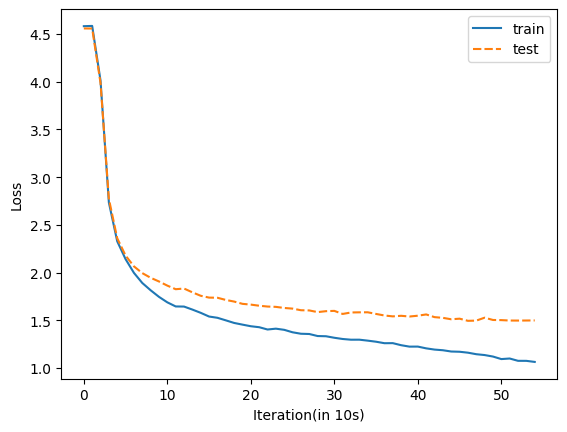

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
losses_df = pd.DataFrame(losses_data)
losses_df = losses_df.applymap(lambda x: float(x))
print(losses_df.head())
# Line graph of loss train and loss test
ax = sns.lineplot(data=losses_df[losses_df['train'] < 10])
ax.set(xlabel='Iteration(in 10s)', ylabel='Loss')
plt.show()